In [1]:
# %matplotlib notebook

import os, h5py, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import signal
from scipy.optimize import curve_fit 
from scipy.stats import zscore

sys.path.append('../')
from visualize_functions import show_images, plot_curve, show_grid_plots, label_violinplot
from analyze_spot_functions import NormalizeData
from fitting_functions import load_curve, load_multiple_curves, detect_peaks, remove_outlier, fit_exp_function, analyze_curves
from scipy.signal import savgol_filter

plt.rcParams.update(mpl.rcParamsDefault)
rc_plot = {'figure.figsize':(12,2.5),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 18,

          'xtick.labelsize': 14,
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labelbottom': True,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 14,
          'ytick.direction': 'in',
          'ytick.right': True,
          'ytick.left': True,
          'ytick.labelleft': True,
          'ytick.labelright': False,

          'legend.fontsize': 10,
          'font.family': 'sans-serif'}

import sys
sys.path.append('../')
from visualize_functions import show_images, plot_curve, show_grid_plots, label_violinplot
from analyze_spot_functions import NormalizeData
from fitting_functions import load_curve, load_multiple_curves, detect_peaks, remove_outlier, fit_exp_function, analyze_curves
   


In [154]:


def normalize_0_1(y, I_start, I_end, I_diff):
    # use I/I0, I0 is saturation intensity (last value) and scale to 0-1 based 
    if I_end - I_start == 0: # avoid devide by 0
        y_nor = (y-I_start)
    elif I_diff: # use fixed I_diff
        if I_end < I_start:
            y_nor = (y-I_start)/(-I_diff)
        else:
            y_nor = (y-I_start)/I_diff # I-Imin/Imax-Imin (I/I0)
    return y_nor

def de_normalize_0_1(y_nor_fit, I_start, I_end, I_diff):
    # reverse calculation for y_fit
    if I_end - I_start == 0: # avoid devide by 0
        y_fit = y_nor_fit+I_start
    elif I_diff: # use fixed I_diff
        if I_end < I_start:
            y_fit = y_nor_fit*(-I_diff)+I_start
        else:
            y_fit = y_nor_fit*I_diff+I_start
    return y_fit

            
def process_rheed_data(xs, ys, I_diff, length=500, savgol_window_order=(15, 3), pca_component=10):
    # normalize data
    ys_nor = []
    for y in ys:
        x = np.linspace(1e-5, 1, len(y)) # use second as x axis unit
        n_avg = len(y)//100+3
        I_end = np.mean(y[-n_avg:])
        I_start = np.mean(y[:n_avg])
        y_nor = normalize_0_1(y, I_start, I_end, I_diff)
    ys_nor.append(y_nor)
    
    # interpolate the data to same size 
    if length:
        xs_sl = []
        ys_nor_sl = []
        for x, y in zip(xs, ys_nor):
            x_sl = np.linspace(np.min(x), np.max(x), length)
            y_sl = np.interp(x_sl, x, y)
            xs_all_sl.append(x_sl)
            ys_nor_sl.append(y_sl)
    xs_sl, ys_nor_sl = np.array(xs_sl), np.array(ys_nor_sl)

    # denoise
    if savgol_window_order:
        ys_nor_sl_denoised = savgol_filter(ys_nor_sl, savgol_window_order[0], savgol_window_order[1])
    if pca_component:
        pca = PCA(n_components=pca_component)
        ys_nor_sl_denoised = pca.inverse_transform(pca.fit_transform(ys_nor_sl_denoised))
    return xs_sl, ys_nor_sl_denoised


def fit_exp_function(xs, ys, fit_settings = {'I_diff': 5000, 'bounds':[0.01, 1], 'p_init':(1, 0.1)}):
    '''
    I_diff: Intensity difference used to normalize the curve to 0-1;
    
    '''
    def exp_func(x, a, b):
        return a*(1 - np.exp(-x/b))
    
    I_diff = fit_settings['I_diff']
    bounds = fit_settings['bounds']
    p_init = fit_settings['p_init']

    parameters = []
    ys_nor, ys_nor_fit, ys_fit = [], [], []
    labels = []
    
    for i in range(len(xs)):
        
        # section: normalize the curve
        x = np.linspace(1e-5, 1, len(ys[i])) # use second as x axis unit
        n_avg = len(ys[i])//100+3
        I_end = np.mean(ys[i][-n_avg:])
        I_start = np.mean(ys[i][:n_avg])
    
        y_nor = normalize_0_1(ys[i], I_start, I_end, I_diff)
        params, params_covariance = curve_fit(exp_func, x, y_nor, p0=p_init, bounds=bounds, absolute_sigma=False) 
        a, b = params
        y_nor_fit = exp_func(x, a, b)
        y_fit = de_normalize_0_1(y_nor_fit, I_start, I_end, I_diff)
        
        parameters.append((a, b))
        ys_fit.append(y_fit)
        ys_nor.append(y_nor)
        ys_nor_fit.append(y_nor_fit)
        labels.append(f'index {i+1}:\ny={np.round(a, 2)}*(1-exp(-t/{np.round(b, 2)})')
        
    return np.array(parameters), [xs, ys, ys_fit, ys_nor, ys_nor_fit, labels]

In [144]:
def analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=500, interval=1000, visualize=False,
                   fit_settings={'I_diff': 8000, 'bounds':[0.01, 1], 'p_init':(1, 0.1)}):
    '''
    h5_para_file: String, path of the h5 file name, containing information about the RHEED spots;
    growth_dict: names of the growth index and corresponding frequency;
    spot: String, name of the RHEED spot to collect, choice of "spot_1", "spot_2" or "spot_3"; 
    metric: String, name of the metric to analyze the RHEED spot, choice of ...;
    camera_freq: int, camera frequency of data acquisition. Default camera_freq is 500 fps;
    interval=1000;
    title=None;
    upper_limit: int, the number of levels to smooth the curve by remove the outliers. Default is 0;
    visualize=False;
    fit_settings: setting parameters for fitting function
    '''

    parameters_all, x_list_all = [], []
    xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all = [], [], [], [], [], []
    
    x_end = 0
    for growth_name in list(growth_dict.keys()):

        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name],
                                       step_size=5, prominence=0.1)
        # fit exponential function
        parameters, info = fit_exp_function(xs, ys, fit_settings=fit_settings)        
        parameters_all.append(parameters)
        xs, ys, ys_fit, ys_nor, ys_nor_fit, labels = info
        xs_all+=xs
        ys_all+=ys
        ys_fit_all+=ys_fit
        ys_nor_all+=ys_nor
        ys_nor_fit_all+=ys_nor_fit
        labels_all += labels

        if x_list_all != []:
            x_list = x_peaks[:-1] + x_end
        else:
            x_list = x_peaks[:-1]

        if visualize:
            if x_list_all != []:
                sample_x += x_end
                x_peaks += x_end

            labels_dict = {}
            for i, x in enumerate(x_peaks[:-1]):
                labels_dict[x] = labels[i]
            plot_curve(np.concatenate(xs), np.concatenate(ys), curve_y_fit=np.concatenate(ys_fit), labels_dict=labels_dict,
                       plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12, 4))  
            plot_curve(x_list, parameters[:,1], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_list, parameters[:,0], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Intensity Magnitude (a.u.)', 
                       yaxis_style='linear', figsize=(12, 4))
            show_grid_plots(xs, ys_nor, labels, ys_nor_fit, ylim=None)
            show_grid_plots(xs, ys, labels, ys_fit, ylim=None)
        
        x_end = round(x_end + (len(sample_x)+interval)/camera_freq, 2)
        x_list_all.append(x_list)
        
    x_list_all = np.concatenate(x_list_all)[:len(parameters_all)]
    return np.array(parameters_all), x_list_all, [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all]

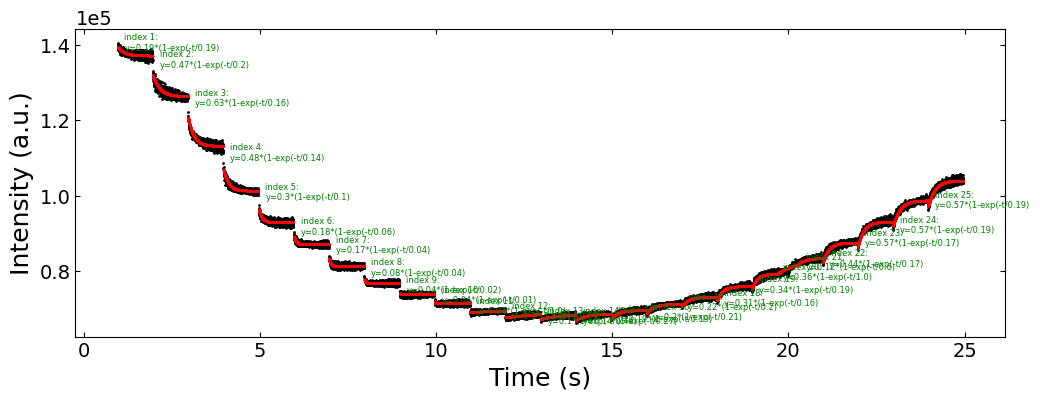

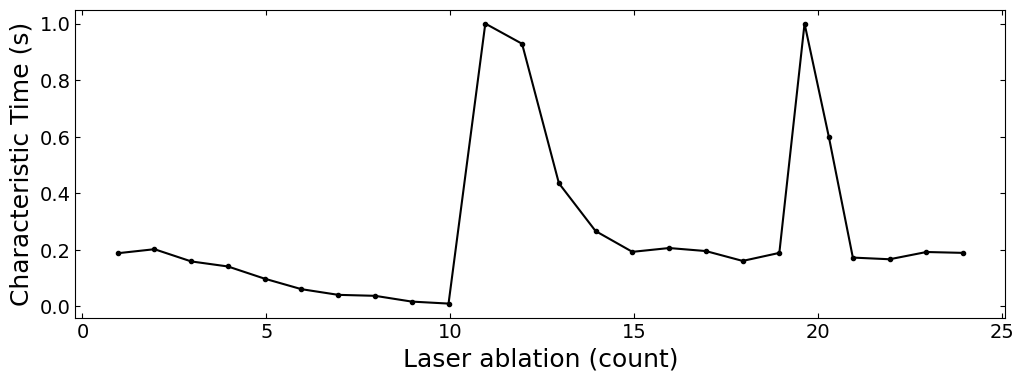

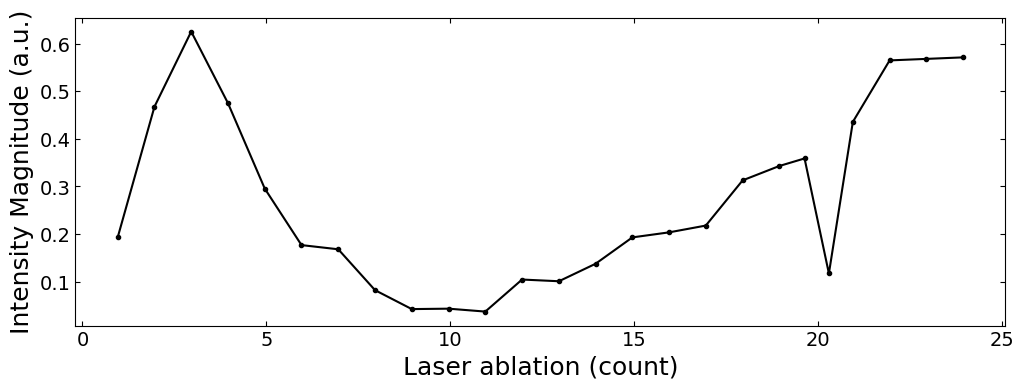

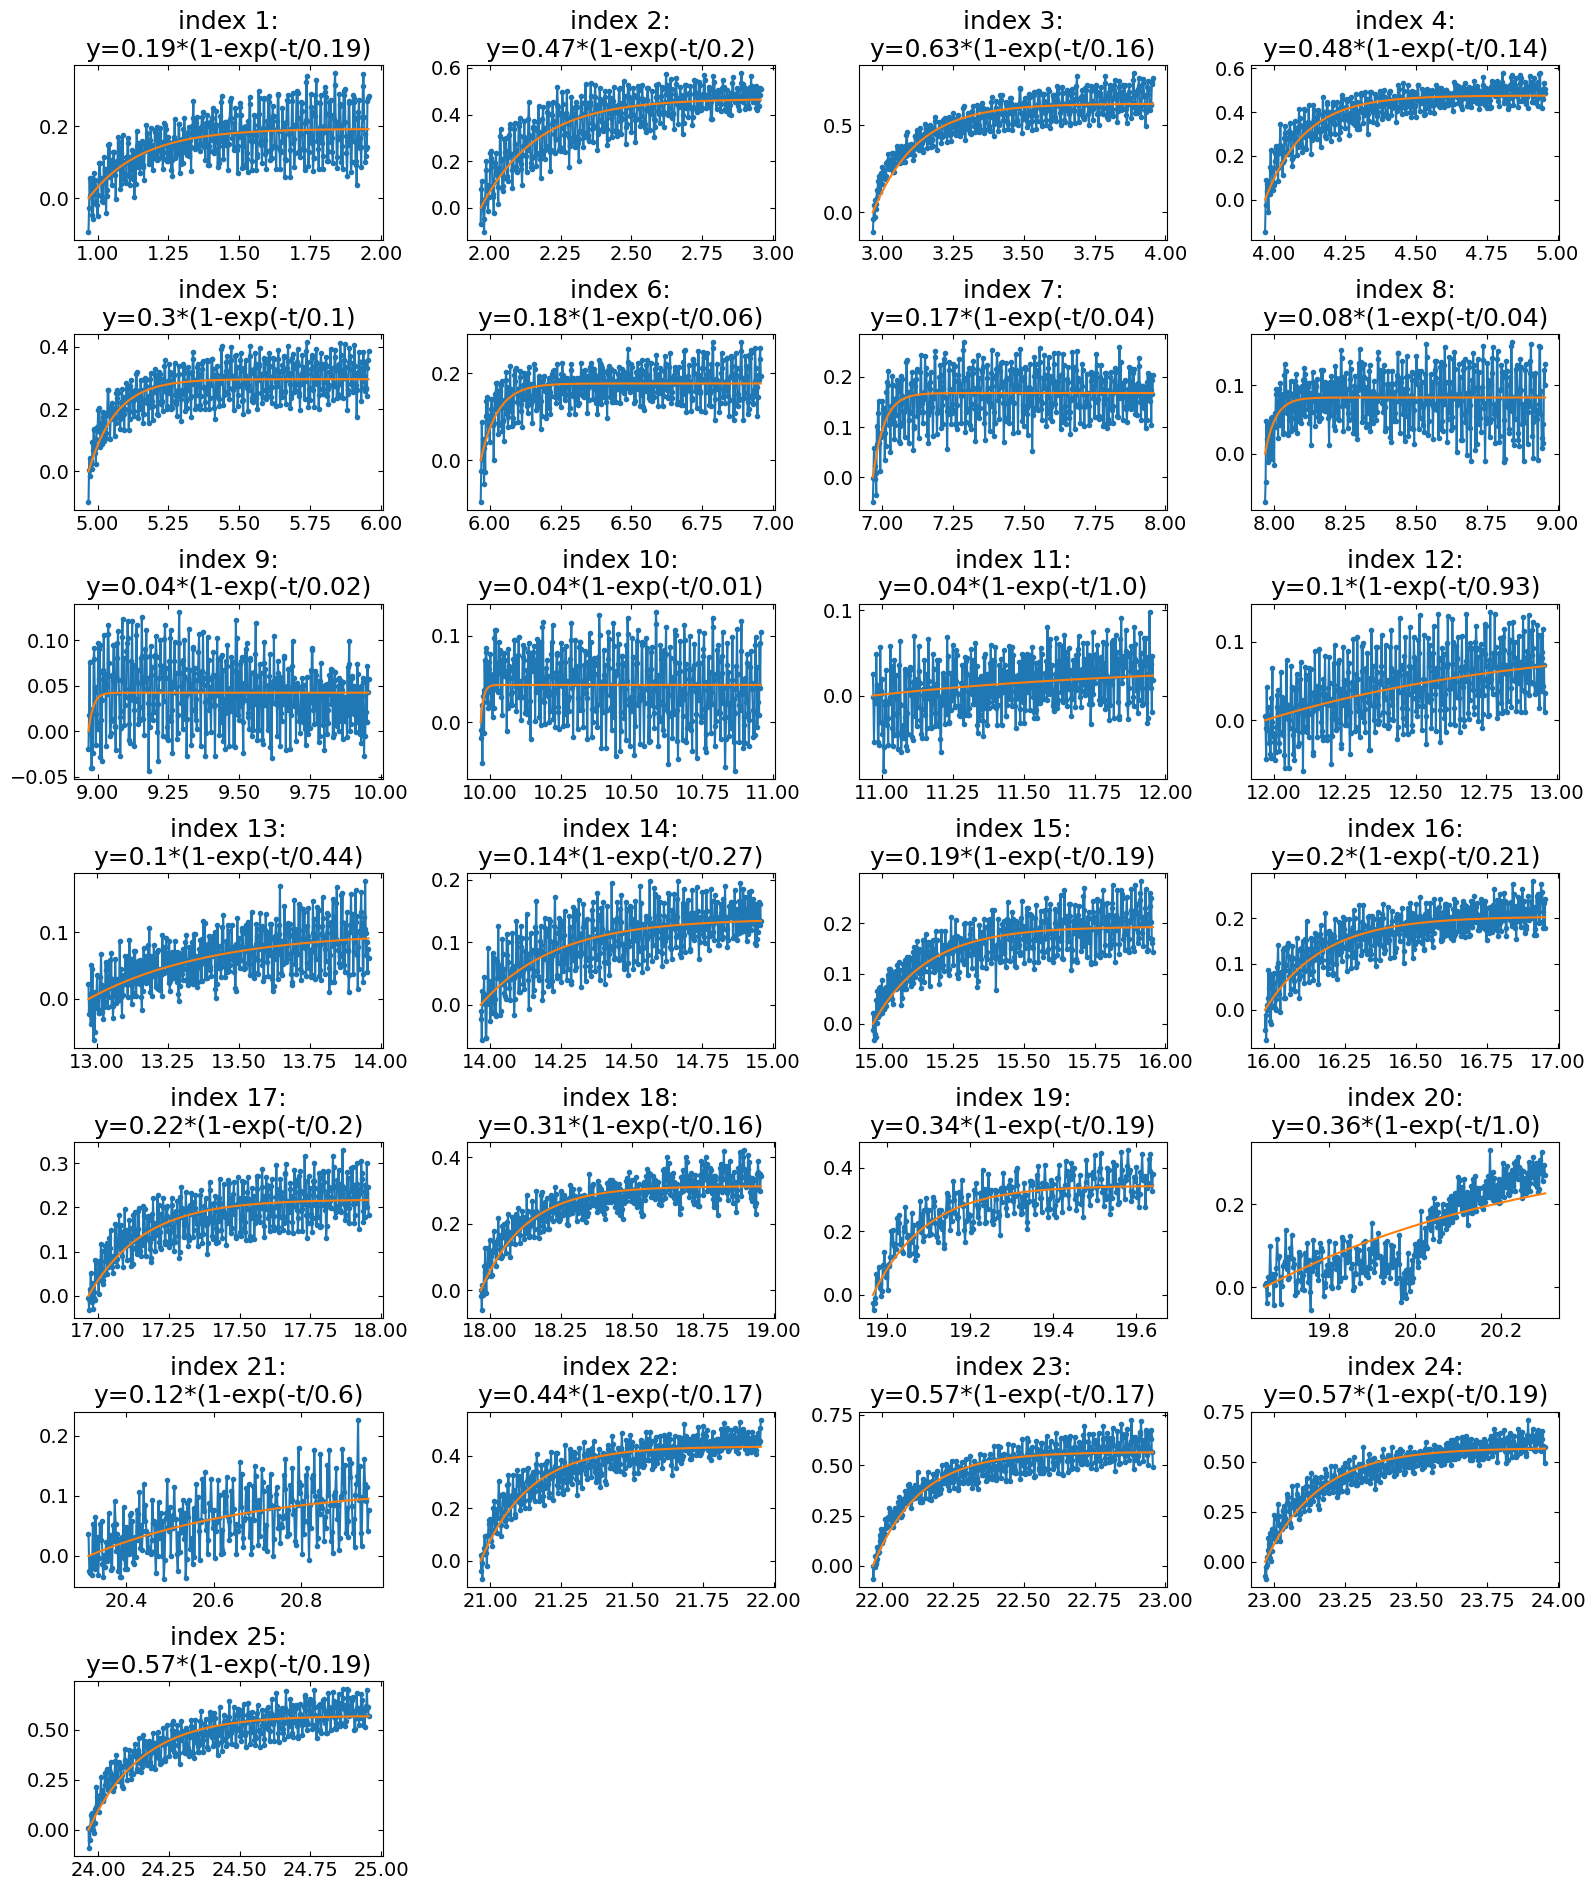

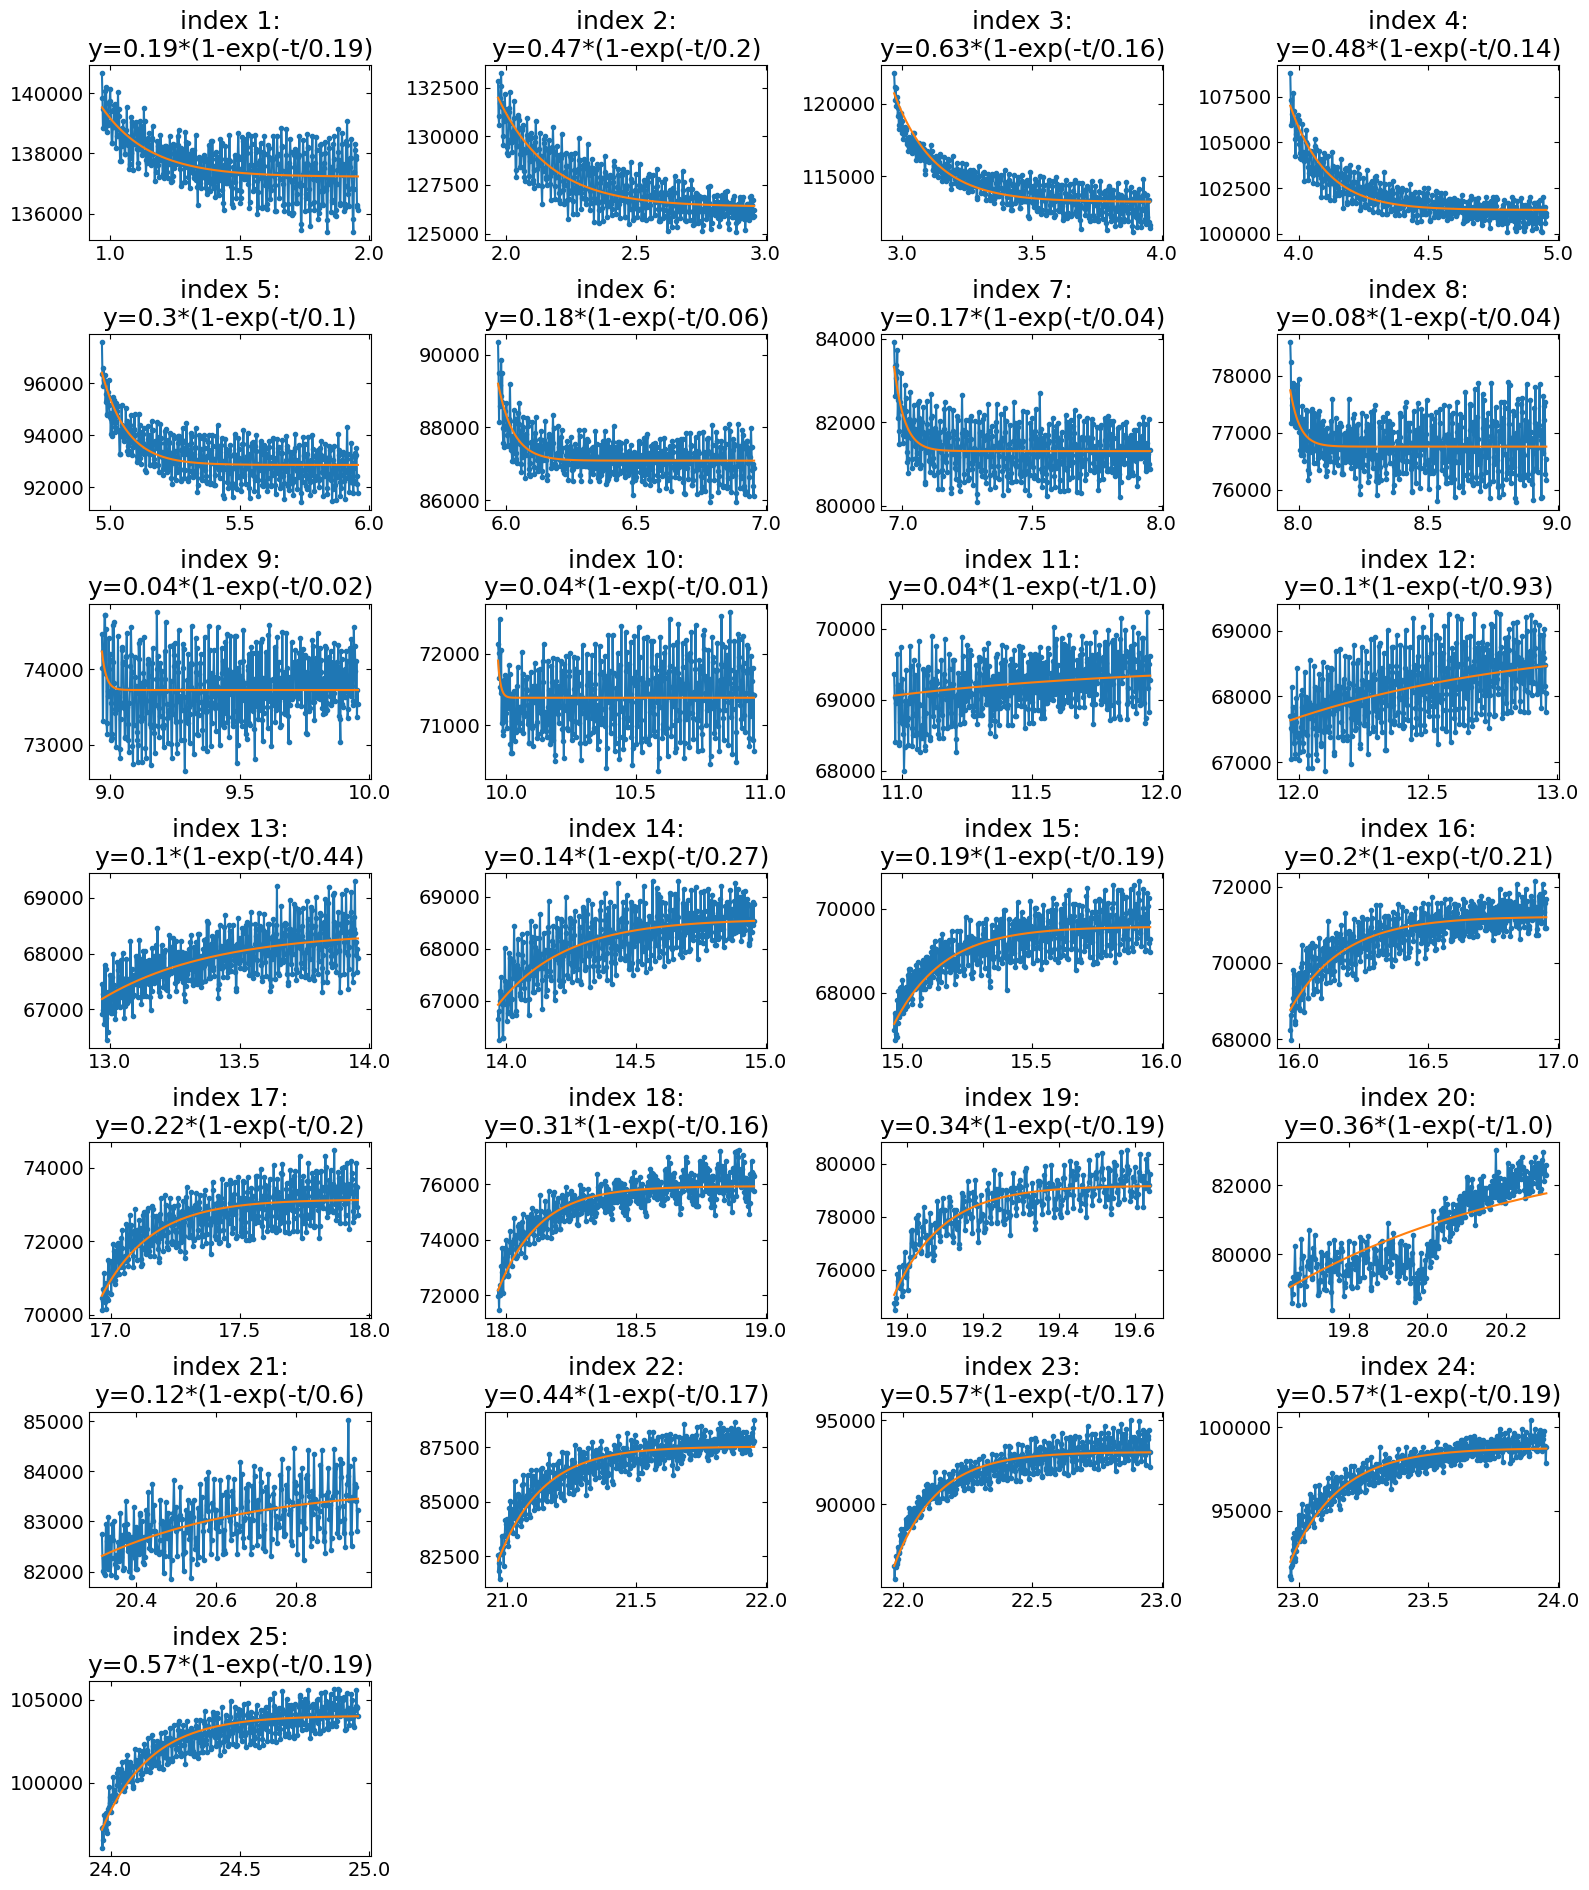

In [145]:
plt.rcParams.update(rc_plot)
growth_dict = {'growth_1.':1}
spot = 'spot_2'
metric = 'img_intensity'
fit_settings={'I_diff': 12000, 'bounds':[0.01, 1], 'p_init':(1, 0.1)}

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
parameters_all, x, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=500, interval=1000,  visualize=True, 
                                 fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all] = info

In [131]:
def dl_label(parameters_all):
    labels = []
    for i, parameters in enumerate(parameters_all):
        parameters[5] = np.round(1/parameters[5]/10, 2)
        parameters[8] = np.round(1/parameters[8]/10, 2)

        parameters_str = []
        for p in parameters:
            parameters_str.append(str(p))
        a, b, c, m1, m2, relax_12, m3, m4, relax_34 = parameters_str
        
        labels.append(f'index: {i+1}\ny=')
        if a != str(0.0): labels[i] += a + '+\n'
        if b != str(0.0): labels[i] += f'{b}*t+\n'
        if c != str(0.0): labels[i] += f'{c}*(t^2)+\n'
    #     print(m1, m2, relax_12, m3, m4, relax_34)

        if relax_12!=str(np.inf): 
            if (m1!=str(0.0) and m2!=str(0.0)): 
                labels[i] += f'({m1}+{m2}*t)*(1-exp(t/{relax_12}))+\n'
            elif m1!=str(0.0) and m2==str(0.0): 
                labels[i] += f'{m1}*(1-exp(t/{relax_12}))+\n'
            elif m2!=str(0.0) and m1==str(0.0): 
                labels[i] += f'({m2}*t)*(1-exp(t/{relax_12}))+\n'

        if relax_34!=str(np.inf): 
            if (m3!=str(0.0) and m4!=str(0.0)): 
                labels[i] += f'({m3}+{m4}*t)*(1-exp(t/{relax_34}))'
            elif m3!=str(0.0) and m4==str(0.0): 
                labels[i] += f'{m3}*(1-exp(t/{relax_34}))'
            elif m4!=str(0.0) and m3==str(0.0): 
                labels[i] += f'({m4}*t)*(1-exp(t/{relax_34}))'

        if labels[i][-1] == '\n': labels[i] = labels[i][:-2]
        if labels[i][-1] == '+': labels[i] = labels[i][:-1]
        if labels[i][-1] == '=': labels[i] += 'constant'
    return labels



def predict_parameters(xs, ys, I_diff, model_path=None, device='cpu'):
    xs, ys = process_rheed_data(xs, ys, I_diff=I_diff, length=500, savgol_window_order=(15,3), pca_component=10)        
    
    # section: normalize the curve
    ys_nor = []
    for x, y in zip(xs, ys):
        n_avg = len(y)//100+3
        I_end = np.mean(y[-n_avg:])
        I_start = np.mean(y[:n_avg])

        # use I/I0, I0 is saturation intensity (last value) and scale to 0-1 based 
        if I_end - I_start == 0: # avoid devide by 0
            y_nor = (y-I_start)
            
        elif I_diff: # use fixed I_diff
            if I_end < I_start:
                y_nor = (y-I_start)/(-I_diff)
            else:
                y_nor = (y-I_start)/I_diff # I-Imin/Imax-Imin (I/I0)
        ys_nor.append(y_nor)
        
    model = torch.load(model_path).to(device)
    inputs = torch.tensor(ys_nor).to(device).to(torch.float32).unsqueeze(1)
    ys_nor_fit, parameters_np = model(inputs)
    parameters_np = np.round(parameters_np.squeeze().detach().numpy(), 2)
    labels = dl_label(parameters_np)
    ys_nor_fit = ys_nor_fit.detach().cpu().squeeze().numpy()
    
    # reverse calculation for y_fit
    ys_fit = []
    for x, y, y_nor_fit in zip(xs, ys, ys_nor_fit):
        n_avg = len(y)//100+3
        I_end = np.mean(y[-n_avg:])
        I_start = np.mean(y[:n_avg])
        
        if I_end - I_start == 0: # avoid devide by 0
            y_fit = y_nor_fit+I_start
        elif I_diff: # use fixed I_diff
            if I_end < I_start: y_fit = y_nor_fit*(-I_diff)+I_start
            else: y_fit = y_nor_fit*I_diff+I_start
        ys_fit.append(y_fit)
    ys_fit = np.array(ys_fit)
    return parameters_np, [xs, ys, ys_fit, ys_nor, ys_nor_fit, labels]


def analyze_curves_dl(h5_para_file, growth_dict, spot, metric, camera_freq=500, interval=1000, visualize=False, 
                      I_diff=8000, mdoel_path=None):
    '''
    h5_para_file: String, path of the h5 file name, containing information about the RHEED spots;
    growth_dict: names of the growth index and corresponding frequency;
    spot: String, name of the RHEED spot to collect, choice of "spot_1", "spot_2" or "spot_3"; 
    metric: String, name of the metric to analyze the RHEED spot, choice of ...;
    camera_freq: int, camera frequency of data acquisition. Default camera_freq is 500 fps;
    interval=1000;
    visualize=False;
    '''

    parameters_all, x_coor_all = [], []
    xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all = [], [], [], [], [], []
    
    x_end = 0
    for growth_name in list(growth_dict.keys()):

        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name],
                                       step_size=5, prominence=0.1)
        # fit exponential function
        parameters_np, info = predict_parameters(xs, ys, I_diff, model_path=model_path, device='cpu')      
        parameters_all.append(parameters_np)
        xs, ys, ys_fit, ys_nor, ys_nor_fit, labels = info
        xs_all.append(xs)
        ys_all.append(ys)
        ys_fit_all.append(ys_fit)
        ys_nor_all.append(ys_nor)
        ys_nor_fit_all.append(ys_nor_fit)
        labels_all += labels

        # get the x coordinates for fitting parameters 
        if x_coor_all != []: x_coor = np.array(x_peaks[:-1] + x_end)
        else: x_coor = np.array(x_peaks[:-1])
        
        if visualize:
            if len(growth_dict) == 1: labels_dict = {}
            for i, x in enumerate(x_coor): labels_dict[x] = labels[i]
                
#             print(np.concatenate(xs).shape, np.concatenate(ys).shape, np.concatenate(ys_fit).shape)
            plot_curve(np.concatenate(xs), np.concatenate(ys), curve_y_fit=np.concatenate(ys_fit), labels_dict=labels_dict,
                       plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12, 4))  
    
#             print(x_coor.shape, parameters_np.shape)
            plot_curve(x_coor, parameters_np[:, 0], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='a', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_coor, parameters_np[:, 1], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='b', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_coor, parameters_np[:, 2], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='c', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_coor, parameters_np[:, 3], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='m1', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_coor, parameters_np[:, 4], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='m2', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_coor, parameters_np[:, 5], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='relax_12', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_coor, parameters_np[:, 6], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='m3', 
                       yaxis_style='linear', figsize=(12, 4), ylim=(0, 0.62))
            plot_curve(x_coor, parameters_np[:, 7], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='m4', 
                       yaxis_style='linear', figsize=(12, 4))
            plot_curve(x_coor, parameters_np[:, 8], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='relax_34', 
                       yaxis_style='linear', figsize=(12, 4))
            
#             print(xs, ys_nor, ys_nor_fit)
            show_grid_plots(xs, ys_nor, labels=labels, ys_fit=ys_nor_fit, subplot_height=3)
        
        x_end = round(x_end + (len(sample_x)+interval)/camera_freq, 2)
        x_coor_all.append(x_coor)
        
    parameters_all = np.concatenate(parameters_all)
    x_coor_all = np.concatenate(x_coor_all)[:len(parameters_all)]
#     print(x_coor_all.shape, parameters_all.shape)
    return parameters_all, x_coor_all, [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all]

<ipython-input-129-ca03458f2e2f>:25: RuntimeWarning: divide by zero encountered in true_divide
  parameters[5] = np.round(1/parameters[5]/10, 2)


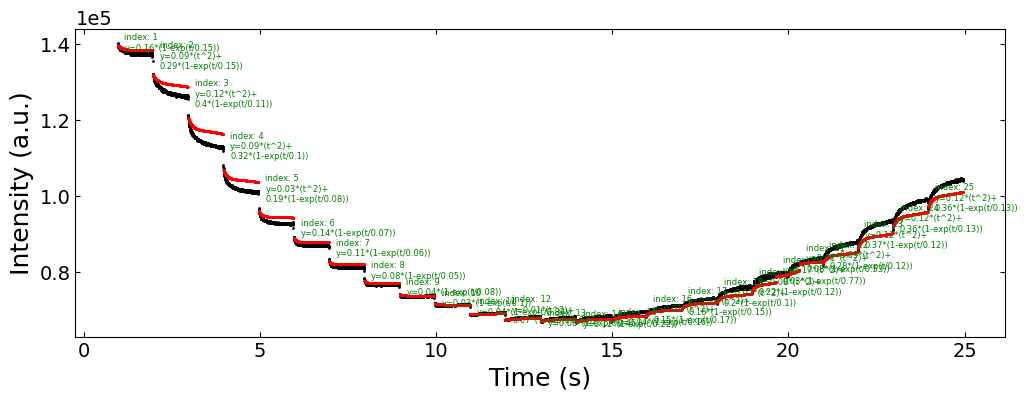

(25,) (25, 9)


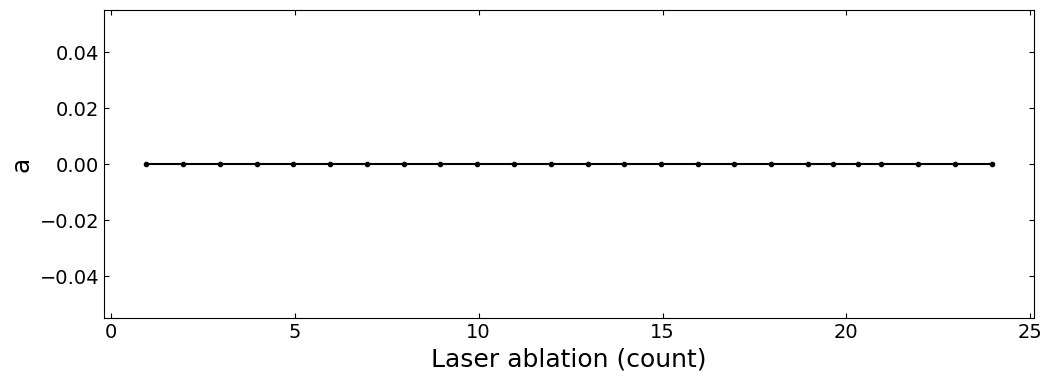

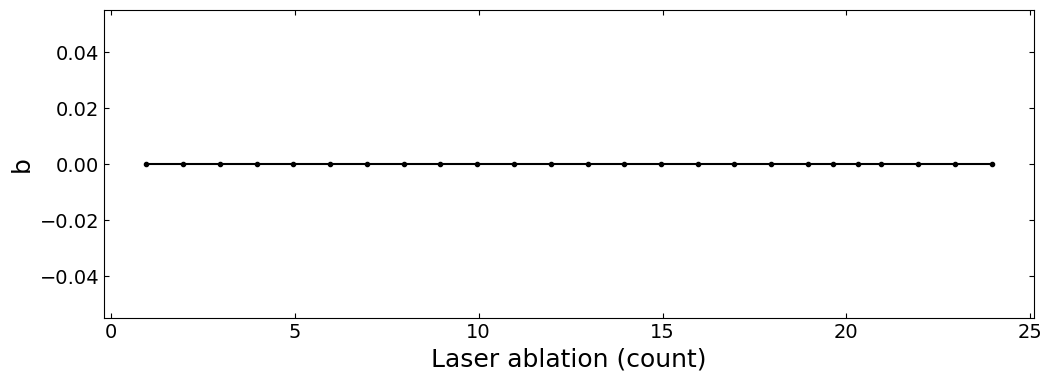

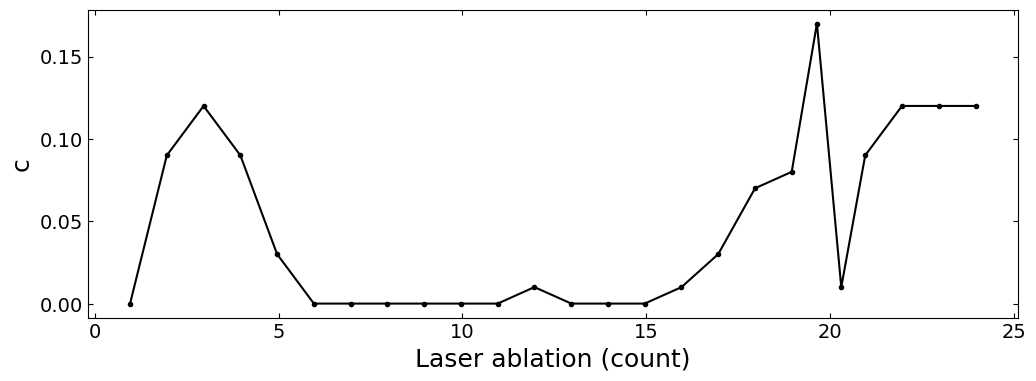

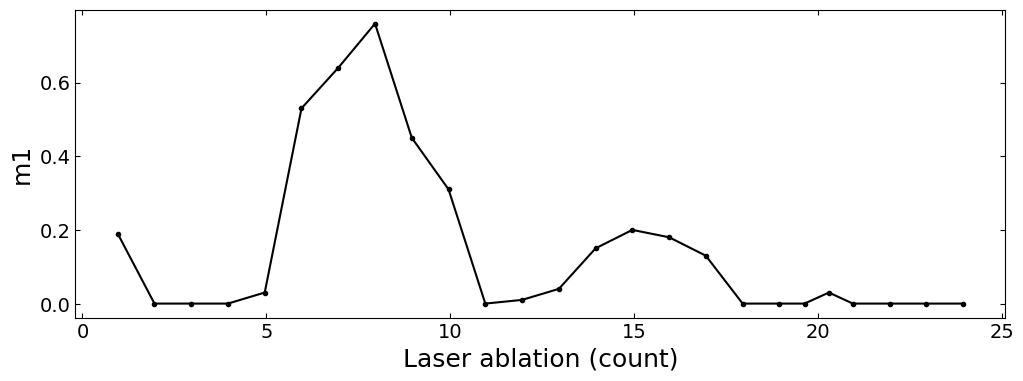

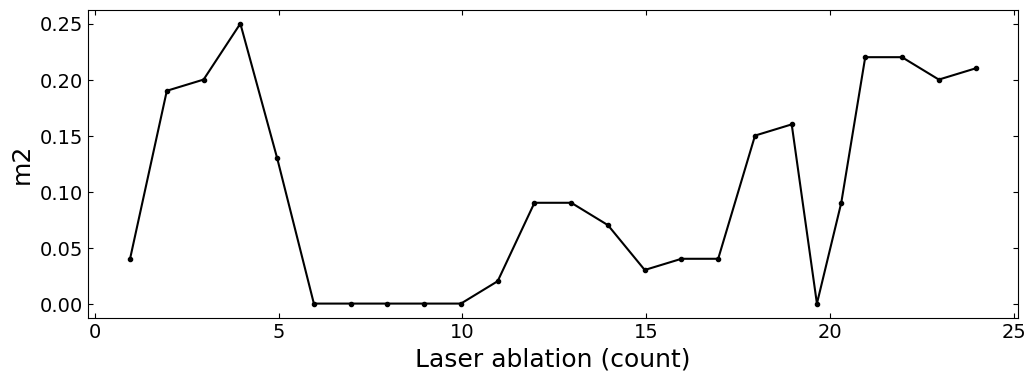

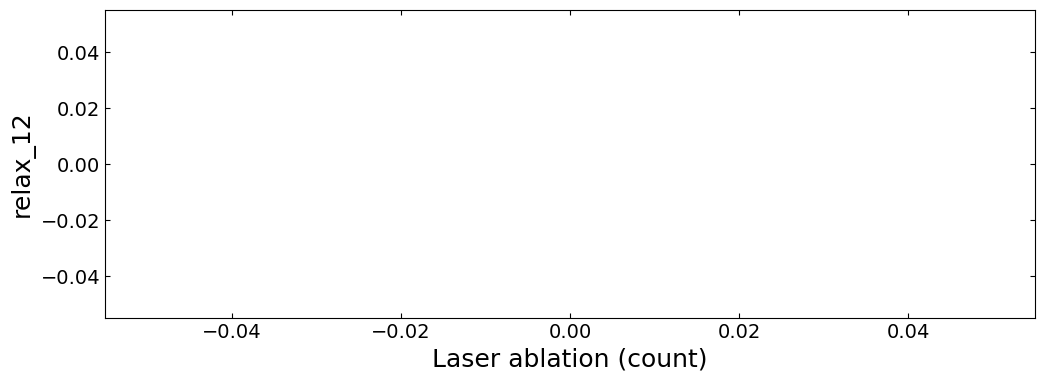

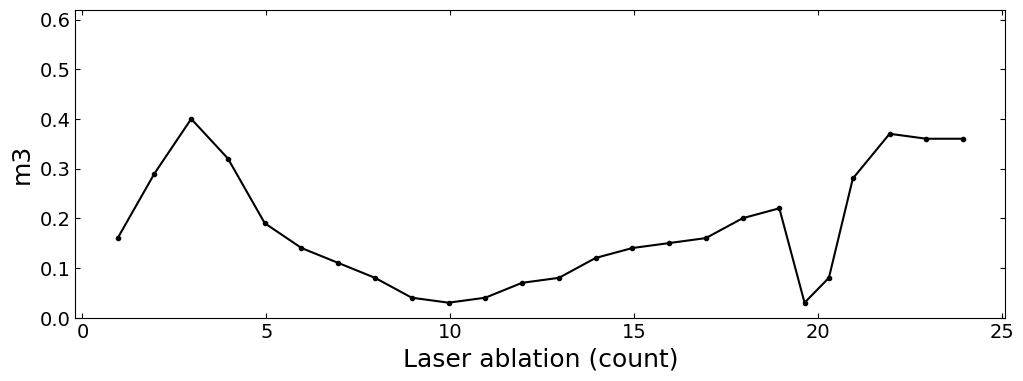

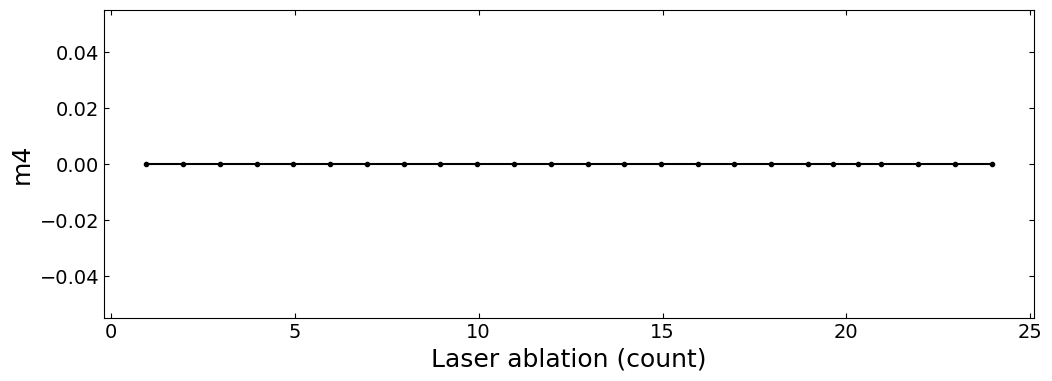

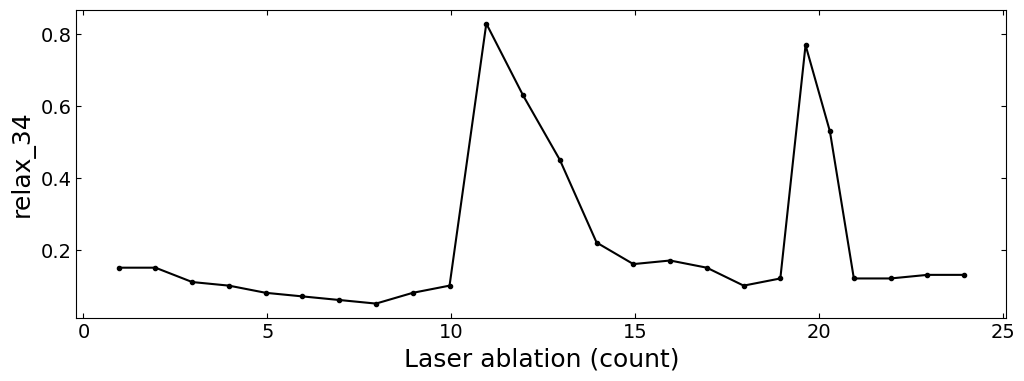

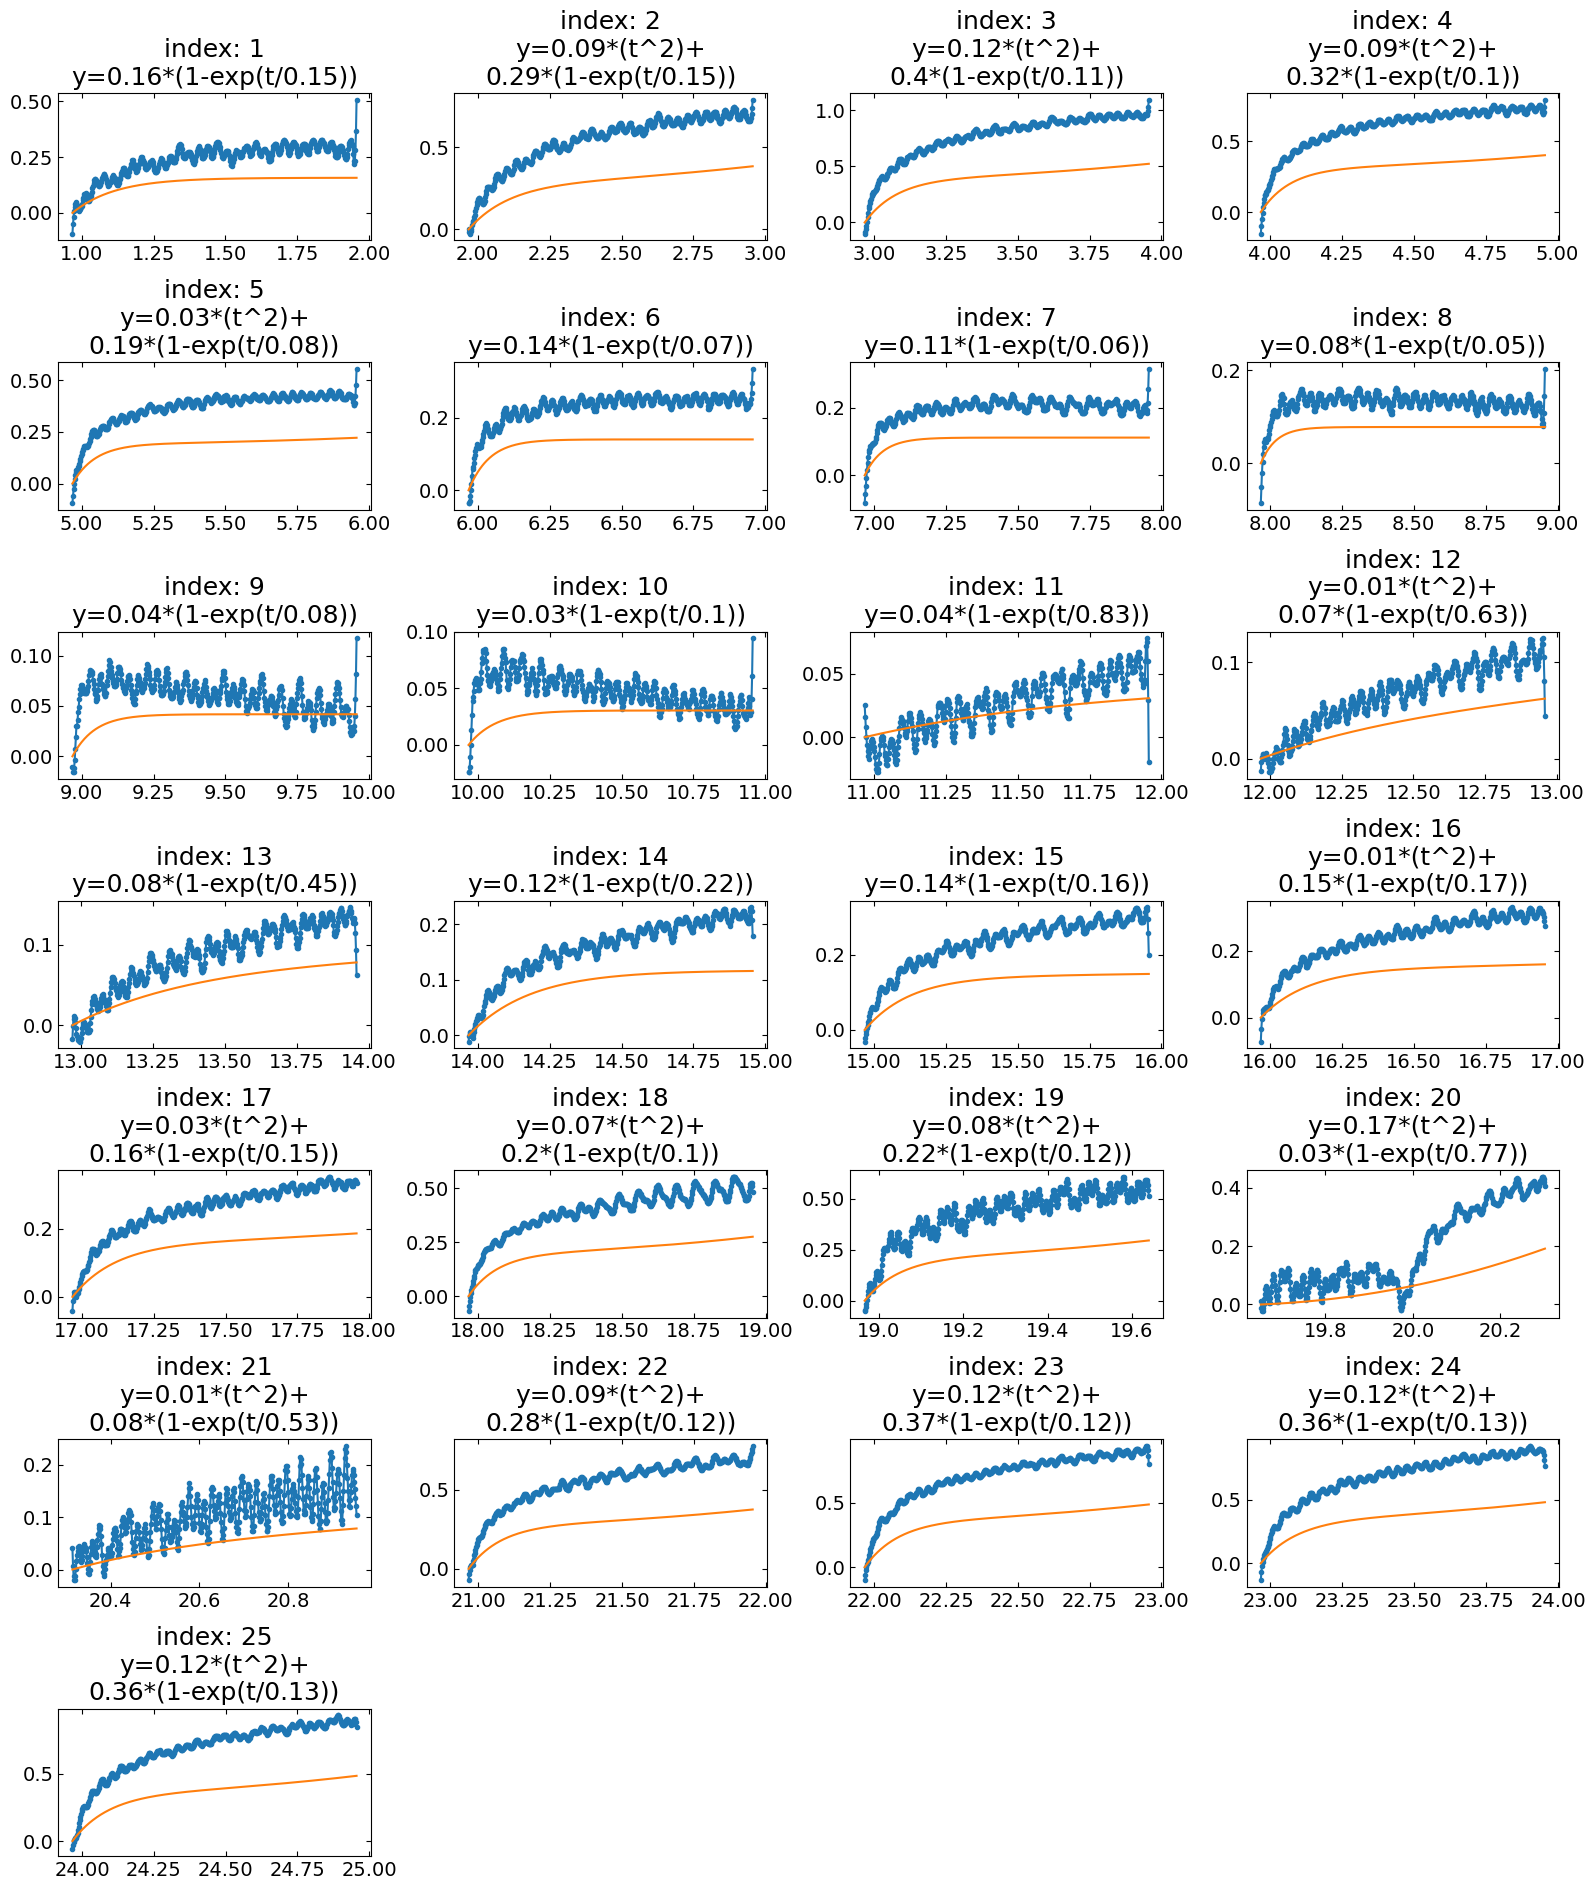

(25,) (25, 9)


In [133]:
spot = 'spot_2'
metric = 'img_intensity'
fit_settings={'fit_func': 'exp', 'I_diff': 13000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
              'from_previous': False, 'weight_previous': False, 'relative_intensity': False, 'use_prev_as_bound': True}

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
# growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
growth_dict = {'growth_1.':1}
length = 500
model_path = 'linear_model_9parameters_test6_savgolPCA.pt'
visualize = True

parameters_all, x_coor_all, info = analyze_curves_dl(h5_para_file, growth_dict, spot, metric, camera_freq=500, interval=1000, visualize=visualize, 
                  I_diff=8000, mdoel_path=None)

In [235]:
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
visualize = True
batch_size = 32

In [236]:
    xs_all, ys_all, ys_nor_all = [], [], []
    for growth_name in list(growth_dict.keys()):
        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name],
                                       step_size=5, prominence=0.1)
        ys_nor = process_rheed_data(xs, ys, I_diff=13000, length=500, savgol_window_order=(15, 3), pca_component=10)
        xs_all.append(xs)
        ys_all.append(ys)
        ys_nor_all.append(ys_nor)

In [237]:
    length = 500

    xs_all, ys_all, xs_nor_all, ys_nor_all = [], [], [], []
    for growth_name in list(growth_dict.keys()):
        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name], step_size=5, prominence=0.1)
        xs_nor, ys_nor = process_rheed_data(xs, ys, I_diff=13000, length=500, savgol_window_order=(15, 3), pca_component=10)
        xs_all.append(xs)
        ys_all.append(ys)
        xs_nor_all.append(xs_nor)
        ys_nor_all.append(ys_nor)
            
    xs_nor_all = np.concatenate(xs_nor_all, 0)
    ys_nor_all = np.concatenate(ys_nor_all, 0)

In [238]:
    full_dataset = torch.utils.data.TensorDataset(torch.tensor(ys_nor_all).unsqueeze(1))
    dl = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

In [242]:
def prepare_dataloader(h5_para_file, growth_dict, batch_size, visualize=False):
    xs_all, ys_all, xs_nor_all, ys_nor_all = [], [], [], []
    for growth_name in list(growth_dict.keys()):
        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name], step_size=5, prominence=0.1)
        xs_nor, ys_nor = process_rheed_data(xs, ys, I_diff=13000, length=500, savgol_window_order=(15, 3), pca_component=10)
        xs_all.append(xs)
        ys_all.append(ys)
        xs_nor_all.append(xs_nor)
        ys_nor_all.append(ys_nor)
    xs_nor_all = np.concatenate(xs_nor_all, 0)
    ys_nor_all = np.concatenate(ys_nor_all, 0)
    
    xs_all, ys_all, xs_nor_all, ys_nor_all = [], [], [], []
    for growth_name in list(growth_dict.keys()):
        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name], step_size=5, prominence=0.1)
        xs_nor, ys_nor = process_rheed_data(xs, ys, I_diff=13000, length=500, savgol_window_order=(15, 3), pca_component=10)
        xs_all.append(xs)
        ys_all.append(ys)
        xs_nor_all.append(xs_nor)
        ys_nor_all.append(ys_nor)
            
    xs_nor_all = np.concatenate(xs_nor_all, 0)
    ys_nor_all = np.concatenate(ys_nor_all, 0)
    return dl, xs_nor_all, ys_nor_all

# train test6 model

In [243]:
import os, glob, random
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models


def normalize_0_1(y, I_start, I_end, I_diff):
    # use I/I0, I0 is saturation intensity (last value) and scale to 0-1 based 
    if I_end - I_start == 0: # avoid devide by 0
        y_nor = (y-I_start)
    elif I_diff: # use fixed I_diff
        if I_end < I_start:
            y_nor = (y-I_start)/(-I_diff)
        else:
            y_nor = (y-I_start)/I_diff # I-Imin/Imax-Imin (I/I0)
    return y_nor

def process_rheed_data(xs, ys, I_diff, length=500, savgol_window_order=(15, 3), pca_component=10):
#     print(len(xs[0]), len(ys[0]))
    
    # normalize data
    ys_nor = []
    for y in ys:
        x = np.linspace(1e-5, 1, len(y)) # use second as x axis unit
        n_avg = len(y)//100+3
        I_end = np.mean(y[-n_avg:])
        I_start = np.mean(y[:n_avg])
        y_nor = normalize_0_1(y, I_start, I_end, I_diff)
        ys_nor.append(y_nor)
    
#     print('1:', len(xs[0]), len(ys_nor[0]))
    # interpolate the data to same size 
    if length:
        xs_sl = []
        ys_nor_sl = []
        for x, y_nor in zip(xs, ys_nor):
            x_sl = np.linspace(np.min(x), np.max(x), length)
#             print(len(x_sl), len(x), len(y_nor))
            y_sl = np.interp(x_sl, x, y_nor)
            xs_sl.append(x_sl)
            ys_nor_sl.append(y_sl)
    xs_sl, ys_nor_sl = np.array(xs_sl), np.array(ys_nor_sl)

    # denoise
    if savgol_window_order:
        ys_nor_sl_denoised = savgol_filter(ys_nor_sl, savgol_window_order[0], savgol_window_order[1])
    if pca_component:
        pca = PCA(n_components=pca_component)
        ys_nor_sl_denoised = pca.inverse_transform(pca.fit_transform(ys_nor_sl_denoised))
    return xs_sl, ys_nor_sl_denoised


def prepare_dataloader(h5_para_file, growth_dict, batch_size, visualize=False):
    xs_all, ys_all, xs_nor_all, ys_nor_all = [], [], [], []
    for growth_name in list(growth_dict.keys()):
        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name], step_size=5, prominence=0.1)
        xs_nor, ys_nor = process_rheed_data(xs, ys, I_diff=13000, length=500, savgol_window_order=(15, 3), pca_component=10)
        xs_all.append(xs)
        ys_all.append(ys)
        xs_nor_all.append(xs_nor)
        ys_nor_all.append(ys_nor)
    xs_nor_all = np.concatenate(xs_nor_all, 0)
    ys_nor_all = np.concatenate(ys_nor_all, 0)
    
    xs_all, ys_all, xs_nor_all, ys_nor_all = [], [], [], []
    for growth_name in list(growth_dict.keys()):
        # load data
        sample_x, sample_y = load_curve(h5_para_file, growth_name, 'spot_2', 'img_intensity', camera_freq=500, x_start=0)

        # detect peaks
        x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=growth_dict[growth_name], step_size=5, prominence=0.1)
        xs_nor, ys_nor = process_rheed_data(xs, ys, I_diff=13000, length=500, savgol_window_order=(15, 3), pca_component=10)
        xs_all.append(xs)
        ys_all.append(ys)
        xs_nor_all.append(xs_nor)
        ys_nor_all.append(ys_nor)
            
    xs_nor_all = np.concatenate(xs_nor_all, 0)
    ys_nor_all = np.concatenate(ys_nor_all, 0)
    return dl, xs_nor_all, ys_nor_all


class model_linear(nn.Module):
    def __init__(self):
        super().__init__()   

        self.bn1 = nn.BatchNorm1d(1)
        self.linear1 = nn.Linear(500, 1000) 
        
        self.bn2 = nn.BatchNorm1d(1)
        self.linear2 = nn.Linear(1000, 2000)
        
        self.bn3 = nn.BatchNorm1d(1)
        self.linear3 = nn.Linear(2000, 2000)
        
        self.bn4 = nn.BatchNorm1d(1)
        self.linear4 = nn.Linear(2000, 100)
        
        self.linear5 = nn.Linear(100, 9)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.linear1(x)
        x = self.relu(x)

        x = self.bn2(x)
        x = self.linear2(x)
        x = self.relu(x)        
        
        x = self.bn3(x)
        x = self.linear3(x)
        x = self.relu(x)
        
        x = self.bn4(x)
        x = self.linear4(x)
        x = self.relu(x)
        
        x = self.linear5(x)
        x = self.relu(x)

        a, b, c = x[:, 0, 0], x[:, 0, 1], x[:, 0, 2]
        m1, m2, relax_12 = x[:, 0, 3], x[:, 0, 4], x[:, 0, 5]
        m3, m4, relax_34 = x[:, 0, 6], x[:, 0, 7], x[:, 0, 8]
        
        t = torch.linspace(0, 1, 500).unsqueeze(1).repeat(1, len(x)).to(torch.float32).to(x.device)
        y_fit = a + b*t + c*(t**2) + (m1 + m2*t)*(1-torch.exp(-relax_12*10 * t)) + (m3 + m4*t)*(1-torch.exp(-relax_34*10 * t))
        y_fit = torch.swapaxes(y_fit.unsqueeze(1), 0, 2)
        return y_fit, x
    
# model = model_linear()
# print(model)
# out, x = model(torch.randn(32, 1, 500))
# print(out.shape, x.shape)


def train(model, train_dl, epochs, start, device, loss_func, optimizer, scheduler=None):
    model.train()
    train_data_size = len(train_dl.dataset)

    for epoch_idx in range(start, epochs+start):
        print("Epoch: {}/{}".format(epoch_idx+1, epochs+start))

        train_loss = 0.0
        for i, batch in enumerate(tqdm(train_dl)):
            inputs = batch[0]
            inputs = inputs.to(torch.float32).to(device)
            model = model.to(device)

            optimizer.zero_grad()
            out, para = model(inputs)
            loss = loss_func(out, inputs)

            train_loss += loss.item() * inputs.size(0)
            loss.backward()

            metrics = {"train_batch_loss": loss}

            optimizer.step()
            if scheduler:
                scheduler.step()

        avg_train_loss = train_loss/train_data_size
        print("Training Loss: {:.4f}".format(avg_train_loss))


In [244]:
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
dl, y_pca = prepare_dataloader(h5_para_file, growth_dict, batch_size=32, visualize=True)

ValueError: too many values to unpack (expected 2)

In [43]:
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
dl, y_pca = prepare_dataloader(h5_para_file, growth_dict, batch_size=32, visualize=True)

model = model_linear()
print(model)
out, x = model(torch.randn(32, 1, 500))
print(out.shape, x.shape)

device = torch.device('cpu')
NAME = '1d_regression'

lr = 1e-3
loss_func = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

start = 0
epochs = 1000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, 
                            steps_per_epoch=len(dl))

logs = train_epochs(model, loss_func, optimizer, device, dl, epochs, start, scheduler)
torch.save(model, 'linear_model_9parameters_test6_savgolPCA.pt')

# model = torch.load('linear_model_9parameters.pt')
# inputs = torch.tensor(y_data).to(device).to(torch.float32).unsqueeze(1)

inputs = torch.tensor(y_rec).to(device).to(torch.float32).unsqueeze(1)
y_fit, parameters_all = model(inputs)
parameters_all = np.round(parameters_all.squeeze().detach().numpy(), 2)

labels = tag_equation(parameters_all)
t = torch.linspace(0, 1, inputs.shape[-1]).unsqueeze(0).repeat(len(inputs),1)
y = inputs.cpu().squeeze().numpy()
y_fit = y_fit.detach().cpu().squeeze().numpy()
show_grid_plots(t[::10], y[::10], ys_fit=y_fit[::10], labels=labels[::10], subplot_height=3)

model_linear(
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=500, out_features=1000, bias=True)
  (bn2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1000, out_features=2000, bias=True)
  (bn3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=2000, out_features=2000, bias=True)
  (bn4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=2000, out_features=100, bias=True)
  (linear5): Linear(in_features=100, out_features=9, bias=True)
  (relu): ReLU()
)
torch.Size([32, 1, 500]) torch.Size([32, 1, 9])
Epoch: 1/1000


100%|██████████| 7/7 [00:00<00:00, 34.42it/s]


Training Loss: 0.0307
Epoch: 2/1000


100%|██████████| 7/7 [00:00<00:00, 55.99it/s]


Training Loss: 0.0101
Epoch: 3/1000


100%|██████████| 7/7 [00:00<00:00, 58.03it/s]


Training Loss: 0.0084
Epoch: 4/1000


100%|██████████| 7/7 [00:00<00:00, 58.11it/s]


Training Loss: 0.0079
Epoch: 5/1000


100%|██████████| 7/7 [00:00<00:00, 56.71it/s]


Training Loss: 0.0063
Epoch: 6/1000


100%|██████████| 7/7 [00:00<00:00, 58.46it/s]


Training Loss: 0.0063
Epoch: 7/1000


100%|██████████| 7/7 [00:00<00:00, 58.51it/s]


Training Loss: 0.0052
Epoch: 8/1000


100%|██████████| 7/7 [00:00<00:00, 31.17it/s]


Training Loss: 0.0047
Epoch: 9/1000


100%|██████████| 7/7 [00:00<00:00, 43.32it/s]


Training Loss: 0.0045
Epoch: 10/1000


100%|██████████| 7/7 [00:00<00:00, 56.38it/s]


Training Loss: 0.0044
Epoch: 11/1000


100%|██████████| 7/7 [00:00<00:00, 56.50it/s]


Training Loss: 0.0053
Epoch: 12/1000


100%|██████████| 7/7 [00:00<00:00, 29.07it/s]


Training Loss: 0.0050
Epoch: 13/1000


100%|██████████| 7/7 [00:00<00:00, 51.63it/s]


Training Loss: 0.0045
Epoch: 14/1000


100%|██████████| 7/7 [00:00<00:00, 58.19it/s]


Training Loss: 0.0053
Epoch: 15/1000


100%|██████████| 7/7 [00:00<00:00, 54.15it/s]


Training Loss: 0.0042
Epoch: 16/1000


100%|██████████| 7/7 [00:00<00:00, 56.99it/s]


Training Loss: 0.0045
Epoch: 17/1000


100%|██████████| 7/7 [00:00<00:00, 58.40it/s]


Training Loss: 0.0050
Epoch: 18/1000


100%|██████████| 7/7 [00:00<00:00, 57.84it/s]


Training Loss: 0.0045
Epoch: 19/1000


100%|██████████| 7/7 [00:00<00:00, 57.67it/s]


Training Loss: 0.0045
Epoch: 20/1000


100%|██████████| 7/7 [00:00<00:00, 58.38it/s]


Training Loss: 0.0042
Epoch: 21/1000


100%|██████████| 7/7 [00:00<00:00, 58.01it/s]


Training Loss: 0.0044
Epoch: 22/1000


100%|██████████| 7/7 [00:00<00:00, 55.48it/s]


Training Loss: 0.0045
Epoch: 23/1000


100%|██████████| 7/7 [00:00<00:00, 57.75it/s]


Training Loss: 0.0039
Epoch: 24/1000


100%|██████████| 7/7 [00:00<00:00, 56.51it/s]


Training Loss: 0.0039
Epoch: 25/1000


100%|██████████| 7/7 [00:00<00:00, 57.85it/s]


Training Loss: 0.0043
Epoch: 26/1000


100%|██████████| 7/7 [00:00<00:00, 57.34it/s]


Training Loss: 0.0039
Epoch: 27/1000


100%|██████████| 7/7 [00:00<00:00, 57.13it/s]


Training Loss: 0.0039
Epoch: 28/1000


100%|██████████| 7/7 [00:00<00:00, 53.86it/s]


Training Loss: 0.0043
Epoch: 29/1000


100%|██████████| 7/7 [00:00<00:00, 29.83it/s]


Training Loss: 0.0054
Epoch: 30/1000


100%|██████████| 7/7 [00:00<00:00, 56.14it/s]


Training Loss: 0.0059
Epoch: 31/1000


100%|██████████| 7/7 [00:00<00:00, 45.71it/s]


Training Loss: 0.0049
Epoch: 32/1000


100%|██████████| 7/7 [00:00<00:00, 32.03it/s]


Training Loss: 0.0041
Epoch: 33/1000


100%|██████████| 7/7 [00:00<00:00, 48.34it/s]


Training Loss: 0.0041
Epoch: 34/1000


100%|██████████| 7/7 [00:00<00:00, 51.23it/s]


Training Loss: 0.0042
Epoch: 35/1000


100%|██████████| 7/7 [00:00<00:00, 54.77it/s]


Training Loss: 0.0041
Epoch: 36/1000


100%|██████████| 7/7 [00:00<00:00, 51.71it/s]


Training Loss: 0.0041
Epoch: 37/1000


100%|██████████| 7/7 [00:00<00:00, 60.10it/s]


Training Loss: 0.0050
Epoch: 38/1000


100%|██████████| 7/7 [00:00<00:00, 58.36it/s]


Training Loss: 0.0055
Epoch: 39/1000


100%|██████████| 7/7 [00:00<00:00, 60.19it/s]


Training Loss: 0.0045
Epoch: 40/1000


100%|██████████| 7/7 [00:00<00:00, 59.66it/s]


Training Loss: 0.0040
Epoch: 41/1000


100%|██████████| 7/7 [00:00<00:00, 59.69it/s]


Training Loss: 0.0051
Epoch: 42/1000


100%|██████████| 7/7 [00:00<00:00, 59.85it/s]


Training Loss: 0.0050
Epoch: 43/1000


100%|██████████| 7/7 [00:00<00:00, 60.07it/s]


Training Loss: 0.0044
Epoch: 44/1000


100%|██████████| 7/7 [00:00<00:00, 60.83it/s]


Training Loss: 0.0054
Epoch: 45/1000


100%|██████████| 7/7 [00:00<00:00, 58.42it/s]


Training Loss: 0.0045
Epoch: 46/1000


100%|██████████| 7/7 [00:00<00:00, 58.48it/s]


Training Loss: 0.0043
Epoch: 47/1000


100%|██████████| 7/7 [00:00<00:00, 60.66it/s]


Training Loss: 0.0041
Epoch: 48/1000


100%|██████████| 7/7 [00:00<00:00, 59.23it/s]


Training Loss: 0.0040
Epoch: 49/1000


100%|██████████| 7/7 [00:00<00:00, 42.09it/s]


Training Loss: 0.0040
Epoch: 50/1000


100%|██████████| 7/7 [00:00<00:00, 43.21it/s]


Training Loss: 0.0041
Epoch: 51/1000


100%|██████████| 7/7 [00:00<00:00, 57.45it/s]


Training Loss: 0.0041
Epoch: 52/1000


100%|██████████| 7/7 [00:00<00:00, 55.43it/s]


Training Loss: 0.0037
Epoch: 53/1000


100%|██████████| 7/7 [00:00<00:00, 57.09it/s]


Training Loss: 0.0046
Epoch: 54/1000


100%|██████████| 7/7 [00:00<00:00, 51.84it/s]


Training Loss: 0.0051
Epoch: 55/1000


100%|██████████| 7/7 [00:00<00:00, 60.20it/s]


Training Loss: 0.0041
Epoch: 56/1000


100%|██████████| 7/7 [00:00<00:00, 58.71it/s]


Training Loss: 0.0037
Epoch: 57/1000


100%|██████████| 7/7 [00:00<00:00, 60.56it/s]


Training Loss: 0.0042
Epoch: 58/1000


100%|██████████| 7/7 [00:00<00:00, 60.18it/s]


Training Loss: 0.0043
Epoch: 59/1000


100%|██████████| 7/7 [00:00<00:00, 60.83it/s]


Training Loss: 0.0037
Epoch: 60/1000


100%|██████████| 7/7 [00:00<00:00, 60.36it/s]


Training Loss: 0.0046
Epoch: 61/1000


100%|██████████| 7/7 [00:00<00:00, 59.58it/s]


Training Loss: 0.0041
Epoch: 62/1000


100%|██████████| 7/7 [00:00<00:00, 59.42it/s]


Training Loss: 0.0029
Epoch: 63/1000


100%|██████████| 7/7 [00:00<00:00, 60.33it/s]


Training Loss: 0.0034
Epoch: 64/1000


100%|██████████| 7/7 [00:00<00:00, 59.74it/s]


Training Loss: 0.0032
Epoch: 65/1000


100%|██████████| 7/7 [00:00<00:00, 59.40it/s]


Training Loss: 0.0040
Epoch: 66/1000


100%|██████████| 7/7 [00:00<00:00, 60.47it/s]


Training Loss: 0.0043
Epoch: 67/1000


100%|██████████| 7/7 [00:00<00:00, 60.19it/s]


Training Loss: 0.0031
Epoch: 68/1000


100%|██████████| 7/7 [00:00<00:00, 60.05it/s]


Training Loss: 0.0030
Epoch: 69/1000


100%|██████████| 7/7 [00:00<00:00, 60.55it/s]


Training Loss: 0.0026
Epoch: 70/1000


100%|██████████| 7/7 [00:00<00:00, 51.99it/s]


Training Loss: 0.0036
Epoch: 71/1000


100%|██████████| 7/7 [00:00<00:00, 55.70it/s]


Training Loss: 0.0028
Epoch: 72/1000


100%|██████████| 7/7 [00:00<00:00, 56.06it/s]


Training Loss: 0.0034
Epoch: 73/1000


100%|██████████| 7/7 [00:00<00:00, 57.01it/s]


Training Loss: 0.0030
Epoch: 74/1000


100%|██████████| 7/7 [00:00<00:00, 55.79it/s]


Training Loss: 0.0034
Epoch: 75/1000


100%|██████████| 7/7 [00:00<00:00, 56.18it/s]


Training Loss: 0.0036
Epoch: 76/1000


100%|██████████| 7/7 [00:00<00:00, 58.50it/s]


Training Loss: 0.0039
Epoch: 77/1000


100%|██████████| 7/7 [00:00<00:00, 60.18it/s]


Training Loss: 0.0030
Epoch: 78/1000


100%|██████████| 7/7 [00:00<00:00, 58.25it/s]


Training Loss: 0.0034
Epoch: 79/1000


100%|██████████| 7/7 [00:00<00:00, 58.04it/s]


Training Loss: 0.0027
Epoch: 80/1000


100%|██████████| 7/7 [00:00<00:00, 57.31it/s]


Training Loss: 0.0033
Epoch: 81/1000


100%|██████████| 7/7 [00:00<00:00, 58.45it/s]


Training Loss: 0.0025
Epoch: 82/1000


100%|██████████| 7/7 [00:00<00:00, 60.40it/s]


Training Loss: 0.0037
Epoch: 83/1000


100%|██████████| 7/7 [00:00<00:00, 60.68it/s]


Training Loss: 0.0025
Epoch: 84/1000


100%|██████████| 7/7 [00:00<00:00, 59.56it/s]


Training Loss: 0.0031
Epoch: 85/1000


100%|██████████| 7/7 [00:00<00:00, 53.30it/s]


Training Loss: 0.0028
Epoch: 86/1000


100%|██████████| 7/7 [00:00<00:00, 56.10it/s]


Training Loss: 0.0027
Epoch: 87/1000


100%|██████████| 7/7 [00:00<00:00, 53.60it/s]


Training Loss: 0.0026
Epoch: 88/1000


100%|██████████| 7/7 [00:00<00:00, 54.06it/s]


Training Loss: 0.0024
Epoch: 89/1000


100%|██████████| 7/7 [00:00<00:00, 58.28it/s]


Training Loss: 0.0037
Epoch: 90/1000


100%|██████████| 7/7 [00:00<00:00, 57.47it/s]


Training Loss: 0.0026
Epoch: 91/1000


100%|██████████| 7/7 [00:00<00:00, 59.81it/s]


Training Loss: 0.0036
Epoch: 92/1000


100%|██████████| 7/7 [00:00<00:00, 55.19it/s]


Training Loss: 0.0029
Epoch: 93/1000


100%|██████████| 7/7 [00:00<00:00, 59.38it/s]


Training Loss: 0.0029
Epoch: 94/1000


100%|██████████| 7/7 [00:00<00:00, 59.16it/s]


Training Loss: 0.0028
Epoch: 95/1000


100%|██████████| 7/7 [00:00<00:00, 26.97it/s]


Training Loss: 0.0031
Epoch: 96/1000


100%|██████████| 7/7 [00:00<00:00, 51.43it/s]


Training Loss: 0.0033
Epoch: 97/1000


100%|██████████| 7/7 [00:00<00:00, 55.72it/s]


Training Loss: 0.0025
Epoch: 98/1000


100%|██████████| 7/7 [00:00<00:00, 57.50it/s]


Training Loss: 0.0027
Epoch: 99/1000


100%|██████████| 7/7 [00:00<00:00, 56.07it/s]


Training Loss: 0.0027
Epoch: 100/1000


100%|██████████| 7/7 [00:00<00:00, 57.84it/s]


Training Loss: 0.0028
Epoch: 101/1000


100%|██████████| 7/7 [00:00<00:00, 56.53it/s]


Training Loss: 0.0031
Epoch: 102/1000


100%|██████████| 7/7 [00:00<00:00, 55.19it/s]


Training Loss: 0.0026
Epoch: 103/1000


100%|██████████| 7/7 [00:00<00:00, 55.34it/s]


Training Loss: 0.0028
Epoch: 104/1000


100%|██████████| 7/7 [00:00<00:00, 56.27it/s]


Training Loss: 0.0028
Epoch: 105/1000


100%|██████████| 7/7 [00:00<00:00, 55.41it/s]


Training Loss: 0.0027
Epoch: 106/1000


100%|██████████| 7/7 [00:00<00:00, 55.85it/s]


Training Loss: 0.0026
Epoch: 107/1000


100%|██████████| 7/7 [00:00<00:00, 56.52it/s]


Training Loss: 0.0024
Epoch: 108/1000


100%|██████████| 7/7 [00:00<00:00, 56.13it/s]


Training Loss: 0.0024
Epoch: 109/1000


100%|██████████| 7/7 [00:00<00:00, 54.65it/s]


Training Loss: 0.0027
Epoch: 110/1000


100%|██████████| 7/7 [00:00<00:00, 56.67it/s]


Training Loss: 0.0028
Epoch: 111/1000


100%|██████████| 7/7 [00:00<00:00, 56.02it/s]


Training Loss: 0.0021
Epoch: 112/1000


100%|██████████| 7/7 [00:00<00:00, 52.23it/s]


Training Loss: 0.0027
Epoch: 113/1000


100%|██████████| 7/7 [00:00<00:00, 32.86it/s]


Training Loss: 0.0032
Epoch: 114/1000


100%|██████████| 7/7 [00:00<00:00, 54.57it/s]


Training Loss: 0.0027
Epoch: 115/1000


100%|██████████| 7/7 [00:00<00:00, 40.68it/s]


Training Loss: 0.0025
Epoch: 116/1000


100%|██████████| 7/7 [00:00<00:00, 53.87it/s]


Training Loss: 0.0027
Epoch: 117/1000


100%|██████████| 7/7 [00:00<00:00, 54.02it/s]


Training Loss: 0.0031
Epoch: 118/1000


100%|██████████| 7/7 [00:00<00:00, 55.53it/s]


Training Loss: 0.0025
Epoch: 119/1000


100%|██████████| 7/7 [00:00<00:00, 55.72it/s]


Training Loss: 0.0029
Epoch: 120/1000


100%|██████████| 7/7 [00:00<00:00, 56.28it/s]


Training Loss: 0.0034
Epoch: 121/1000


100%|██████████| 7/7 [00:00<00:00, 56.20it/s]


Training Loss: 0.0023
Epoch: 122/1000


100%|██████████| 7/7 [00:00<00:00, 56.66it/s]


Training Loss: 0.0029
Epoch: 123/1000


100%|██████████| 7/7 [00:00<00:00, 56.00it/s]


Training Loss: 0.0028
Epoch: 124/1000


100%|██████████| 7/7 [00:00<00:00, 56.13it/s]


Training Loss: 0.0030
Epoch: 125/1000


100%|██████████| 7/7 [00:00<00:00, 56.23it/s]


Training Loss: 0.0027
Epoch: 126/1000


100%|██████████| 7/7 [00:00<00:00, 54.77it/s]


Training Loss: 0.0026
Epoch: 127/1000


100%|██████████| 7/7 [00:00<00:00, 56.04it/s]


Training Loss: 0.0022
Epoch: 128/1000


100%|██████████| 7/7 [00:00<00:00, 56.43it/s]


Training Loss: 0.0022
Epoch: 129/1000


100%|██████████| 7/7 [00:00<00:00, 57.13it/s]


Training Loss: 0.0030
Epoch: 130/1000


100%|██████████| 7/7 [00:00<00:00, 56.75it/s]


Training Loss: 0.0023
Epoch: 131/1000


100%|██████████| 7/7 [00:00<00:00, 56.16it/s]


Training Loss: 0.0023
Epoch: 132/1000


100%|██████████| 7/7 [00:00<00:00, 55.76it/s]


Training Loss: 0.0021
Epoch: 133/1000


100%|██████████| 7/7 [00:00<00:00, 31.60it/s]


Training Loss: 0.0023
Epoch: 134/1000


100%|██████████| 7/7 [00:00<00:00, 54.78it/s]


Training Loss: 0.0025
Epoch: 135/1000


100%|██████████| 7/7 [00:00<00:00, 53.97it/s]


Training Loss: 0.0026
Epoch: 136/1000


100%|██████████| 7/7 [00:00<00:00, 54.86it/s]


Training Loss: 0.0025
Epoch: 137/1000


100%|██████████| 7/7 [00:00<00:00, 33.99it/s]


Training Loss: 0.0027
Epoch: 138/1000


100%|██████████| 7/7 [00:00<00:00, 56.22it/s]


Training Loss: 0.0025
Epoch: 139/1000


100%|██████████| 7/7 [00:00<00:00, 56.30it/s]


Training Loss: 0.0023
Epoch: 140/1000


100%|██████████| 7/7 [00:00<00:00, 55.31it/s]


Training Loss: 0.0032
Epoch: 141/1000


100%|██████████| 7/7 [00:00<00:00, 56.95it/s]


Training Loss: 0.0031
Epoch: 142/1000


100%|██████████| 7/7 [00:00<00:00, 56.64it/s]


Training Loss: 0.0027
Epoch: 143/1000


100%|██████████| 7/7 [00:00<00:00, 56.30it/s]


Training Loss: 0.0027
Epoch: 144/1000


100%|██████████| 7/7 [00:00<00:00, 56.99it/s]


Training Loss: 0.0023
Epoch: 145/1000


100%|██████████| 7/7 [00:00<00:00, 56.52it/s]


Training Loss: 0.0023
Epoch: 146/1000


100%|██████████| 7/7 [00:00<00:00, 56.70it/s]


Training Loss: 0.0024
Epoch: 147/1000


100%|██████████| 7/7 [00:00<00:00, 56.83it/s]


Training Loss: 0.0032
Epoch: 148/1000


100%|██████████| 7/7 [00:00<00:00, 54.59it/s]


Training Loss: 0.0033
Epoch: 149/1000


100%|██████████| 7/7 [00:00<00:00, 56.66it/s]


Training Loss: 0.0023
Epoch: 150/1000


100%|██████████| 7/7 [00:00<00:00, 55.35it/s]


Training Loss: 0.0021
Epoch: 151/1000


100%|██████████| 7/7 [00:00<00:00, 56.37it/s]


Training Loss: 0.0027
Epoch: 152/1000


100%|██████████| 7/7 [00:00<00:00, 56.68it/s]


Training Loss: 0.0020
Epoch: 153/1000


100%|██████████| 7/7 [00:00<00:00, 41.10it/s]


Training Loss: 0.0027
Epoch: 154/1000


100%|██████████| 7/7 [00:00<00:00, 39.52it/s]


Training Loss: 0.0027
Epoch: 155/1000


100%|██████████| 7/7 [00:00<00:00, 55.05it/s]


Training Loss: 0.0024
Epoch: 156/1000


100%|██████████| 7/7 [00:00<00:00, 45.01it/s]


Training Loss: 0.0028
Epoch: 157/1000


100%|██████████| 7/7 [00:00<00:00, 52.29it/s]


Training Loss: 0.0029
Epoch: 158/1000


100%|██████████| 7/7 [00:00<00:00, 53.40it/s]


Training Loss: 0.0024
Epoch: 159/1000


100%|██████████| 7/7 [00:00<00:00, 56.70it/s]


Training Loss: 0.0021
Epoch: 160/1000


100%|██████████| 7/7 [00:00<00:00, 54.11it/s]


Training Loss: 0.0021
Epoch: 161/1000


100%|██████████| 7/7 [00:00<00:00, 55.59it/s]


Training Loss: 0.0021
Epoch: 162/1000


100%|██████████| 7/7 [00:00<00:00, 56.28it/s]


Training Loss: 0.0023
Epoch: 163/1000


100%|██████████| 7/7 [00:00<00:00, 55.72it/s]


Training Loss: 0.0025
Epoch: 164/1000


100%|██████████| 7/7 [00:00<00:00, 52.38it/s]


Training Loss: 0.0025
Epoch: 165/1000


100%|██████████| 7/7 [00:00<00:00, 56.95it/s]


Training Loss: 0.0024
Epoch: 166/1000


100%|██████████| 7/7 [00:00<00:00, 57.03it/s]


Training Loss: 0.0022
Epoch: 167/1000


100%|██████████| 7/7 [00:00<00:00, 57.03it/s]


Training Loss: 0.0022
Epoch: 168/1000


100%|██████████| 7/7 [00:00<00:00, 56.15it/s]


Training Loss: 0.0021
Epoch: 169/1000


100%|██████████| 7/7 [00:00<00:00, 56.91it/s]


Training Loss: 0.0022
Epoch: 170/1000


100%|██████████| 7/7 [00:00<00:00, 55.62it/s]


Training Loss: 0.0021
Epoch: 171/1000


100%|██████████| 7/7 [00:00<00:00, 56.07it/s]


Training Loss: 0.0027
Epoch: 172/1000


100%|██████████| 7/7 [00:00<00:00, 56.02it/s]


Training Loss: 0.0026
Epoch: 173/1000


100%|██████████| 7/7 [00:00<00:00, 53.46it/s]


Training Loss: 0.0023
Epoch: 174/1000


100%|██████████| 7/7 [00:00<00:00, 32.90it/s]


Training Loss: 0.0026
Epoch: 175/1000


100%|██████████| 7/7 [00:00<00:00, 54.08it/s]


Training Loss: 0.0024
Epoch: 176/1000


100%|██████████| 7/7 [00:00<00:00, 54.39it/s]


Training Loss: 0.0023
Epoch: 177/1000


100%|██████████| 7/7 [00:00<00:00, 42.38it/s]


Training Loss: 0.0027
Epoch: 178/1000


100%|██████████| 7/7 [00:00<00:00, 46.41it/s]


Training Loss: 0.0029
Epoch: 179/1000


100%|██████████| 7/7 [00:00<00:00, 56.57it/s]


Training Loss: 0.0026
Epoch: 180/1000


100%|██████████| 7/7 [00:00<00:00, 56.78it/s]


Training Loss: 0.0027
Epoch: 181/1000


100%|██████████| 7/7 [00:00<00:00, 56.13it/s]


Training Loss: 0.0021
Epoch: 182/1000


100%|██████████| 7/7 [00:00<00:00, 55.92it/s]


Training Loss: 0.0023
Epoch: 183/1000


100%|██████████| 7/7 [00:00<00:00, 55.90it/s]


Training Loss: 0.0024
Epoch: 184/1000


100%|██████████| 7/7 [00:00<00:00, 56.44it/s]


Training Loss: 0.0021
Epoch: 185/1000


100%|██████████| 7/7 [00:00<00:00, 55.31it/s]


Training Loss: 0.0023
Epoch: 186/1000


100%|██████████| 7/7 [00:00<00:00, 56.72it/s]


Training Loss: 0.0024
Epoch: 187/1000


100%|██████████| 7/7 [00:00<00:00, 55.36it/s]


Training Loss: 0.0030
Epoch: 188/1000


100%|██████████| 7/7 [00:00<00:00, 56.60it/s]


Training Loss: 0.0027
Epoch: 189/1000


100%|██████████| 7/7 [00:00<00:00, 56.54it/s]


Training Loss: 0.0031
Epoch: 190/1000


100%|██████████| 7/7 [00:00<00:00, 56.63it/s]


Training Loss: 0.0026
Epoch: 191/1000


100%|██████████| 7/7 [00:00<00:00, 56.39it/s]


Training Loss: 0.0025
Epoch: 192/1000


100%|██████████| 7/7 [00:00<00:00, 56.86it/s]


Training Loss: 0.0024
Epoch: 193/1000


100%|██████████| 7/7 [00:00<00:00, 55.01it/s]


Training Loss: 0.0023
Epoch: 194/1000


100%|██████████| 7/7 [00:00<00:00, 30.06it/s]


Training Loss: 0.0022
Epoch: 195/1000


100%|██████████| 7/7 [00:00<00:00, 55.63it/s]


Training Loss: 0.0023
Epoch: 196/1000


100%|██████████| 7/7 [00:00<00:00, 39.47it/s]


Training Loss: 0.0022
Epoch: 197/1000


100%|██████████| 7/7 [00:00<00:00, 48.50it/s]


Training Loss: 0.0025
Epoch: 198/1000


100%|██████████| 7/7 [00:00<00:00, 54.95it/s]


Training Loss: 0.0022
Epoch: 199/1000


100%|██████████| 7/7 [00:00<00:00, 56.34it/s]


Training Loss: 0.0020
Epoch: 200/1000


100%|██████████| 7/7 [00:00<00:00, 56.32it/s]


Training Loss: 0.0023
Epoch: 201/1000


100%|██████████| 7/7 [00:00<00:00, 56.65it/s]


Training Loss: 0.0031
Epoch: 202/1000


100%|██████████| 7/7 [00:00<00:00, 57.30it/s]


Training Loss: 0.0025
Epoch: 203/1000


100%|██████████| 7/7 [00:00<00:00, 56.94it/s]


Training Loss: 0.0021
Epoch: 204/1000


100%|██████████| 7/7 [00:00<00:00, 55.89it/s]


Training Loss: 0.0024
Epoch: 205/1000


100%|██████████| 7/7 [00:00<00:00, 55.41it/s]


Training Loss: 0.0023
Epoch: 206/1000


100%|██████████| 7/7 [00:00<00:00, 56.28it/s]


Training Loss: 0.0026
Epoch: 207/1000


100%|██████████| 7/7 [00:00<00:00, 55.00it/s]


Training Loss: 0.0023
Epoch: 208/1000


100%|██████████| 7/7 [00:00<00:00, 55.48it/s]


Training Loss: 0.0021
Epoch: 209/1000


100%|██████████| 7/7 [00:00<00:00, 56.52it/s]


Training Loss: 0.0031
Epoch: 210/1000


100%|██████████| 7/7 [00:00<00:00, 56.52it/s]


Training Loss: 0.0025
Epoch: 211/1000


100%|██████████| 7/7 [00:00<00:00, 56.58it/s]


Training Loss: 0.0024
Epoch: 212/1000


100%|██████████| 7/7 [00:00<00:00, 56.10it/s]


Training Loss: 0.0025
Epoch: 213/1000


100%|██████████| 7/7 [00:00<00:00, 55.56it/s]


Training Loss: 0.0028
Epoch: 214/1000


100%|██████████| 7/7 [00:00<00:00, 34.86it/s]


Training Loss: 0.0030
Epoch: 215/1000


100%|██████████| 7/7 [00:00<00:00, 32.28it/s]


Training Loss: 0.0035
Epoch: 216/1000


100%|██████████| 7/7 [00:00<00:00, 54.77it/s]


Training Loss: 0.0024
Epoch: 217/1000


100%|██████████| 7/7 [00:00<00:00, 55.08it/s]


Training Loss: 0.0022
Epoch: 218/1000


100%|██████████| 7/7 [00:00<00:00, 30.45it/s]


Training Loss: 0.0022
Epoch: 219/1000


100%|██████████| 7/7 [00:00<00:00, 55.59it/s]


Training Loss: 0.0031
Epoch: 220/1000


100%|██████████| 7/7 [00:00<00:00, 56.18it/s]


Training Loss: 0.0024
Epoch: 221/1000


100%|██████████| 7/7 [00:00<00:00, 55.90it/s]


Training Loss: 0.0020
Epoch: 222/1000


100%|██████████| 7/7 [00:00<00:00, 56.42it/s]


Training Loss: 0.0024
Epoch: 223/1000


100%|██████████| 7/7 [00:00<00:00, 57.01it/s]


Training Loss: 0.0022
Epoch: 224/1000


100%|██████████| 7/7 [00:00<00:00, 56.86it/s]


Training Loss: 0.0023
Epoch: 225/1000


100%|██████████| 7/7 [00:00<00:00, 56.83it/s]


Training Loss: 0.0022
Epoch: 226/1000


100%|██████████| 7/7 [00:00<00:00, 55.68it/s]


Training Loss: 0.0020
Epoch: 227/1000


100%|██████████| 7/7 [00:00<00:00, 56.46it/s]


Training Loss: 0.0022
Epoch: 228/1000


100%|██████████| 7/7 [00:00<00:00, 55.44it/s]


Training Loss: 0.0021
Epoch: 229/1000


100%|██████████| 7/7 [00:00<00:00, 55.28it/s]


Training Loss: 0.0028
Epoch: 230/1000


100%|██████████| 7/7 [00:00<00:00, 57.28it/s]


Training Loss: 0.0021
Epoch: 231/1000


100%|██████████| 7/7 [00:00<00:00, 56.25it/s]


Training Loss: 0.0021
Epoch: 232/1000


100%|██████████| 7/7 [00:00<00:00, 56.84it/s]


Training Loss: 0.0022
Epoch: 233/1000


100%|██████████| 7/7 [00:00<00:00, 57.25it/s]


Training Loss: 0.0019
Epoch: 234/1000


100%|██████████| 7/7 [00:00<00:00, 42.64it/s]


Training Loss: 0.0028
Epoch: 235/1000


100%|██████████| 7/7 [00:00<00:00, 35.17it/s]


Training Loss: 0.0029
Epoch: 236/1000


100%|██████████| 7/7 [00:00<00:00, 55.34it/s]


Training Loss: 0.0019
Epoch: 237/1000


100%|██████████| 7/7 [00:00<00:00, 43.34it/s]


Training Loss: 0.0022
Epoch: 238/1000


100%|██████████| 7/7 [00:00<00:00, 35.63it/s]


Training Loss: 0.0022
Epoch: 239/1000


100%|██████████| 7/7 [00:00<00:00, 54.26it/s]


Training Loss: 0.0020
Epoch: 240/1000


100%|██████████| 7/7 [00:00<00:00, 55.21it/s]


Training Loss: 0.0022
Epoch: 241/1000


100%|██████████| 7/7 [00:00<00:00, 56.34it/s]


Training Loss: 0.0025
Epoch: 242/1000


100%|██████████| 7/7 [00:00<00:00, 56.26it/s]


Training Loss: 0.0022
Epoch: 243/1000


100%|██████████| 7/7 [00:00<00:00, 56.14it/s]


Training Loss: 0.0026
Epoch: 244/1000


100%|██████████| 7/7 [00:00<00:00, 56.11it/s]


Training Loss: 0.0020
Epoch: 245/1000


100%|██████████| 7/7 [00:00<00:00, 56.58it/s]


Training Loss: 0.0024
Epoch: 246/1000


100%|██████████| 7/7 [00:00<00:00, 56.83it/s]


Training Loss: 0.0022
Epoch: 247/1000


100%|██████████| 7/7 [00:00<00:00, 57.25it/s]


Training Loss: 0.0021
Epoch: 248/1000


100%|██████████| 7/7 [00:00<00:00, 55.44it/s]


Training Loss: 0.0021
Epoch: 249/1000


100%|██████████| 7/7 [00:00<00:00, 56.87it/s]


Training Loss: 0.0022
Epoch: 250/1000


100%|██████████| 7/7 [00:00<00:00, 56.24it/s]


Training Loss: 0.0020
Epoch: 251/1000


100%|██████████| 7/7 [00:00<00:00, 55.39it/s]


Training Loss: 0.0025
Epoch: 252/1000


100%|██████████| 7/7 [00:00<00:00, 56.55it/s]


Training Loss: 0.0027
Epoch: 253/1000


100%|██████████| 7/7 [00:00<00:00, 56.63it/s]


Training Loss: 0.0027
Epoch: 254/1000


100%|██████████| 7/7 [00:00<00:00, 56.54it/s]


Training Loss: 0.0023
Epoch: 255/1000


100%|██████████| 7/7 [00:00<00:00, 30.32it/s]


Training Loss: 0.0022
Epoch: 256/1000


100%|██████████| 7/7 [00:00<00:00, 54.33it/s]


Training Loss: 0.0029
Epoch: 257/1000


100%|██████████| 7/7 [00:00<00:00, 52.29it/s]


Training Loss: 0.0029
Epoch: 258/1000


100%|██████████| 7/7 [00:00<00:00, 49.43it/s]


Training Loss: 0.0024
Epoch: 259/1000


100%|██████████| 7/7 [00:00<00:00, 50.47it/s]


Training Loss: 0.0021
Epoch: 260/1000


100%|██████████| 7/7 [00:00<00:00, 56.58it/s]


Training Loss: 0.0020
Epoch: 261/1000


100%|██████████| 7/7 [00:00<00:00, 56.96it/s]


Training Loss: 0.0024
Epoch: 262/1000


100%|██████████| 7/7 [00:00<00:00, 56.52it/s]


Training Loss: 0.0030
Epoch: 263/1000


100%|██████████| 7/7 [00:00<00:00, 56.22it/s]


Training Loss: 0.0026
Epoch: 264/1000


100%|██████████| 7/7 [00:00<00:00, 56.77it/s]


Training Loss: 0.0024
Epoch: 265/1000


100%|██████████| 7/7 [00:00<00:00, 55.28it/s]


Training Loss: 0.0026
Epoch: 266/1000


100%|██████████| 7/7 [00:00<00:00, 56.76it/s]


Training Loss: 0.0028
Epoch: 267/1000


100%|██████████| 7/7 [00:00<00:00, 55.74it/s]


Training Loss: 0.0025
Epoch: 268/1000


100%|██████████| 7/7 [00:00<00:00, 56.51it/s]


Training Loss: 0.0024
Epoch: 269/1000


100%|██████████| 7/7 [00:00<00:00, 57.49it/s]


Training Loss: 0.0030
Epoch: 270/1000


100%|██████████| 7/7 [00:00<00:00, 44.48it/s]


Training Loss: 0.0021
Epoch: 271/1000


100%|██████████| 7/7 [00:00<00:00, 31.69it/s]


Training Loss: 0.0020
Epoch: 272/1000


100%|██████████| 7/7 [00:00<00:00, 40.00it/s]


Training Loss: 0.0021
Epoch: 273/1000


100%|██████████| 7/7 [00:00<00:00, 35.69it/s]


Training Loss: 0.0031
Epoch: 274/1000


100%|██████████| 7/7 [00:00<00:00, 52.82it/s]


Training Loss: 0.0027
Epoch: 275/1000


100%|██████████| 7/7 [00:00<00:00, 33.94it/s]


Training Loss: 0.0024
Epoch: 276/1000


100%|██████████| 7/7 [00:00<00:00, 26.31it/s]


Training Loss: 0.0022
Epoch: 277/1000


100%|██████████| 7/7 [00:00<00:00, 35.72it/s]


Training Loss: 0.0025
Epoch: 278/1000


100%|██████████| 7/7 [00:00<00:00, 49.04it/s]


Training Loss: 0.0026
Epoch: 279/1000


100%|██████████| 7/7 [00:00<00:00, 40.80it/s]


Training Loss: 0.0023
Epoch: 280/1000


100%|██████████| 7/7 [00:00<00:00, 36.78it/s]


Training Loss: 0.0024
Epoch: 281/1000


100%|██████████| 7/7 [00:00<00:00, 32.49it/s]


Training Loss: 0.0020
Epoch: 282/1000


100%|██████████| 7/7 [00:00<00:00, 39.96it/s]


Training Loss: 0.0024
Epoch: 283/1000


100%|██████████| 7/7 [00:00<00:00, 56.87it/s]


Training Loss: 0.0023
Epoch: 284/1000


100%|██████████| 7/7 [00:00<00:00, 56.05it/s]


Training Loss: 0.0025
Epoch: 285/1000


100%|██████████| 7/7 [00:00<00:00, 56.33it/s]


Training Loss: 0.0025
Epoch: 286/1000


100%|██████████| 7/7 [00:00<00:00, 57.29it/s]


Training Loss: 0.0031
Epoch: 287/1000


100%|██████████| 7/7 [00:00<00:00, 56.09it/s]


Training Loss: 0.0026
Epoch: 288/1000


100%|██████████| 7/7 [00:00<00:00, 54.93it/s]


Training Loss: 0.0020
Epoch: 289/1000


100%|██████████| 7/7 [00:00<00:00, 56.71it/s]


Training Loss: 0.0022
Epoch: 290/1000


100%|██████████| 7/7 [00:00<00:00, 55.44it/s]


Training Loss: 0.0022
Epoch: 291/1000


100%|██████████| 7/7 [00:00<00:00, 56.29it/s]


Training Loss: 0.0020
Epoch: 292/1000


100%|██████████| 7/7 [00:00<00:00, 56.70it/s]


Training Loss: 0.0020
Epoch: 293/1000


100%|██████████| 7/7 [00:00<00:00, 35.05it/s]


Training Loss: 0.0021
Epoch: 294/1000


100%|██████████| 7/7 [00:00<00:00, 41.23it/s]


Training Loss: 0.0020
Epoch: 295/1000


100%|██████████| 7/7 [00:00<00:00, 53.98it/s]


Training Loss: 0.0019
Epoch: 296/1000


100%|██████████| 7/7 [00:00<00:00, 53.56it/s]


Training Loss: 0.0019
Epoch: 297/1000


100%|██████████| 7/7 [00:00<00:00, 53.63it/s]


Training Loss: 0.0019
Epoch: 298/1000


100%|██████████| 7/7 [00:00<00:00, 54.47it/s]


Training Loss: 0.0022
Epoch: 299/1000


100%|██████████| 7/7 [00:00<00:00, 56.92it/s]


Training Loss: 0.0019
Epoch: 300/1000


100%|██████████| 7/7 [00:00<00:00, 56.51it/s]


Training Loss: 0.0020
Epoch: 301/1000


100%|██████████| 7/7 [00:00<00:00, 56.62it/s]


Training Loss: 0.0019
Epoch: 302/1000


100%|██████████| 7/7 [00:00<00:00, 52.80it/s]


Training Loss: 0.0021
Epoch: 303/1000


100%|██████████| 7/7 [00:00<00:00, 55.67it/s]


Training Loss: 0.0021
Epoch: 304/1000


100%|██████████| 7/7 [00:00<00:00, 56.60it/s]


Training Loss: 0.0024
Epoch: 305/1000


100%|██████████| 7/7 [00:00<00:00, 56.20it/s]


Training Loss: 0.0021
Epoch: 306/1000


100%|██████████| 7/7 [00:00<00:00, 56.77it/s]


Training Loss: 0.0021
Epoch: 307/1000


100%|██████████| 7/7 [00:00<00:00, 56.48it/s]


Training Loss: 0.0019
Epoch: 308/1000


100%|██████████| 7/7 [00:00<00:00, 57.18it/s]


Training Loss: 0.0024
Epoch: 309/1000


100%|██████████| 7/7 [00:00<00:00, 56.89it/s]


Training Loss: 0.0021
Epoch: 310/1000


100%|██████████| 7/7 [00:00<00:00, 54.06it/s]


Training Loss: 0.0022
Epoch: 311/1000


100%|██████████| 7/7 [00:00<00:00, 56.22it/s]


Training Loss: 0.0020
Epoch: 312/1000


100%|██████████| 7/7 [00:00<00:00, 55.42it/s]


Training Loss: 0.0021
Epoch: 313/1000


100%|██████████| 7/7 [00:00<00:00, 52.98it/s]


Training Loss: 0.0022
Epoch: 314/1000


100%|██████████| 7/7 [00:00<00:00, 30.47it/s]


Training Loss: 0.0024
Epoch: 315/1000


100%|██████████| 7/7 [00:00<00:00, 55.47it/s]


Training Loss: 0.0020
Epoch: 316/1000


100%|██████████| 7/7 [00:00<00:00, 55.19it/s]


Training Loss: 0.0020
Epoch: 317/1000


100%|██████████| 7/7 [00:00<00:00, 41.90it/s]


Training Loss: 0.0020
Epoch: 318/1000


100%|██████████| 7/7 [00:00<00:00, 55.47it/s]


Training Loss: 0.0022
Epoch: 319/1000


100%|██████████| 7/7 [00:00<00:00, 55.13it/s]


Training Loss: 0.0020
Epoch: 320/1000


100%|██████████| 7/7 [00:00<00:00, 56.74it/s]


Training Loss: 0.0019
Epoch: 321/1000


100%|██████████| 7/7 [00:00<00:00, 56.62it/s]


Training Loss: 0.0021
Epoch: 322/1000


100%|██████████| 7/7 [00:00<00:00, 56.71it/s]


Training Loss: 0.0021
Epoch: 323/1000


100%|██████████| 7/7 [00:00<00:00, 56.99it/s]


Training Loss: 0.0020
Epoch: 324/1000


100%|██████████| 7/7 [00:00<00:00, 56.09it/s]


Training Loss: 0.0019
Epoch: 325/1000


100%|██████████| 7/7 [00:00<00:00, 56.09it/s]


Training Loss: 0.0019
Epoch: 326/1000


100%|██████████| 7/7 [00:00<00:00, 56.78it/s]


Training Loss: 0.0021
Epoch: 327/1000


100%|██████████| 7/7 [00:00<00:00, 55.25it/s]


Training Loss: 0.0025
Epoch: 328/1000


100%|██████████| 7/7 [00:00<00:00, 56.69it/s]


Training Loss: 0.0021
Epoch: 329/1000


100%|██████████| 7/7 [00:00<00:00, 56.64it/s]


Training Loss: 0.0020
Epoch: 330/1000


100%|██████████| 7/7 [00:00<00:00, 56.67it/s]


Training Loss: 0.0026
Epoch: 331/1000


100%|██████████| 7/7 [00:00<00:00, 56.58it/s]


Training Loss: 0.0021
Epoch: 332/1000


100%|██████████| 7/7 [00:00<00:00, 55.59it/s]


Training Loss: 0.0020
Epoch: 333/1000


100%|██████████| 7/7 [00:00<00:00, 56.18it/s]


Training Loss: 0.0021
Epoch: 334/1000


100%|██████████| 7/7 [00:00<00:00, 28.65it/s]


Training Loss: 0.0021
Epoch: 335/1000


100%|██████████| 7/7 [00:00<00:00, 38.31it/s]


Training Loss: 0.0019
Epoch: 336/1000


100%|██████████| 7/7 [00:00<00:00, 55.40it/s]


Training Loss: 0.0020
Epoch: 337/1000


100%|██████████| 7/7 [00:00<00:00, 54.10it/s]


Training Loss: 0.0023
Epoch: 338/1000


100%|██████████| 7/7 [00:00<00:00, 52.89it/s]


Training Loss: 0.0020
Epoch: 339/1000


100%|██████████| 7/7 [00:00<00:00, 54.88it/s]


Training Loss: 0.0019
Epoch: 340/1000


100%|██████████| 7/7 [00:00<00:00, 56.43it/s]


Training Loss: 0.0020
Epoch: 341/1000


100%|██████████| 7/7 [00:00<00:00, 56.71it/s]


Training Loss: 0.0020
Epoch: 342/1000


100%|██████████| 7/7 [00:00<00:00, 56.02it/s]


Training Loss: 0.0020
Epoch: 343/1000


100%|██████████| 7/7 [00:00<00:00, 57.05it/s]


Training Loss: 0.0020
Epoch: 344/1000


100%|██████████| 7/7 [00:00<00:00, 56.32it/s]


Training Loss: 0.0019
Epoch: 345/1000


100%|██████████| 7/7 [00:00<00:00, 56.95it/s]


Training Loss: 0.0022
Epoch: 346/1000


100%|██████████| 7/7 [00:00<00:00, 56.60it/s]


Training Loss: 0.0022
Epoch: 347/1000


100%|██████████| 7/7 [00:00<00:00, 56.06it/s]


Training Loss: 0.0020
Epoch: 348/1000


100%|██████████| 7/7 [00:00<00:00, 55.70it/s]


Training Loss: 0.0024
Epoch: 349/1000


100%|██████████| 7/7 [00:00<00:00, 56.38it/s]


Training Loss: 0.0020
Epoch: 350/1000


100%|██████████| 7/7 [00:00<00:00, 57.12it/s]


Training Loss: 0.0020
Epoch: 351/1000


100%|██████████| 7/7 [00:00<00:00, 56.42it/s]


Training Loss: 0.0022
Epoch: 352/1000


100%|██████████| 7/7 [00:00<00:00, 56.02it/s]


Training Loss: 0.0022
Epoch: 353/1000


100%|██████████| 7/7 [00:00<00:00, 57.11it/s]


Training Loss: 0.0024
Epoch: 354/1000


100%|██████████| 7/7 [00:00<00:00, 37.93it/s]


Training Loss: 0.0020
Epoch: 355/1000


100%|██████████| 7/7 [00:00<00:00, 44.34it/s]


Training Loss: 0.0019
Epoch: 356/1000


100%|██████████| 7/7 [00:00<00:00, 54.45it/s]


Training Loss: 0.0020
Epoch: 357/1000


100%|██████████| 7/7 [00:00<00:00, 41.48it/s]


Training Loss: 0.0019
Epoch: 358/1000


100%|██████████| 7/7 [00:00<00:00, 54.22it/s]


Training Loss: 0.0019
Epoch: 359/1000


100%|██████████| 7/7 [00:00<00:00, 53.65it/s]


Training Loss: 0.0019
Epoch: 360/1000


100%|██████████| 7/7 [00:00<00:00, 56.60it/s]


Training Loss: 0.0019
Epoch: 361/1000


100%|██████████| 7/7 [00:00<00:00, 56.05it/s]


Training Loss: 0.0019
Epoch: 362/1000


100%|██████████| 7/7 [00:00<00:00, 55.67it/s]


Training Loss: 0.0020
Epoch: 363/1000


100%|██████████| 7/7 [00:00<00:00, 56.76it/s]


Training Loss: 0.0019
Epoch: 364/1000


100%|██████████| 7/7 [00:00<00:00, 54.96it/s]


Training Loss: 0.0020
Epoch: 365/1000


100%|██████████| 7/7 [00:00<00:00, 56.68it/s]


Training Loss: 0.0020
Epoch: 366/1000


100%|██████████| 7/7 [00:00<00:00, 56.28it/s]


Training Loss: 0.0020
Epoch: 367/1000


100%|██████████| 7/7 [00:00<00:00, 56.85it/s]


Training Loss: 0.0019
Epoch: 368/1000


100%|██████████| 7/7 [00:00<00:00, 57.16it/s]


Training Loss: 0.0020
Epoch: 369/1000


100%|██████████| 7/7 [00:00<00:00, 55.52it/s]


Training Loss: 0.0019
Epoch: 370/1000


100%|██████████| 7/7 [00:00<00:00, 56.66it/s]


Training Loss: 0.0020
Epoch: 371/1000


100%|██████████| 7/7 [00:00<00:00, 56.23it/s]


Training Loss: 0.0019
Epoch: 372/1000


100%|██████████| 7/7 [00:00<00:00, 55.87it/s]


Training Loss: 0.0019
Epoch: 373/1000


100%|██████████| 7/7 [00:00<00:00, 56.68it/s]


Training Loss: 0.0020
Epoch: 374/1000


100%|██████████| 7/7 [00:00<00:00, 53.37it/s]


Training Loss: 0.0019
Epoch: 375/1000


100%|██████████| 7/7 [00:00<00:00, 26.27it/s]


Training Loss: 0.0018
Epoch: 376/1000


100%|██████████| 7/7 [00:00<00:00, 29.33it/s]


Training Loss: 0.0018
Epoch: 377/1000


100%|██████████| 7/7 [00:00<00:00, 30.33it/s]


Training Loss: 0.0020
Epoch: 378/1000


100%|██████████| 7/7 [00:00<00:00, 55.26it/s]


Training Loss: 0.0019
Epoch: 379/1000


100%|██████████| 7/7 [00:00<00:00, 55.49it/s]


Training Loss: 0.0021
Epoch: 380/1000


100%|██████████| 7/7 [00:00<00:00, 56.31it/s]


Training Loss: 0.0022
Epoch: 381/1000


100%|██████████| 7/7 [00:00<00:00, 57.31it/s]


Training Loss: 0.0021
Epoch: 382/1000


100%|██████████| 7/7 [00:00<00:00, 55.49it/s]


Training Loss: 0.0021
Epoch: 383/1000


100%|██████████| 7/7 [00:00<00:00, 56.08it/s]


Training Loss: 0.0022
Epoch: 384/1000


100%|██████████| 7/7 [00:00<00:00, 56.61it/s]


Training Loss: 0.0018
Epoch: 385/1000


100%|██████████| 7/7 [00:00<00:00, 56.78it/s]


Training Loss: 0.0021
Epoch: 386/1000


100%|██████████| 7/7 [00:00<00:00, 57.36it/s]


Training Loss: 0.0019
Epoch: 387/1000


100%|██████████| 7/7 [00:00<00:00, 56.12it/s]


Training Loss: 0.0018
Epoch: 388/1000


100%|██████████| 7/7 [00:00<00:00, 56.11it/s]


Training Loss: 0.0019
Epoch: 389/1000


100%|██████████| 7/7 [00:00<00:00, 57.06it/s]


Training Loss: 0.0022
Epoch: 390/1000


100%|██████████| 7/7 [00:00<00:00, 54.98it/s]


Training Loss: 0.0022
Epoch: 391/1000


100%|██████████| 7/7 [00:00<00:00, 56.91it/s]


Training Loss: 0.0020
Epoch: 392/1000


100%|██████████| 7/7 [00:00<00:00, 56.57it/s]


Training Loss: 0.0021
Epoch: 393/1000


100%|██████████| 7/7 [00:00<00:00, 48.40it/s]


Training Loss: 0.0018
Epoch: 394/1000


100%|██████████| 7/7 [00:00<00:00, 56.87it/s]


Training Loss: 0.0021
Epoch: 395/1000


100%|██████████| 7/7 [00:00<00:00, 28.86it/s]


Training Loss: 0.0020
Epoch: 396/1000


100%|██████████| 7/7 [00:00<00:00, 28.28it/s]


Training Loss: 0.0020
Epoch: 397/1000


100%|██████████| 7/7 [00:00<00:00, 45.46it/s]


Training Loss: 0.0021
Epoch: 398/1000


100%|██████████| 7/7 [00:00<00:00, 55.25it/s]


Training Loss: 0.0019
Epoch: 399/1000


100%|██████████| 7/7 [00:00<00:00, 34.98it/s]


Training Loss: 0.0020
Epoch: 400/1000


100%|██████████| 7/7 [00:00<00:00, 56.12it/s]


Training Loss: 0.0020
Epoch: 401/1000


100%|██████████| 7/7 [00:00<00:00, 56.49it/s]


Training Loss: 0.0019
Epoch: 402/1000


100%|██████████| 7/7 [00:00<00:00, 56.35it/s]


Training Loss: 0.0019
Epoch: 403/1000


100%|██████████| 7/7 [00:00<00:00, 54.89it/s]


Training Loss: 0.0019
Epoch: 404/1000


100%|██████████| 7/7 [00:00<00:00, 56.48it/s]


Training Loss: 0.0018
Epoch: 405/1000


100%|██████████| 7/7 [00:00<00:00, 56.40it/s]


Training Loss: 0.0019
Epoch: 406/1000


100%|██████████| 7/7 [00:00<00:00, 56.13it/s]


Training Loss: 0.0019
Epoch: 407/1000


100%|██████████| 7/7 [00:00<00:00, 56.62it/s]


Training Loss: 0.0020
Epoch: 408/1000


100%|██████████| 7/7 [00:00<00:00, 56.35it/s]


Training Loss: 0.0019
Epoch: 409/1000


100%|██████████| 7/7 [00:00<00:00, 56.53it/s]


Training Loss: 0.0020
Epoch: 410/1000


100%|██████████| 7/7 [00:00<00:00, 56.79it/s]


Training Loss: 0.0021
Epoch: 411/1000


100%|██████████| 7/7 [00:00<00:00, 55.02it/s]


Training Loss: 0.0019
Epoch: 412/1000


100%|██████████| 7/7 [00:00<00:00, 57.06it/s]


Training Loss: 0.0019
Epoch: 413/1000


100%|██████████| 7/7 [00:00<00:00, 56.15it/s]


Training Loss: 0.0019
Epoch: 414/1000


100%|██████████| 7/7 [00:00<00:00, 56.63it/s]


Training Loss: 0.0020
Epoch: 415/1000


100%|██████████| 7/7 [00:00<00:00, 38.01it/s]


Training Loss: 0.0020
Epoch: 416/1000


100%|██████████| 7/7 [00:00<00:00, 29.25it/s]


Training Loss: 0.0021
Epoch: 417/1000


100%|██████████| 7/7 [00:00<00:00, 28.40it/s]


Training Loss: 0.0021
Epoch: 418/1000


100%|██████████| 7/7 [00:00<00:00, 35.62it/s]


Training Loss: 0.0019
Epoch: 419/1000


100%|██████████| 7/7 [00:00<00:00, 55.27it/s]


Training Loss: 0.0019
Epoch: 420/1000


100%|██████████| 7/7 [00:00<00:00, 54.28it/s]


Training Loss: 0.0020
Epoch: 421/1000


100%|██████████| 7/7 [00:00<00:00, 57.02it/s]


Training Loss: 0.0020
Epoch: 422/1000


100%|██████████| 7/7 [00:00<00:00, 56.78it/s]


Training Loss: 0.0018
Epoch: 423/1000


100%|██████████| 7/7 [00:00<00:00, 55.46it/s]


Training Loss: 0.0019
Epoch: 424/1000


100%|██████████| 7/7 [00:00<00:00, 55.36it/s]


Training Loss: 0.0019
Epoch: 425/1000


100%|██████████| 7/7 [00:00<00:00, 56.62it/s]


Training Loss: 0.0019
Epoch: 426/1000


100%|██████████| 7/7 [00:00<00:00, 55.40it/s]


Training Loss: 0.0019
Epoch: 427/1000


100%|██████████| 7/7 [00:00<00:00, 56.92it/s]


Training Loss: 0.0018
Epoch: 428/1000


100%|██████████| 7/7 [00:00<00:00, 56.91it/s]


Training Loss: 0.0018
Epoch: 429/1000


100%|██████████| 7/7 [00:00<00:00, 57.32it/s]


Training Loss: 0.0019
Epoch: 430/1000


100%|██████████| 7/7 [00:00<00:00, 57.05it/s]


Training Loss: 0.0020
Epoch: 431/1000


100%|██████████| 7/7 [00:00<00:00, 56.59it/s]


Training Loss: 0.0019
Epoch: 432/1000


100%|██████████| 7/7 [00:00<00:00, 55.88it/s]


Training Loss: 0.0019
Epoch: 433/1000


100%|██████████| 7/7 [00:00<00:00, 56.75it/s]


Training Loss: 0.0019
Epoch: 434/1000


100%|██████████| 7/7 [00:00<00:00, 55.48it/s]


Training Loss: 0.0018
Epoch: 435/1000


100%|██████████| 7/7 [00:00<00:00, 56.72it/s]


Training Loss: 0.0018
Epoch: 436/1000


100%|██████████| 7/7 [00:00<00:00, 33.09it/s]


Training Loss: 0.0019
Epoch: 437/1000


100%|██████████| 7/7 [00:00<00:00, 39.52it/s]


Training Loss: 0.0019
Epoch: 438/1000


100%|██████████| 7/7 [00:00<00:00, 54.89it/s]


Training Loss: 0.0019
Epoch: 439/1000


100%|██████████| 7/7 [00:00<00:00, 42.88it/s]


Training Loss: 0.0018
Epoch: 440/1000


100%|██████████| 7/7 [00:00<00:00, 48.50it/s]


Training Loss: 0.0020
Epoch: 441/1000


100%|██████████| 7/7 [00:00<00:00, 55.16it/s]


Training Loss: 0.0025
Epoch: 442/1000


100%|██████████| 7/7 [00:00<00:00, 53.01it/s]


Training Loss: 0.0023
Epoch: 443/1000


100%|██████████| 7/7 [00:00<00:00, 56.58it/s]


Training Loss: 0.0020
Epoch: 444/1000


100%|██████████| 7/7 [00:00<00:00, 56.60it/s]


Training Loss: 0.0021
Epoch: 445/1000


100%|██████████| 7/7 [00:00<00:00, 55.92it/s]


Training Loss: 0.0019
Epoch: 446/1000


100%|██████████| 7/7 [00:00<00:00, 56.02it/s]


Training Loss: 0.0020
Epoch: 447/1000


100%|██████████| 7/7 [00:00<00:00, 56.63it/s]


Training Loss: 0.0021
Epoch: 448/1000


100%|██████████| 7/7 [00:00<00:00, 55.81it/s]


Training Loss: 0.0021
Epoch: 449/1000


100%|██████████| 7/7 [00:00<00:00, 57.06it/s]


Training Loss: 0.0021
Epoch: 450/1000


100%|██████████| 7/7 [00:00<00:00, 55.01it/s]


Training Loss: 0.0019
Epoch: 451/1000


100%|██████████| 7/7 [00:00<00:00, 49.75it/s]


Training Loss: 0.0018
Epoch: 452/1000


100%|██████████| 7/7 [00:00<00:00, 57.67it/s]


Training Loss: 0.0022
Epoch: 453/1000


100%|██████████| 7/7 [00:00<00:00, 55.82it/s]


Training Loss: 0.0021
Epoch: 454/1000


100%|██████████| 7/7 [00:00<00:00, 56.47it/s]


Training Loss: 0.0019
Epoch: 455/1000


100%|██████████| 7/7 [00:00<00:00, 56.33it/s]


Training Loss: 0.0020
Epoch: 456/1000


100%|██████████| 7/7 [00:00<00:00, 40.39it/s]


Training Loss: 0.0019
Epoch: 457/1000


100%|██████████| 7/7 [00:00<00:00, 28.15it/s]


Training Loss: 0.0019
Epoch: 458/1000


100%|██████████| 7/7 [00:00<00:00, 27.64it/s]


Training Loss: 0.0019
Epoch: 459/1000


100%|██████████| 7/7 [00:00<00:00, 28.42it/s]


Training Loss: 0.0019
Epoch: 460/1000


100%|██████████| 7/7 [00:00<00:00, 45.95it/s]


Training Loss: 0.0019
Epoch: 461/1000


100%|██████████| 7/7 [00:00<00:00, 48.03it/s]


Training Loss: 0.0019
Epoch: 462/1000


100%|██████████| 7/7 [00:00<00:00, 47.78it/s]


Training Loss: 0.0019
Epoch: 463/1000


100%|██████████| 7/7 [00:00<00:00, 53.64it/s]


Training Loss: 0.0019
Epoch: 464/1000


100%|██████████| 7/7 [00:00<00:00, 53.71it/s]


Training Loss: 0.0018
Epoch: 465/1000


100%|██████████| 7/7 [00:00<00:00, 53.67it/s]


Training Loss: 0.0019
Epoch: 466/1000


100%|██████████| 7/7 [00:00<00:00, 54.32it/s]


Training Loss: 0.0018
Epoch: 467/1000


100%|██████████| 7/7 [00:00<00:00, 53.56it/s]


Training Loss: 0.0019
Epoch: 468/1000


100%|██████████| 7/7 [00:00<00:00, 54.00it/s]


Training Loss: 0.0019
Epoch: 469/1000


100%|██████████| 7/7 [00:00<00:00, 54.37it/s]


Training Loss: 0.0020
Epoch: 470/1000


100%|██████████| 7/7 [00:00<00:00, 48.79it/s]


Training Loss: 0.0020
Epoch: 471/1000


100%|██████████| 7/7 [00:00<00:00, 55.84it/s]


Training Loss: 0.0019
Epoch: 472/1000


100%|██████████| 7/7 [00:00<00:00, 55.95it/s]


Training Loss: 0.0020
Epoch: 473/1000


100%|██████████| 7/7 [00:00<00:00, 54.77it/s]


Training Loss: 0.0020
Epoch: 474/1000


100%|██████████| 7/7 [00:00<00:00, 55.64it/s]


Training Loss: 0.0019
Epoch: 475/1000


100%|██████████| 7/7 [00:00<00:00, 55.28it/s]


Training Loss: 0.0021
Epoch: 476/1000


100%|██████████| 7/7 [00:00<00:00, 32.06it/s]


Training Loss: 0.0021
Epoch: 477/1000


100%|██████████| 7/7 [00:00<00:00, 54.24it/s]


Training Loss: 0.0019
Epoch: 478/1000


100%|██████████| 7/7 [00:00<00:00, 42.81it/s]


Training Loss: 0.0019
Epoch: 479/1000


100%|██████████| 7/7 [00:00<00:00, 50.88it/s]


Training Loss: 0.0021
Epoch: 480/1000


100%|██████████| 7/7 [00:00<00:00, 54.09it/s]


Training Loss: 0.0019
Epoch: 481/1000


100%|██████████| 7/7 [00:00<00:00, 54.88it/s]


Training Loss: 0.0019
Epoch: 482/1000


100%|██████████| 7/7 [00:00<00:00, 53.63it/s]


Training Loss: 0.0022
Epoch: 483/1000


100%|██████████| 7/7 [00:00<00:00, 55.47it/s]


Training Loss: 0.0025
Epoch: 484/1000


100%|██████████| 7/7 [00:00<00:00, 55.00it/s]


Training Loss: 0.0019
Epoch: 485/1000


100%|██████████| 7/7 [00:00<00:00, 33.82it/s]


Training Loss: 0.0021
Epoch: 486/1000


100%|██████████| 7/7 [00:00<00:00, 41.05it/s]


Training Loss: 0.0020
Epoch: 487/1000


100%|██████████| 7/7 [00:00<00:00, 44.60it/s]


Training Loss: 0.0019
Epoch: 488/1000


100%|██████████| 7/7 [00:00<00:00, 46.24it/s]


Training Loss: 0.0021
Epoch: 489/1000


100%|██████████| 7/7 [00:00<00:00, 49.80it/s]


Training Loss: 0.0019
Epoch: 490/1000


100%|██████████| 7/7 [00:00<00:00, 44.68it/s]


Training Loss: 0.0018
Epoch: 491/1000


100%|██████████| 7/7 [00:00<00:00, 46.12it/s]


Training Loss: 0.0018
Epoch: 492/1000


100%|██████████| 7/7 [00:00<00:00, 36.45it/s]


Training Loss: 0.0019
Epoch: 493/1000


100%|██████████| 7/7 [00:00<00:00, 43.30it/s]


Training Loss: 0.0020
Epoch: 494/1000


100%|██████████| 7/7 [00:00<00:00, 36.32it/s]


Training Loss: 0.0019
Epoch: 495/1000


100%|██████████| 7/7 [00:00<00:00, 34.40it/s]


Training Loss: 0.0018
Epoch: 496/1000


100%|██████████| 7/7 [00:00<00:00, 47.32it/s]


Training Loss: 0.0020
Epoch: 497/1000


100%|██████████| 7/7 [00:00<00:00, 36.39it/s]


Training Loss: 0.0021
Epoch: 498/1000


100%|██████████| 7/7 [00:00<00:00, 41.28it/s]


Training Loss: 0.0018
Epoch: 499/1000


100%|██████████| 7/7 [00:00<00:00, 51.34it/s]


Training Loss: 0.0018
Epoch: 500/1000


100%|██████████| 7/7 [00:00<00:00, 50.12it/s]


Training Loss: 0.0019
Epoch: 501/1000


100%|██████████| 7/7 [00:00<00:00, 50.27it/s]


Training Loss: 0.0019
Epoch: 502/1000


100%|██████████| 7/7 [00:00<00:00, 48.90it/s]


Training Loss: 0.0018
Epoch: 503/1000


100%|██████████| 7/7 [00:00<00:00, 52.83it/s]


Training Loss: 0.0020
Epoch: 504/1000


100%|██████████| 7/7 [00:00<00:00, 52.81it/s]


Training Loss: 0.0019
Epoch: 505/1000


100%|██████████| 7/7 [00:00<00:00, 51.44it/s]


Training Loss: 0.0018
Epoch: 506/1000


100%|██████████| 7/7 [00:00<00:00, 52.21it/s]


Training Loss: 0.0019
Epoch: 507/1000


100%|██████████| 7/7 [00:00<00:00, 50.39it/s]


Training Loss: 0.0018
Epoch: 508/1000


100%|██████████| 7/7 [00:00<00:00, 52.65it/s]


Training Loss: 0.0019
Epoch: 509/1000


100%|██████████| 7/7 [00:00<00:00, 47.46it/s]


Training Loss: 0.0019
Epoch: 510/1000


100%|██████████| 7/7 [00:00<00:00, 54.46it/s]


Training Loss: 0.0022
Epoch: 511/1000


100%|██████████| 7/7 [00:00<00:00, 25.89it/s]


Training Loss: 0.0021
Epoch: 512/1000


100%|██████████| 7/7 [00:00<00:00, 39.00it/s]


Training Loss: 0.0018
Epoch: 513/1000


100%|██████████| 7/7 [00:00<00:00, 45.95it/s]


Training Loss: 0.0019
Epoch: 514/1000


100%|██████████| 7/7 [00:00<00:00, 54.81it/s]


Training Loss: 0.0020
Epoch: 515/1000


100%|██████████| 7/7 [00:00<00:00, 54.61it/s]


Training Loss: 0.0019
Epoch: 516/1000


100%|██████████| 7/7 [00:00<00:00, 55.66it/s]


Training Loss: 0.0018
Epoch: 517/1000


100%|██████████| 7/7 [00:00<00:00, 56.44it/s]


Training Loss: 0.0021
Epoch: 518/1000


100%|██████████| 7/7 [00:00<00:00, 55.17it/s]


Training Loss: 0.0020
Epoch: 519/1000


100%|██████████| 7/7 [00:00<00:00, 55.42it/s]


Training Loss: 0.0019
Epoch: 520/1000


100%|██████████| 7/7 [00:00<00:00, 56.70it/s]


Training Loss: 0.0018
Epoch: 521/1000


100%|██████████| 7/7 [00:00<00:00, 54.95it/s]


Training Loss: 0.0018
Epoch: 522/1000


100%|██████████| 7/7 [00:00<00:00, 56.30it/s]


Training Loss: 0.0019
Epoch: 523/1000


100%|██████████| 7/7 [00:00<00:00, 56.41it/s]


Training Loss: 0.0018
Epoch: 524/1000


100%|██████████| 7/7 [00:00<00:00, 55.36it/s]


Training Loss: 0.0019
Epoch: 525/1000


100%|██████████| 7/7 [00:00<00:00, 55.77it/s]


Training Loss: 0.0018
Epoch: 526/1000


100%|██████████| 7/7 [00:00<00:00, 54.57it/s]


Training Loss: 0.0019
Epoch: 527/1000


100%|██████████| 7/7 [00:00<00:00, 55.99it/s]


Training Loss: 0.0020
Epoch: 528/1000


100%|██████████| 7/7 [00:00<00:00, 54.56it/s]


Training Loss: 0.0020
Epoch: 529/1000


100%|██████████| 7/7 [00:00<00:00, 55.53it/s]


Training Loss: 0.0019
Epoch: 530/1000


100%|██████████| 7/7 [00:00<00:00, 39.96it/s]


Training Loss: 0.0018
Epoch: 531/1000


100%|██████████| 7/7 [00:00<00:00, 39.00it/s]


Training Loss: 0.0018
Epoch: 532/1000


100%|██████████| 7/7 [00:00<00:00, 32.66it/s]


Training Loss: 0.0018
Epoch: 533/1000


100%|██████████| 7/7 [00:00<00:00, 37.09it/s]


Training Loss: 0.0018
Epoch: 534/1000


100%|██████████| 7/7 [00:00<00:00, 35.62it/s]


Training Loss: 0.0019
Epoch: 535/1000


100%|██████████| 7/7 [00:00<00:00, 54.67it/s]


Training Loss: 0.0028
Epoch: 536/1000


100%|██████████| 7/7 [00:00<00:00, 51.50it/s]


Training Loss: 0.0032
Epoch: 537/1000


100%|██████████| 7/7 [00:00<00:00, 53.46it/s]


Training Loss: 0.0025
Epoch: 538/1000


100%|██████████| 7/7 [00:00<00:00, 55.29it/s]


Training Loss: 0.0021
Epoch: 539/1000


100%|██████████| 7/7 [00:00<00:00, 55.09it/s]


Training Loss: 0.0021
Epoch: 540/1000


100%|██████████| 7/7 [00:00<00:00, 55.83it/s]


Training Loss: 0.0020
Epoch: 541/1000


100%|██████████| 7/7 [00:00<00:00, 56.29it/s]


Training Loss: 0.0020
Epoch: 542/1000


100%|██████████| 7/7 [00:00<00:00, 55.99it/s]


Training Loss: 0.0019
Epoch: 543/1000


100%|██████████| 7/7 [00:00<00:00, 56.13it/s]


Training Loss: 0.0020
Epoch: 544/1000


100%|██████████| 7/7 [00:00<00:00, 55.88it/s]


Training Loss: 0.0020
Epoch: 545/1000


100%|██████████| 7/7 [00:00<00:00, 55.97it/s]


Training Loss: 0.0020
Epoch: 546/1000


100%|██████████| 7/7 [00:00<00:00, 56.04it/s]


Training Loss: 0.0020
Epoch: 547/1000


100%|██████████| 7/7 [00:00<00:00, 55.05it/s]


Training Loss: 0.0020
Epoch: 548/1000


100%|██████████| 7/7 [00:00<00:00, 55.72it/s]


Training Loss: 0.0021
Epoch: 549/1000


100%|██████████| 7/7 [00:00<00:00, 37.68it/s]


Training Loss: 0.0021
Epoch: 550/1000


100%|██████████| 7/7 [00:00<00:00, 30.97it/s]


Training Loss: 0.0020
Epoch: 551/1000


100%|██████████| 7/7 [00:00<00:00, 30.70it/s]


Training Loss: 0.0018
Epoch: 552/1000


100%|██████████| 7/7 [00:00<00:00, 36.60it/s]


Training Loss: 0.0020
Epoch: 553/1000


100%|██████████| 7/7 [00:00<00:00, 43.15it/s]


Training Loss: 0.0020
Epoch: 554/1000


100%|██████████| 7/7 [00:00<00:00, 55.69it/s]


Training Loss: 0.0021
Epoch: 555/1000


100%|██████████| 7/7 [00:00<00:00, 55.76it/s]


Training Loss: 0.0020
Epoch: 556/1000


100%|██████████| 7/7 [00:00<00:00, 55.58it/s]


Training Loss: 0.0018
Epoch: 557/1000


100%|██████████| 7/7 [00:00<00:00, 55.72it/s]


Training Loss: 0.0020
Epoch: 558/1000


100%|██████████| 7/7 [00:00<00:00, 48.43it/s]


Training Loss: 0.0019
Epoch: 559/1000


100%|██████████| 7/7 [00:00<00:00, 56.64it/s]


Training Loss: 0.0018
Epoch: 560/1000


100%|██████████| 7/7 [00:00<00:00, 56.36it/s]


Training Loss: 0.0018
Epoch: 561/1000


100%|██████████| 7/7 [00:00<00:00, 57.23it/s]


Training Loss: 0.0018
Epoch: 562/1000


100%|██████████| 7/7 [00:00<00:00, 55.73it/s]


Training Loss: 0.0018
Epoch: 563/1000


100%|██████████| 7/7 [00:00<00:00, 57.00it/s]


Training Loss: 0.0018
Epoch: 564/1000


100%|██████████| 7/7 [00:00<00:00, 57.09it/s]


Training Loss: 0.0018
Epoch: 565/1000


100%|██████████| 7/7 [00:00<00:00, 56.80it/s]


Training Loss: 0.0018
Epoch: 566/1000


100%|██████████| 7/7 [00:00<00:00, 57.42it/s]


Training Loss: 0.0018
Epoch: 567/1000


100%|██████████| 7/7 [00:00<00:00, 57.09it/s]


Training Loss: 0.0018
Epoch: 568/1000


100%|██████████| 7/7 [00:00<00:00, 52.40it/s]


Training Loss: 0.0018
Epoch: 569/1000


100%|██████████| 7/7 [00:00<00:00, 28.49it/s]


Training Loss: 0.0019
Epoch: 570/1000


100%|██████████| 7/7 [00:00<00:00, 55.30it/s]


Training Loss: 0.0019
Epoch: 571/1000


100%|██████████| 7/7 [00:00<00:00, 45.76it/s]


Training Loss: 0.0019
Epoch: 572/1000


100%|██████████| 7/7 [00:00<00:00, 55.08it/s]


Training Loss: 0.0018
Epoch: 573/1000


100%|██████████| 7/7 [00:00<00:00, 43.28it/s]


Training Loss: 0.0020
Epoch: 574/1000


100%|██████████| 7/7 [00:00<00:00, 51.68it/s]


Training Loss: 0.0019
Epoch: 575/1000


100%|██████████| 7/7 [00:00<00:00, 55.68it/s]


Training Loss: 0.0018
Epoch: 576/1000


100%|██████████| 7/7 [00:00<00:00, 56.34it/s]


Training Loss: 0.0018
Epoch: 577/1000


100%|██████████| 7/7 [00:00<00:00, 57.18it/s]


Training Loss: 0.0018
Epoch: 578/1000


100%|██████████| 7/7 [00:00<00:00, 57.25it/s]


Training Loss: 0.0018
Epoch: 579/1000


100%|██████████| 7/7 [00:00<00:00, 57.03it/s]


Training Loss: 0.0019
Epoch: 580/1000


100%|██████████| 7/7 [00:00<00:00, 56.95it/s]


Training Loss: 0.0019
Epoch: 581/1000


100%|██████████| 7/7 [00:00<00:00, 57.52it/s]


Training Loss: 0.0020
Epoch: 582/1000


100%|██████████| 7/7 [00:00<00:00, 56.55it/s]


Training Loss: 0.0020
Epoch: 583/1000


100%|██████████| 7/7 [00:00<00:00, 57.00it/s]


Training Loss: 0.0019
Epoch: 584/1000


100%|██████████| 7/7 [00:00<00:00, 54.51it/s]


Training Loss: 0.0018
Epoch: 585/1000


100%|██████████| 7/7 [00:00<00:00, 56.29it/s]


Training Loss: 0.0019
Epoch: 586/1000


100%|██████████| 7/7 [00:00<00:00, 57.35it/s]


Training Loss: 0.0019
Epoch: 587/1000


100%|██████████| 7/7 [00:00<00:00, 57.43it/s]


Training Loss: 0.0018
Epoch: 588/1000


100%|██████████| 7/7 [00:00<00:00, 57.52it/s]


Training Loss: 0.0019
Epoch: 589/1000


100%|██████████| 7/7 [00:00<00:00, 27.63it/s]


Training Loss: 0.0019
Epoch: 590/1000


100%|██████████| 7/7 [00:00<00:00, 51.84it/s]


Training Loss: 0.0018
Epoch: 591/1000


100%|██████████| 7/7 [00:00<00:00, 52.13it/s]


Training Loss: 0.0019
Epoch: 592/1000


100%|██████████| 7/7 [00:00<00:00, 32.86it/s]


Training Loss: 0.0019
Epoch: 593/1000


100%|██████████| 7/7 [00:00<00:00, 50.00it/s]


Training Loss: 0.0018
Epoch: 594/1000


100%|██████████| 7/7 [00:00<00:00, 56.41it/s]


Training Loss: 0.0019
Epoch: 595/1000


100%|██████████| 7/7 [00:00<00:00, 57.26it/s]


Training Loss: 0.0018
Epoch: 596/1000


100%|██████████| 7/7 [00:00<00:00, 55.81it/s]


Training Loss: 0.0018
Epoch: 597/1000


100%|██████████| 7/7 [00:00<00:00, 57.36it/s]


Training Loss: 0.0018
Epoch: 598/1000


100%|██████████| 7/7 [00:00<00:00, 55.30it/s]


Training Loss: 0.0018
Epoch: 599/1000


100%|██████████| 7/7 [00:00<00:00, 56.80it/s]


Training Loss: 0.0018
Epoch: 600/1000


100%|██████████| 7/7 [00:00<00:00, 56.99it/s]


Training Loss: 0.0017
Epoch: 601/1000


100%|██████████| 7/7 [00:00<00:00, 52.30it/s]


Training Loss: 0.0018
Epoch: 602/1000


100%|██████████| 7/7 [00:00<00:00, 57.38it/s]


Training Loss: 0.0018
Epoch: 603/1000


100%|██████████| 7/7 [00:00<00:00, 55.91it/s]


Training Loss: 0.0018
Epoch: 604/1000


100%|██████████| 7/7 [00:00<00:00, 57.12it/s]


Training Loss: 0.0019
Epoch: 605/1000


100%|██████████| 7/7 [00:00<00:00, 57.17it/s]


Training Loss: 0.0018
Epoch: 606/1000


100%|██████████| 7/7 [00:00<00:00, 55.28it/s]


Training Loss: 0.0018
Epoch: 607/1000


100%|██████████| 7/7 [00:00<00:00, 56.82it/s]


Training Loss: 0.0018
Epoch: 608/1000


100%|██████████| 7/7 [00:00<00:00, 57.19it/s]


Training Loss: 0.0018
Epoch: 609/1000


100%|██████████| 7/7 [00:00<00:00, 32.12it/s]


Training Loss: 0.0018
Epoch: 610/1000


100%|██████████| 7/7 [00:00<00:00, 39.59it/s]


Training Loss: 0.0018
Epoch: 611/1000


100%|██████████| 7/7 [00:00<00:00, 54.08it/s]


Training Loss: 0.0018
Epoch: 612/1000


100%|██████████| 7/7 [00:00<00:00, 53.99it/s]


Training Loss: 0.0018
Epoch: 613/1000


100%|██████████| 7/7 [00:00<00:00, 44.90it/s]


Training Loss: 0.0018
Epoch: 614/1000


100%|██████████| 7/7 [00:00<00:00, 53.13it/s]


Training Loss: 0.0019
Epoch: 615/1000


100%|██████████| 7/7 [00:00<00:00, 57.71it/s]


Training Loss: 0.0021
Epoch: 616/1000


100%|██████████| 7/7 [00:00<00:00, 57.56it/s]


Training Loss: 0.0020
Epoch: 617/1000


100%|██████████| 7/7 [00:00<00:00, 57.38it/s]


Training Loss: 0.0022
Epoch: 618/1000


100%|██████████| 7/7 [00:00<00:00, 55.35it/s]


Training Loss: 0.0019
Epoch: 619/1000


100%|██████████| 7/7 [00:00<00:00, 57.38it/s]


Training Loss: 0.0020
Epoch: 620/1000


100%|██████████| 7/7 [00:00<00:00, 56.05it/s]


Training Loss: 0.0018
Epoch: 621/1000


100%|██████████| 7/7 [00:00<00:00, 57.46it/s]


Training Loss: 0.0019
Epoch: 622/1000


100%|██████████| 7/7 [00:00<00:00, 56.18it/s]


Training Loss: 0.0019
Epoch: 623/1000


100%|██████████| 7/7 [00:00<00:00, 57.18it/s]


Training Loss: 0.0018
Epoch: 624/1000


100%|██████████| 7/7 [00:00<00:00, 57.69it/s]


Training Loss: 0.0019
Epoch: 625/1000


100%|██████████| 7/7 [00:00<00:00, 56.58it/s]


Training Loss: 0.0019
Epoch: 626/1000


100%|██████████| 7/7 [00:00<00:00, 56.31it/s]


Training Loss: 0.0019
Epoch: 627/1000


100%|██████████| 7/7 [00:00<00:00, 56.85it/s]


Training Loss: 0.0018
Epoch: 628/1000


100%|██████████| 7/7 [00:00<00:00, 55.34it/s]


Training Loss: 0.0018
Epoch: 629/1000


100%|██████████| 7/7 [00:00<00:00, 43.83it/s]


Training Loss: 0.0018
Epoch: 630/1000


100%|██████████| 7/7 [00:00<00:00, 35.26it/s]


Training Loss: 0.0019
Epoch: 631/1000


100%|██████████| 7/7 [00:00<00:00, 55.36it/s]


Training Loss: 0.0018
Epoch: 632/1000


100%|██████████| 7/7 [00:00<00:00, 56.53it/s]


Training Loss: 0.0019
Epoch: 633/1000


100%|██████████| 7/7 [00:00<00:00, 48.95it/s]


Training Loss: 0.0018
Epoch: 634/1000


100%|██████████| 7/7 [00:00<00:00, 52.90it/s]


Training Loss: 0.0018
Epoch: 635/1000


100%|██████████| 7/7 [00:00<00:00, 55.73it/s]


Training Loss: 0.0019
Epoch: 636/1000


100%|██████████| 7/7 [00:00<00:00, 56.95it/s]


Training Loss: 0.0018
Epoch: 637/1000


100%|██████████| 7/7 [00:00<00:00, 57.01it/s]


Training Loss: 0.0018
Epoch: 638/1000


100%|██████████| 7/7 [00:00<00:00, 57.45it/s]


Training Loss: 0.0017
Epoch: 639/1000


100%|██████████| 7/7 [00:00<00:00, 57.60it/s]


Training Loss: 0.0018
Epoch: 640/1000


100%|██████████| 7/7 [00:00<00:00, 56.25it/s]


Training Loss: 0.0018
Epoch: 641/1000


100%|██████████| 7/7 [00:00<00:00, 56.88it/s]


Training Loss: 0.0018
Epoch: 642/1000


100%|██████████| 7/7 [00:00<00:00, 57.60it/s]


Training Loss: 0.0018
Epoch: 643/1000


100%|██████████| 7/7 [00:00<00:00, 56.13it/s]


Training Loss: 0.0018
Epoch: 644/1000


100%|██████████| 7/7 [00:00<00:00, 57.26it/s]


Training Loss: 0.0018
Epoch: 645/1000


100%|██████████| 7/7 [00:00<00:00, 56.05it/s]


Training Loss: 0.0020
Epoch: 646/1000


100%|██████████| 7/7 [00:00<00:00, 57.47it/s]


Training Loss: 0.0019
Epoch: 647/1000


100%|██████████| 7/7 [00:00<00:00, 53.96it/s]


Training Loss: 0.0018
Epoch: 648/1000


100%|██████████| 7/7 [00:00<00:00, 56.80it/s]


Training Loss: 0.0018
Epoch: 649/1000


100%|██████████| 7/7 [00:00<00:00, 55.59it/s]


Training Loss: 0.0018
Epoch: 650/1000


100%|██████████| 7/7 [00:00<00:00, 29.07it/s]


Training Loss: 0.0018
Epoch: 651/1000


100%|██████████| 7/7 [00:00<00:00, 49.88it/s]


Training Loss: 0.0017
Epoch: 652/1000


100%|██████████| 7/7 [00:00<00:00, 54.67it/s]


Training Loss: 0.0017
Epoch: 653/1000


100%|██████████| 7/7 [00:00<00:00, 51.98it/s]


Training Loss: 0.0018
Epoch: 654/1000


100%|██████████| 7/7 [00:00<00:00, 40.66it/s]


Training Loss: 0.0018
Epoch: 655/1000


100%|██████████| 7/7 [00:00<00:00, 54.92it/s]


Training Loss: 0.0018
Epoch: 656/1000


100%|██████████| 7/7 [00:00<00:00, 56.84it/s]


Training Loss: 0.0018
Epoch: 657/1000


100%|██████████| 7/7 [00:00<00:00, 55.94it/s]


Training Loss: 0.0018
Epoch: 658/1000


100%|██████████| 7/7 [00:00<00:00, 57.12it/s]


Training Loss: 0.0018
Epoch: 659/1000


100%|██████████| 7/7 [00:00<00:00, 58.27it/s]


Training Loss: 0.0018
Epoch: 660/1000


100%|██████████| 7/7 [00:00<00:00, 57.01it/s]


Training Loss: 0.0017
Epoch: 661/1000


100%|██████████| 7/7 [00:00<00:00, 56.24it/s]


Training Loss: 0.0019
Epoch: 662/1000


100%|██████████| 7/7 [00:00<00:00, 56.53it/s]


Training Loss: 0.0018
Epoch: 663/1000


100%|██████████| 7/7 [00:00<00:00, 56.26it/s]


Training Loss: 0.0017
Epoch: 664/1000


100%|██████████| 7/7 [00:00<00:00, 57.18it/s]


Training Loss: 0.0018
Epoch: 665/1000


100%|██████████| 7/7 [00:00<00:00, 56.13it/s]


Training Loss: 0.0018
Epoch: 666/1000


100%|██████████| 7/7 [00:00<00:00, 57.67it/s]


Training Loss: 0.0018
Epoch: 667/1000


100%|██████████| 7/7 [00:00<00:00, 57.04it/s]


Training Loss: 0.0019
Epoch: 668/1000


100%|██████████| 7/7 [00:00<00:00, 57.27it/s]


Training Loss: 0.0019
Epoch: 669/1000


100%|██████████| 7/7 [00:00<00:00, 56.41it/s]


Training Loss: 0.0019
Epoch: 670/1000


100%|██████████| 7/7 [00:00<00:00, 40.62it/s]


Training Loss: 0.0018
Epoch: 671/1000


100%|██████████| 7/7 [00:00<00:00, 31.94it/s]


Training Loss: 0.0019
Epoch: 672/1000


100%|██████████| 7/7 [00:00<00:00, 55.20it/s]


Training Loss: 0.0018
Epoch: 673/1000


100%|██████████| 7/7 [00:00<00:00, 55.75it/s]


Training Loss: 0.0018
Epoch: 674/1000


100%|██████████| 7/7 [00:00<00:00, 43.26it/s]


Training Loss: 0.0019
Epoch: 675/1000


100%|██████████| 7/7 [00:00<00:00, 48.91it/s]


Training Loss: 0.0018
Epoch: 676/1000


100%|██████████| 7/7 [00:00<00:00, 57.35it/s]


Training Loss: 0.0018
Epoch: 677/1000


100%|██████████| 7/7 [00:00<00:00, 56.07it/s]


Training Loss: 0.0018
Epoch: 678/1000


100%|██████████| 7/7 [00:00<00:00, 56.01it/s]


Training Loss: 0.0018
Epoch: 679/1000


100%|██████████| 7/7 [00:00<00:00, 56.44it/s]


Training Loss: 0.0018
Epoch: 680/1000


100%|██████████| 7/7 [00:00<00:00, 57.17it/s]


Training Loss: 0.0018
Epoch: 681/1000


100%|██████████| 7/7 [00:00<00:00, 57.71it/s]


Training Loss: 0.0018
Epoch: 682/1000


100%|██████████| 7/7 [00:00<00:00, 25.59it/s]


Training Loss: 0.0018
Epoch: 683/1000


100%|██████████| 7/7 [00:00<00:00, 46.66it/s]


Training Loss: 0.0018
Epoch: 684/1000


100%|██████████| 7/7 [00:00<00:00, 37.81it/s]


Training Loss: 0.0018
Epoch: 685/1000


100%|██████████| 7/7 [00:00<00:00, 33.28it/s]


Training Loss: 0.0018
Epoch: 686/1000


100%|██████████| 7/7 [00:00<00:00, 28.88it/s]


Training Loss: 0.0018
Epoch: 687/1000


100%|██████████| 7/7 [00:00<00:00, 35.94it/s]


Training Loss: 0.0017
Epoch: 688/1000


100%|██████████| 7/7 [00:00<00:00, 53.39it/s]


Training Loss: 0.0017
Epoch: 689/1000


100%|██████████| 7/7 [00:00<00:00, 38.00it/s]


Training Loss: 0.0018
Epoch: 690/1000


100%|██████████| 7/7 [00:00<00:00, 47.48it/s]


Training Loss: 0.0017
Epoch: 691/1000


100%|██████████| 7/7 [00:00<00:00, 55.39it/s]


Training Loss: 0.0017
Epoch: 692/1000


100%|██████████| 7/7 [00:00<00:00, 53.80it/s]


Training Loss: 0.0018
Epoch: 693/1000


100%|██████████| 7/7 [00:00<00:00, 54.76it/s]


Training Loss: 0.0018
Epoch: 694/1000


100%|██████████| 7/7 [00:00<00:00, 57.05it/s]


Training Loss: 0.0017
Epoch: 695/1000


100%|██████████| 7/7 [00:00<00:00, 57.42it/s]


Training Loss: 0.0018
Epoch: 696/1000


100%|██████████| 7/7 [00:00<00:00, 55.51it/s]


Training Loss: 0.0017
Epoch: 697/1000


100%|██████████| 7/7 [00:00<00:00, 53.84it/s]


Training Loss: 0.0017
Epoch: 698/1000


100%|██████████| 7/7 [00:00<00:00, 56.59it/s]


Training Loss: 0.0017
Epoch: 699/1000


100%|██████████| 7/7 [00:00<00:00, 56.40it/s]


Training Loss: 0.0018
Epoch: 700/1000


100%|██████████| 7/7 [00:00<00:00, 56.40it/s]


Training Loss: 0.0018
Epoch: 701/1000


100%|██████████| 7/7 [00:00<00:00, 56.77it/s]


Training Loss: 0.0019
Epoch: 702/1000


100%|██████████| 7/7 [00:00<00:00, 56.53it/s]


Training Loss: 0.0018
Epoch: 703/1000


100%|██████████| 7/7 [00:00<00:00, 54.83it/s]


Training Loss: 0.0018
Epoch: 704/1000


100%|██████████| 7/7 [00:00<00:00, 56.19it/s]


Training Loss: 0.0019
Epoch: 705/1000


100%|██████████| 7/7 [00:00<00:00, 49.26it/s]


Training Loss: 0.0018
Epoch: 706/1000


100%|██████████| 7/7 [00:00<00:00, 54.26it/s]


Training Loss: 0.0018
Epoch: 707/1000


100%|██████████| 7/7 [00:00<00:00, 57.25it/s]


Training Loss: 0.0017
Epoch: 708/1000


100%|██████████| 7/7 [00:00<00:00, 54.07it/s]


Training Loss: 0.0017
Epoch: 709/1000


100%|██████████| 7/7 [00:00<00:00, 35.21it/s]


Training Loss: 0.0018
Epoch: 710/1000


100%|██████████| 7/7 [00:00<00:00, 56.24it/s]


Training Loss: 0.0017
Epoch: 711/1000


100%|██████████| 7/7 [00:00<00:00, 54.50it/s]


Training Loss: 0.0017
Epoch: 712/1000


100%|██████████| 7/7 [00:00<00:00, 55.98it/s]


Training Loss: 0.0017
Epoch: 713/1000


100%|██████████| 7/7 [00:00<00:00, 55.50it/s]


Training Loss: 0.0017
Epoch: 714/1000


100%|██████████| 7/7 [00:00<00:00, 56.70it/s]


Training Loss: 0.0017
Epoch: 715/1000


100%|██████████| 7/7 [00:00<00:00, 54.17it/s]


Training Loss: 0.0017
Epoch: 716/1000


100%|██████████| 7/7 [00:00<00:00, 56.88it/s]


Training Loss: 0.0017
Epoch: 717/1000


100%|██████████| 7/7 [00:00<00:00, 57.61it/s]


Training Loss: 0.0017
Epoch: 718/1000


100%|██████████| 7/7 [00:00<00:00, 52.19it/s]


Training Loss: 0.0018
Epoch: 719/1000


100%|██████████| 7/7 [00:00<00:00, 48.02it/s]


Training Loss: 0.0017
Epoch: 720/1000


100%|██████████| 7/7 [00:00<00:00, 54.11it/s]


Training Loss: 0.0018
Epoch: 721/1000


100%|██████████| 7/7 [00:00<00:00, 55.01it/s]


Training Loss: 0.0017
Epoch: 722/1000


100%|██████████| 7/7 [00:00<00:00, 56.42it/s]


Training Loss: 0.0018
Epoch: 723/1000


100%|██████████| 7/7 [00:00<00:00, 55.06it/s]


Training Loss: 0.0017
Epoch: 724/1000


100%|██████████| 7/7 [00:00<00:00, 56.37it/s]


Training Loss: 0.0018
Epoch: 725/1000


100%|██████████| 7/7 [00:00<00:00, 56.15it/s]


Training Loss: 0.0017
Epoch: 726/1000


100%|██████████| 7/7 [00:00<00:00, 55.81it/s]


Training Loss: 0.0018
Epoch: 727/1000


100%|██████████| 7/7 [00:00<00:00, 52.47it/s]


Training Loss: 0.0017
Epoch: 728/1000


100%|██████████| 7/7 [00:00<00:00, 50.85it/s]


Training Loss: 0.0017
Epoch: 729/1000


100%|██████████| 7/7 [00:00<00:00, 34.09it/s]


Training Loss: 0.0018
Epoch: 730/1000


100%|██████████| 7/7 [00:00<00:00, 51.81it/s]


Training Loss: 0.0017
Epoch: 731/1000


100%|██████████| 7/7 [00:00<00:00, 56.89it/s]


Training Loss: 0.0017
Epoch: 732/1000


100%|██████████| 7/7 [00:00<00:00, 56.88it/s]


Training Loss: 0.0017
Epoch: 733/1000


100%|██████████| 7/7 [00:00<00:00, 33.27it/s]


Training Loss: 0.0018
Epoch: 734/1000


100%|██████████| 7/7 [00:00<00:00, 56.64it/s]


Training Loss: 0.0017
Epoch: 735/1000


100%|██████████| 7/7 [00:00<00:00, 57.56it/s]


Training Loss: 0.0018
Epoch: 736/1000


100%|██████████| 7/7 [00:00<00:00, 57.06it/s]


Training Loss: 0.0018
Epoch: 737/1000


100%|██████████| 7/7 [00:00<00:00, 58.30it/s]


Training Loss: 0.0018
Epoch: 738/1000


100%|██████████| 7/7 [00:00<00:00, 57.56it/s]


Training Loss: 0.0018
Epoch: 739/1000


100%|██████████| 7/7 [00:00<00:00, 58.37it/s]


Training Loss: 0.0018
Epoch: 740/1000


100%|██████████| 7/7 [00:00<00:00, 57.42it/s]


Training Loss: 0.0018
Epoch: 741/1000


100%|██████████| 7/7 [00:00<00:00, 56.87it/s]


Training Loss: 0.0017
Epoch: 742/1000


100%|██████████| 7/7 [00:00<00:00, 57.81it/s]


Training Loss: 0.0019
Epoch: 743/1000


100%|██████████| 7/7 [00:00<00:00, 57.11it/s]


Training Loss: 0.0018
Epoch: 744/1000


100%|██████████| 7/7 [00:00<00:00, 58.00it/s]


Training Loss: 0.0018
Epoch: 745/1000


100%|██████████| 7/7 [00:00<00:00, 57.88it/s]


Training Loss: 0.0017
Epoch: 746/1000


100%|██████████| 7/7 [00:00<00:00, 58.44it/s]


Training Loss: 0.0018
Epoch: 747/1000


100%|██████████| 7/7 [00:00<00:00, 58.24it/s]


Training Loss: 0.0018
Epoch: 748/1000


100%|██████████| 7/7 [00:00<00:00, 57.49it/s]


Training Loss: 0.0017
Epoch: 749/1000


100%|██████████| 7/7 [00:00<00:00, 56.71it/s]


Training Loss: 0.0018
Epoch: 750/1000


100%|██████████| 7/7 [00:00<00:00, 30.40it/s]


Training Loss: 0.0018
Epoch: 751/1000


100%|██████████| 7/7 [00:00<00:00, 57.27it/s]


Training Loss: 0.0018
Epoch: 752/1000


100%|██████████| 7/7 [00:00<00:00, 44.13it/s]


Training Loss: 0.0017
Epoch: 753/1000


100%|██████████| 7/7 [00:00<00:00, 57.27it/s]


Training Loss: 0.0017
Epoch: 754/1000


100%|██████████| 7/7 [00:00<00:00, 57.73it/s]


Training Loss: 0.0018
Epoch: 755/1000


100%|██████████| 7/7 [00:00<00:00, 51.09it/s]


Training Loss: 0.0017
Epoch: 756/1000


100%|██████████| 7/7 [00:00<00:00, 55.88it/s]


Training Loss: 0.0018
Epoch: 757/1000


100%|██████████| 7/7 [00:00<00:00, 57.91it/s]


Training Loss: 0.0017
Epoch: 758/1000


100%|██████████| 7/7 [00:00<00:00, 57.15it/s]


Training Loss: 0.0017
Epoch: 759/1000


100%|██████████| 7/7 [00:00<00:00, 58.64it/s]


Training Loss: 0.0018
Epoch: 760/1000


100%|██████████| 7/7 [00:00<00:00, 58.10it/s]


Training Loss: 0.0018
Epoch: 761/1000


100%|██████████| 7/7 [00:00<00:00, 58.51it/s]


Training Loss: 0.0017
Epoch: 762/1000


100%|██████████| 7/7 [00:00<00:00, 58.22it/s]


Training Loss: 0.0018
Epoch: 763/1000


100%|██████████| 7/7 [00:00<00:00, 57.91it/s]


Training Loss: 0.0017
Epoch: 764/1000


100%|██████████| 7/7 [00:00<00:00, 56.27it/s]


Training Loss: 0.0018
Epoch: 765/1000


100%|██████████| 7/7 [00:00<00:00, 56.99it/s]


Training Loss: 0.0018
Epoch: 766/1000


100%|██████████| 7/7 [00:00<00:00, 57.32it/s]


Training Loss: 0.0018
Epoch: 767/1000


100%|██████████| 7/7 [00:00<00:00, 56.62it/s]


Training Loss: 0.0018
Epoch: 768/1000


100%|██████████| 7/7 [00:00<00:00, 57.83it/s]


Training Loss: 0.0018
Epoch: 769/1000


100%|██████████| 7/7 [00:00<00:00, 58.29it/s]


Training Loss: 0.0018
Epoch: 770/1000


100%|██████████| 7/7 [00:00<00:00, 54.60it/s]


Training Loss: 0.0018
Epoch: 771/1000


100%|██████████| 7/7 [00:00<00:00, 25.51it/s]


Training Loss: 0.0017
Epoch: 772/1000


100%|██████████| 7/7 [00:00<00:00, 41.01it/s]


Training Loss: 0.0017
Epoch: 773/1000


100%|██████████| 7/7 [00:00<00:00, 55.92it/s]


Training Loss: 0.0017
Epoch: 774/1000


100%|██████████| 7/7 [00:00<00:00, 56.26it/s]


Training Loss: 0.0017
Epoch: 775/1000


100%|██████████| 7/7 [00:00<00:00, 55.14it/s]


Training Loss: 0.0017
Epoch: 776/1000


100%|██████████| 7/7 [00:00<00:00, 57.92it/s]


Training Loss: 0.0017
Epoch: 777/1000


100%|██████████| 7/7 [00:00<00:00, 58.28it/s]


Training Loss: 0.0017
Epoch: 778/1000


100%|██████████| 7/7 [00:00<00:00, 56.43it/s]


Training Loss: 0.0017
Epoch: 779/1000


100%|██████████| 7/7 [00:00<00:00, 58.36it/s]


Training Loss: 0.0017
Epoch: 780/1000


100%|██████████| 7/7 [00:00<00:00, 57.14it/s]


Training Loss: 0.0017
Epoch: 781/1000


100%|██████████| 7/7 [00:00<00:00, 57.04it/s]


Training Loss: 0.0017
Epoch: 782/1000


100%|██████████| 7/7 [00:00<00:00, 57.96it/s]


Training Loss: 0.0017
Epoch: 783/1000


100%|██████████| 7/7 [00:00<00:00, 58.18it/s]


Training Loss: 0.0017
Epoch: 784/1000


100%|██████████| 7/7 [00:00<00:00, 58.26it/s]


Training Loss: 0.0017
Epoch: 785/1000


100%|██████████| 7/7 [00:00<00:00, 58.32it/s]


Training Loss: 0.0017
Epoch: 786/1000


100%|██████████| 7/7 [00:00<00:00, 57.75it/s]


Training Loss: 0.0018
Epoch: 787/1000


100%|██████████| 7/7 [00:00<00:00, 57.82it/s]


Training Loss: 0.0018
Epoch: 788/1000


100%|██████████| 7/7 [00:00<00:00, 58.00it/s]


Training Loss: 0.0018
Epoch: 789/1000


100%|██████████| 7/7 [00:00<00:00, 52.93it/s]


Training Loss: 0.0018
Epoch: 790/1000


100%|██████████| 7/7 [00:00<00:00, 57.96it/s]


Training Loss: 0.0017
Epoch: 791/1000


100%|██████████| 7/7 [00:00<00:00, 41.74it/s]


Training Loss: 0.0017
Epoch: 792/1000


100%|██████████| 7/7 [00:00<00:00, 29.69it/s]


Training Loss: 0.0017
Epoch: 793/1000


100%|██████████| 7/7 [00:00<00:00, 50.40it/s]


Training Loss: 0.0017
Epoch: 794/1000


100%|██████████| 7/7 [00:00<00:00, 53.71it/s]


Training Loss: 0.0017
Epoch: 795/1000


100%|██████████| 7/7 [00:00<00:00, 43.75it/s]


Training Loss: 0.0017
Epoch: 796/1000


100%|██████████| 7/7 [00:00<00:00, 37.87it/s]


Training Loss: 0.0017
Epoch: 797/1000


100%|██████████| 7/7 [00:00<00:00, 58.12it/s]


Training Loss: 0.0017
Epoch: 798/1000


100%|██████████| 7/7 [00:00<00:00, 58.49it/s]


Training Loss: 0.0017
Epoch: 799/1000


100%|██████████| 7/7 [00:00<00:00, 57.65it/s]


Training Loss: 0.0017
Epoch: 800/1000


100%|██████████| 7/7 [00:00<00:00, 56.28it/s]


Training Loss: 0.0017
Epoch: 801/1000


100%|██████████| 7/7 [00:00<00:00, 56.97it/s]


Training Loss: 0.0017
Epoch: 802/1000


100%|██████████| 7/7 [00:00<00:00, 57.38it/s]


Training Loss: 0.0017
Epoch: 803/1000


100%|██████████| 7/7 [00:00<00:00, 57.34it/s]


Training Loss: 0.0017
Epoch: 804/1000


100%|██████████| 7/7 [00:00<00:00, 58.03it/s]


Training Loss: 0.0017
Epoch: 805/1000


100%|██████████| 7/7 [00:00<00:00, 58.10it/s]


Training Loss: 0.0017
Epoch: 806/1000


100%|██████████| 7/7 [00:00<00:00, 58.33it/s]


Training Loss: 0.0017
Epoch: 807/1000


100%|██████████| 7/7 [00:00<00:00, 58.09it/s]


Training Loss: 0.0017
Epoch: 808/1000


100%|██████████| 7/7 [00:00<00:00, 57.80it/s]


Training Loss: 0.0017
Epoch: 809/1000


100%|██████████| 7/7 [00:00<00:00, 58.17it/s]


Training Loss: 0.0017
Epoch: 810/1000


100%|██████████| 7/7 [00:00<00:00, 57.98it/s]


Training Loss: 0.0017
Epoch: 811/1000


100%|██████████| 7/7 [00:00<00:00, 57.95it/s]


Training Loss: 0.0017
Epoch: 812/1000


100%|██████████| 7/7 [00:00<00:00, 37.20it/s]


Training Loss: 0.0017
Epoch: 813/1000


100%|██████████| 7/7 [00:00<00:00, 46.55it/s]


Training Loss: 0.0017
Epoch: 814/1000


100%|██████████| 7/7 [00:00<00:00, 56.68it/s]


Training Loss: 0.0018
Epoch: 815/1000


100%|██████████| 7/7 [00:00<00:00, 33.78it/s]


Training Loss: 0.0018
Epoch: 816/1000


100%|██████████| 7/7 [00:00<00:00, 55.75it/s]


Training Loss: 0.0017
Epoch: 817/1000


100%|██████████| 7/7 [00:00<00:00, 53.98it/s]


Training Loss: 0.0018
Epoch: 818/1000


100%|██████████| 7/7 [00:00<00:00, 57.43it/s]


Training Loss: 0.0017
Epoch: 819/1000


100%|██████████| 7/7 [00:00<00:00, 57.88it/s]


Training Loss: 0.0017
Epoch: 820/1000


100%|██████████| 7/7 [00:00<00:00, 58.08it/s]


Training Loss: 0.0018
Epoch: 821/1000


100%|██████████| 7/7 [00:00<00:00, 58.23it/s]


Training Loss: 0.0018
Epoch: 822/1000


100%|██████████| 7/7 [00:00<00:00, 57.48it/s]


Training Loss: 0.0017
Epoch: 823/1000


100%|██████████| 7/7 [00:00<00:00, 56.58it/s]


Training Loss: 0.0017
Epoch: 824/1000


100%|██████████| 7/7 [00:00<00:00, 57.94it/s]


Training Loss: 0.0017
Epoch: 825/1000


100%|██████████| 7/7 [00:00<00:00, 56.65it/s]


Training Loss: 0.0017
Epoch: 826/1000


100%|██████████| 7/7 [00:00<00:00, 58.07it/s]


Training Loss: 0.0017
Epoch: 827/1000


100%|██████████| 7/7 [00:00<00:00, 57.75it/s]


Training Loss: 0.0017
Epoch: 828/1000


100%|██████████| 7/7 [00:00<00:00, 58.25it/s]


Training Loss: 0.0017
Epoch: 829/1000


100%|██████████| 7/7 [00:00<00:00, 58.22it/s]


Training Loss: 0.0017
Epoch: 830/1000


100%|██████████| 7/7 [00:00<00:00, 58.26it/s]


Training Loss: 0.0017
Epoch: 831/1000


100%|██████████| 7/7 [00:00<00:00, 57.25it/s]


Training Loss: 0.0017
Epoch: 832/1000


100%|██████████| 7/7 [00:00<00:00, 58.05it/s]


Training Loss: 0.0017
Epoch: 833/1000


100%|██████████| 7/7 [00:00<00:00, 35.08it/s]


Training Loss: 0.0017
Epoch: 834/1000


100%|██████████| 7/7 [00:00<00:00, 44.50it/s]


Training Loss: 0.0017
Epoch: 835/1000


100%|██████████| 7/7 [00:00<00:00, 56.06it/s]


Training Loss: 0.0017
Epoch: 836/1000


100%|██████████| 7/7 [00:00<00:00, 55.79it/s]


Training Loss: 0.0017
Epoch: 837/1000


100%|██████████| 7/7 [00:00<00:00, 49.80it/s]


Training Loss: 0.0018
Epoch: 838/1000


100%|██████████| 7/7 [00:00<00:00, 57.13it/s]


Training Loss: 0.0017
Epoch: 839/1000


100%|██████████| 7/7 [00:00<00:00, 58.13it/s]


Training Loss: 0.0018
Epoch: 840/1000


100%|██████████| 7/7 [00:00<00:00, 56.30it/s]


Training Loss: 0.0017
Epoch: 841/1000


100%|██████████| 7/7 [00:00<00:00, 57.79it/s]


Training Loss: 0.0017
Epoch: 842/1000


100%|██████████| 7/7 [00:00<00:00, 57.06it/s]


Training Loss: 0.0017
Epoch: 843/1000


100%|██████████| 7/7 [00:00<00:00, 58.16it/s]


Training Loss: 0.0017
Epoch: 844/1000


100%|██████████| 7/7 [00:00<00:00, 58.17it/s]


Training Loss: 0.0017
Epoch: 845/1000


100%|██████████| 7/7 [00:00<00:00, 57.70it/s]


Training Loss: 0.0018
Epoch: 846/1000


100%|██████████| 7/7 [00:00<00:00, 56.36it/s]


Training Loss: 0.0017
Epoch: 847/1000


100%|██████████| 7/7 [00:00<00:00, 58.02it/s]


Training Loss: 0.0018
Epoch: 848/1000


100%|██████████| 7/7 [00:00<00:00, 57.86it/s]


Training Loss: 0.0017
Epoch: 849/1000


100%|██████████| 7/7 [00:00<00:00, 58.46it/s]


Training Loss: 0.0017
Epoch: 850/1000


100%|██████████| 7/7 [00:00<00:00, 57.56it/s]


Training Loss: 0.0017
Epoch: 851/1000


100%|██████████| 7/7 [00:00<00:00, 58.49it/s]


Training Loss: 0.0017
Epoch: 852/1000


100%|██████████| 7/7 [00:00<00:00, 58.29it/s]


Training Loss: 0.0017
Epoch: 853/1000


100%|██████████| 7/7 [00:00<00:00, 58.62it/s]


Training Loss: 0.0017
Epoch: 854/1000


100%|██████████| 7/7 [00:00<00:00, 32.03it/s]


Training Loss: 0.0017
Epoch: 855/1000


100%|██████████| 7/7 [00:00<00:00, 47.52it/s]


Training Loss: 0.0017
Epoch: 856/1000


100%|██████████| 7/7 [00:00<00:00, 55.64it/s]


Training Loss: 0.0018
Epoch: 857/1000


100%|██████████| 7/7 [00:00<00:00, 41.06it/s]


Training Loss: 0.0017
Epoch: 858/1000


100%|██████████| 7/7 [00:00<00:00, 55.32it/s]


Training Loss: 0.0017
Epoch: 859/1000


100%|██████████| 7/7 [00:00<00:00, 49.06it/s]


Training Loss: 0.0017
Epoch: 860/1000


100%|██████████| 7/7 [00:00<00:00, 57.71it/s]


Training Loss: 0.0017
Epoch: 861/1000


100%|██████████| 7/7 [00:00<00:00, 53.99it/s]


Training Loss: 0.0017
Epoch: 862/1000


100%|██████████| 7/7 [00:00<00:00, 57.68it/s]


Training Loss: 0.0018
Epoch: 863/1000


100%|██████████| 7/7 [00:00<00:00, 57.65it/s]


Training Loss: 0.0017
Epoch: 864/1000


100%|██████████| 7/7 [00:00<00:00, 58.30it/s]


Training Loss: 0.0017
Epoch: 865/1000


100%|██████████| 7/7 [00:00<00:00, 58.37it/s]


Training Loss: 0.0017
Epoch: 866/1000


100%|██████████| 7/7 [00:00<00:00, 58.38it/s]


Training Loss: 0.0017
Epoch: 867/1000


100%|██████████| 7/7 [00:00<00:00, 58.15it/s]


Training Loss: 0.0017
Epoch: 868/1000


100%|██████████| 7/7 [00:00<00:00, 57.33it/s]


Training Loss: 0.0017
Epoch: 869/1000


100%|██████████| 7/7 [00:00<00:00, 57.03it/s]


Training Loss: 0.0017
Epoch: 870/1000


100%|██████████| 7/7 [00:00<00:00, 58.06it/s]


Training Loss: 0.0017
Epoch: 871/1000


100%|██████████| 7/7 [00:00<00:00, 56.60it/s]


Training Loss: 0.0017
Epoch: 872/1000


100%|██████████| 7/7 [00:00<00:00, 58.57it/s]


Training Loss: 0.0017
Epoch: 873/1000


100%|██████████| 7/7 [00:00<00:00, 58.22it/s]


Training Loss: 0.0017
Epoch: 874/1000


100%|██████████| 7/7 [00:00<00:00, 43.94it/s]


Training Loss: 0.0017
Epoch: 875/1000


100%|██████████| 7/7 [00:00<00:00, 37.19it/s]


Training Loss: 0.0017
Epoch: 876/1000


100%|██████████| 7/7 [00:00<00:00, 57.01it/s]


Training Loss: 0.0017
Epoch: 877/1000


100%|██████████| 7/7 [00:00<00:00, 55.43it/s]


Training Loss: 0.0018
Epoch: 878/1000


100%|██████████| 7/7 [00:00<00:00, 56.34it/s]


Training Loss: 0.0017
Epoch: 879/1000


100%|██████████| 7/7 [00:00<00:00, 52.24it/s]


Training Loss: 0.0017
Epoch: 880/1000


100%|██████████| 7/7 [00:00<00:00, 57.53it/s]


Training Loss: 0.0017
Epoch: 881/1000


100%|██████████| 7/7 [00:00<00:00, 57.83it/s]


Training Loss: 0.0017
Epoch: 882/1000


100%|██████████| 7/7 [00:00<00:00, 58.21it/s]


Training Loss: 0.0017
Epoch: 883/1000


100%|██████████| 7/7 [00:00<00:00, 57.95it/s]


Training Loss: 0.0017
Epoch: 884/1000


100%|██████████| 7/7 [00:00<00:00, 55.96it/s]


Training Loss: 0.0017
Epoch: 885/1000


100%|██████████| 7/7 [00:00<00:00, 58.42it/s]


Training Loss: 0.0017
Epoch: 886/1000


100%|██████████| 7/7 [00:00<00:00, 56.74it/s]


Training Loss: 0.0017
Epoch: 887/1000


100%|██████████| 7/7 [00:00<00:00, 58.03it/s]


Training Loss: 0.0017
Epoch: 888/1000


100%|██████████| 7/7 [00:00<00:00, 57.68it/s]


Training Loss: 0.0017
Epoch: 889/1000


100%|██████████| 7/7 [00:00<00:00, 58.10it/s]


Training Loss: 0.0017
Epoch: 890/1000


100%|██████████| 7/7 [00:00<00:00, 58.41it/s]


Training Loss: 0.0017
Epoch: 891/1000


100%|██████████| 7/7 [00:00<00:00, 57.47it/s]


Training Loss: 0.0017
Epoch: 892/1000


100%|██████████| 7/7 [00:00<00:00, 56.72it/s]


Training Loss: 0.0017
Epoch: 893/1000


100%|██████████| 7/7 [00:00<00:00, 58.44it/s]


Training Loss: 0.0017
Epoch: 894/1000


100%|██████████| 7/7 [00:00<00:00, 56.94it/s]


Training Loss: 0.0017
Epoch: 895/1000


100%|██████████| 7/7 [00:00<00:00, 40.89it/s]


Training Loss: 0.0017
Epoch: 896/1000


100%|██████████| 7/7 [00:00<00:00, 41.06it/s]


Training Loss: 0.0017
Epoch: 897/1000


100%|██████████| 7/7 [00:00<00:00, 56.70it/s]


Training Loss: 0.0017
Epoch: 898/1000


100%|██████████| 7/7 [00:00<00:00, 56.17it/s]


Training Loss: 0.0017
Epoch: 899/1000


100%|██████████| 7/7 [00:00<00:00, 54.20it/s]


Training Loss: 0.0017
Epoch: 900/1000


100%|██████████| 7/7 [00:00<00:00, 52.82it/s]


Training Loss: 0.0017
Epoch: 901/1000


100%|██████████| 7/7 [00:00<00:00, 57.56it/s]


Training Loss: 0.0017
Epoch: 902/1000


100%|██████████| 7/7 [00:00<00:00, 58.09it/s]


Training Loss: 0.0017
Epoch: 903/1000


100%|██████████| 7/7 [00:00<00:00, 58.89it/s]


Training Loss: 0.0017
Epoch: 904/1000


100%|██████████| 7/7 [00:00<00:00, 58.11it/s]


Training Loss: 0.0017
Epoch: 905/1000


100%|██████████| 7/7 [00:00<00:00, 58.53it/s]


Training Loss: 0.0017
Epoch: 906/1000


100%|██████████| 7/7 [00:00<00:00, 57.25it/s]


Training Loss: 0.0017
Epoch: 907/1000


100%|██████████| 7/7 [00:00<00:00, 56.85it/s]


Training Loss: 0.0017
Epoch: 908/1000


100%|██████████| 7/7 [00:00<00:00, 58.56it/s]


Training Loss: 0.0017
Epoch: 909/1000


100%|██████████| 7/7 [00:00<00:00, 56.65it/s]


Training Loss: 0.0017
Epoch: 910/1000


100%|██████████| 7/7 [00:00<00:00, 57.81it/s]


Training Loss: 0.0017
Epoch: 911/1000


100%|██████████| 7/7 [00:00<00:00, 57.82it/s]


Training Loss: 0.0017
Epoch: 912/1000


100%|██████████| 7/7 [00:00<00:00, 58.78it/s]


Training Loss: 0.0017
Epoch: 913/1000


100%|██████████| 7/7 [00:00<00:00, 57.88it/s]


Training Loss: 0.0017
Epoch: 914/1000


100%|██████████| 7/7 [00:00<00:00, 58.44it/s]


Training Loss: 0.0017
Epoch: 915/1000


100%|██████████| 7/7 [00:00<00:00, 58.06it/s]


Training Loss: 0.0017
Epoch: 916/1000


100%|██████████| 7/7 [00:00<00:00, 43.79it/s]


Training Loss: 0.0017
Epoch: 917/1000


100%|██████████| 7/7 [00:00<00:00, 36.25it/s]


Training Loss: 0.0017
Epoch: 918/1000


100%|██████████| 7/7 [00:00<00:00, 56.49it/s]


Training Loss: 0.0017
Epoch: 919/1000


100%|██████████| 7/7 [00:00<00:00, 37.18it/s]


Training Loss: 0.0017
Epoch: 920/1000


100%|██████████| 7/7 [00:00<00:00, 56.61it/s]


Training Loss: 0.0017
Epoch: 921/1000


100%|██████████| 7/7 [00:00<00:00, 55.39it/s]


Training Loss: 0.0017
Epoch: 922/1000


100%|██████████| 7/7 [00:00<00:00, 56.47it/s]


Training Loss: 0.0017
Epoch: 923/1000


100%|██████████| 7/7 [00:00<00:00, 58.51it/s]


Training Loss: 0.0017
Epoch: 924/1000


100%|██████████| 7/7 [00:00<00:00, 57.54it/s]


Training Loss: 0.0017
Epoch: 925/1000


100%|██████████| 7/7 [00:00<00:00, 58.18it/s]


Training Loss: 0.0017
Epoch: 926/1000


100%|██████████| 7/7 [00:00<00:00, 58.14it/s]


Training Loss: 0.0017
Epoch: 927/1000


100%|██████████| 7/7 [00:00<00:00, 57.87it/s]


Training Loss: 0.0017
Epoch: 928/1000


100%|██████████| 7/7 [00:00<00:00, 58.42it/s]


Training Loss: 0.0017
Epoch: 929/1000


100%|██████████| 7/7 [00:00<00:00, 56.53it/s]


Training Loss: 0.0017
Epoch: 930/1000


100%|██████████| 7/7 [00:00<00:00, 56.95it/s]


Training Loss: 0.0017
Epoch: 931/1000


100%|██████████| 7/7 [00:00<00:00, 58.26it/s]


Training Loss: 0.0017
Epoch: 932/1000


100%|██████████| 7/7 [00:00<00:00, 56.40it/s]


Training Loss: 0.0017
Epoch: 933/1000


100%|██████████| 7/7 [00:00<00:00, 58.46it/s]


Training Loss: 0.0017
Epoch: 934/1000


100%|██████████| 7/7 [00:00<00:00, 57.68it/s]


Training Loss: 0.0017
Epoch: 935/1000


100%|██████████| 7/7 [00:00<00:00, 57.10it/s]


Training Loss: 0.0017
Epoch: 936/1000


100%|██████████| 7/7 [00:00<00:00, 54.43it/s]


Training Loss: 0.0017
Epoch: 937/1000


100%|██████████| 7/7 [00:00<00:00, 34.85it/s]


Training Loss: 0.0017
Epoch: 938/1000


100%|██████████| 7/7 [00:00<00:00, 40.94it/s]


Training Loss: 0.0017
Epoch: 939/1000


100%|██████████| 7/7 [00:00<00:00, 55.73it/s]


Training Loss: 0.0017
Epoch: 940/1000


100%|██████████| 7/7 [00:00<00:00, 56.01it/s]


Training Loss: 0.0017
Epoch: 941/1000


100%|██████████| 7/7 [00:00<00:00, 51.91it/s]


Training Loss: 0.0018
Epoch: 942/1000


100%|██████████| 7/7 [00:00<00:00, 55.11it/s]


Training Loss: 0.0018
Epoch: 943/1000


100%|██████████| 7/7 [00:00<00:00, 57.79it/s]


Training Loss: 0.0017
Epoch: 944/1000


100%|██████████| 7/7 [00:00<00:00, 56.24it/s]


Training Loss: 0.0017
Epoch: 945/1000


100%|██████████| 7/7 [00:00<00:00, 57.95it/s]


Training Loss: 0.0017
Epoch: 946/1000


100%|██████████| 7/7 [00:00<00:00, 57.36it/s]


Training Loss: 0.0017
Epoch: 947/1000


100%|██████████| 7/7 [00:00<00:00, 57.37it/s]


Training Loss: 0.0017
Epoch: 948/1000


100%|██████████| 7/7 [00:00<00:00, 57.34it/s]


Training Loss: 0.0017
Epoch: 949/1000


100%|██████████| 7/7 [00:00<00:00, 58.58it/s]


Training Loss: 0.0017
Epoch: 950/1000


100%|██████████| 7/7 [00:00<00:00, 58.03it/s]


Training Loss: 0.0017
Epoch: 951/1000


100%|██████████| 7/7 [00:00<00:00, 57.69it/s]


Training Loss: 0.0017
Epoch: 952/1000


100%|██████████| 7/7 [00:00<00:00, 57.08it/s]


Training Loss: 0.0017
Epoch: 953/1000


100%|██████████| 7/7 [00:00<00:00, 58.33it/s]


Training Loss: 0.0017
Epoch: 954/1000


100%|██████████| 7/7 [00:00<00:00, 58.07it/s]


Training Loss: 0.0017
Epoch: 955/1000


100%|██████████| 7/7 [00:00<00:00, 56.53it/s]


Training Loss: 0.0017
Epoch: 956/1000


100%|██████████| 7/7 [00:00<00:00, 58.39it/s]


Training Loss: 0.0017
Epoch: 957/1000


100%|██████████| 7/7 [00:00<00:00, 58.45it/s]


Training Loss: 0.0017
Epoch: 958/1000


100%|██████████| 7/7 [00:00<00:00, 32.47it/s]


Training Loss: 0.0017
Epoch: 959/1000


100%|██████████| 7/7 [00:00<00:00, 46.54it/s]


Training Loss: 0.0017
Epoch: 960/1000


100%|██████████| 7/7 [00:00<00:00, 54.14it/s]


Training Loss: 0.0017
Epoch: 961/1000


100%|██████████| 7/7 [00:00<00:00, 54.67it/s]


Training Loss: 0.0017
Epoch: 962/1000


100%|██████████| 7/7 [00:00<00:00, 56.96it/s]


Training Loss: 0.0017
Epoch: 963/1000


100%|██████████| 7/7 [00:00<00:00, 43.90it/s]


Training Loss: 0.0017
Epoch: 964/1000


100%|██████████| 7/7 [00:00<00:00, 58.12it/s]


Training Loss: 0.0017
Epoch: 965/1000


100%|██████████| 7/7 [00:00<00:00, 57.36it/s]


Training Loss: 0.0017
Epoch: 966/1000


100%|██████████| 7/7 [00:00<00:00, 58.66it/s]


Training Loss: 0.0017
Epoch: 967/1000


100%|██████████| 7/7 [00:00<00:00, 56.85it/s]


Training Loss: 0.0017
Epoch: 968/1000


100%|██████████| 7/7 [00:00<00:00, 57.46it/s]


Training Loss: 0.0017
Epoch: 969/1000


100%|██████████| 7/7 [00:00<00:00, 56.65it/s]


Training Loss: 0.0017
Epoch: 970/1000


100%|██████████| 7/7 [00:00<00:00, 57.39it/s]


Training Loss: 0.0017
Epoch: 971/1000


100%|██████████| 7/7 [00:00<00:00, 58.33it/s]


Training Loss: 0.0017
Epoch: 972/1000


100%|██████████| 7/7 [00:00<00:00, 58.00it/s]


Training Loss: 0.0017
Epoch: 973/1000


100%|██████████| 7/7 [00:00<00:00, 58.11it/s]


Training Loss: 0.0017
Epoch: 974/1000


100%|██████████| 7/7 [00:00<00:00, 57.76it/s]


Training Loss: 0.0017
Epoch: 975/1000


100%|██████████| 7/7 [00:00<00:00, 56.72it/s]


Training Loss: 0.0017
Epoch: 976/1000


100%|██████████| 7/7 [00:00<00:00, 58.64it/s]


Training Loss: 0.0017
Epoch: 977/1000


100%|██████████| 7/7 [00:00<00:00, 57.72it/s]


Training Loss: 0.0017
Epoch: 978/1000


100%|██████████| 7/7 [00:00<00:00, 56.75it/s]


Training Loss: 0.0017
Epoch: 979/1000


100%|██████████| 7/7 [00:00<00:00, 29.97it/s]


Training Loss: 0.0017
Epoch: 980/1000


100%|██████████| 7/7 [00:00<00:00, 55.43it/s]


Training Loss: 0.0017
Epoch: 981/1000


100%|██████████| 7/7 [00:00<00:00, 51.25it/s]


Training Loss: 0.0017
Epoch: 982/1000


100%|██████████| 7/7 [00:00<00:00, 53.51it/s]


Training Loss: 0.0017
Epoch: 983/1000


100%|██████████| 7/7 [00:00<00:00, 53.86it/s]


Training Loss: 0.0017
Epoch: 984/1000


100%|██████████| 7/7 [00:00<00:00, 54.39it/s]


Training Loss: 0.0017
Epoch: 985/1000


100%|██████████| 7/7 [00:00<00:00, 54.95it/s]


Training Loss: 0.0017
Epoch: 986/1000


100%|██████████| 7/7 [00:00<00:00, 55.00it/s]


Training Loss: 0.0017
Epoch: 987/1000


100%|██████████| 7/7 [00:00<00:00, 54.78it/s]


Training Loss: 0.0017
Epoch: 988/1000


100%|██████████| 7/7 [00:00<00:00, 55.43it/s]


Training Loss: 0.0017
Epoch: 989/1000


100%|██████████| 7/7 [00:00<00:00, 47.09it/s]


Training Loss: 0.0017
Epoch: 990/1000


100%|██████████| 7/7 [00:00<00:00, 57.23it/s]


Training Loss: 0.0017
Epoch: 991/1000


100%|██████████| 7/7 [00:00<00:00, 58.21it/s]


Training Loss: 0.0017
Epoch: 992/1000


100%|██████████| 7/7 [00:00<00:00, 56.35it/s]


Training Loss: 0.0017
Epoch: 993/1000


100%|██████████| 7/7 [00:00<00:00, 57.78it/s]


Training Loss: 0.0017
Epoch: 994/1000


100%|██████████| 7/7 [00:00<00:00, 57.96it/s]


Training Loss: 0.0017
Epoch: 995/1000


100%|██████████| 7/7 [00:00<00:00, 57.30it/s]


Training Loss: 0.0017
Epoch: 996/1000


100%|██████████| 7/7 [00:00<00:00, 57.89it/s]


Training Loss: 0.0017
Epoch: 997/1000


100%|██████████| 7/7 [00:00<00:00, 58.45it/s]


Training Loss: 0.0017
Epoch: 998/1000


100%|██████████| 7/7 [00:00<00:00, 56.66it/s]


Training Loss: 0.0017
Epoch: 999/1000


100%|██████████| 7/7 [00:00<00:00, 35.33it/s]


Training Loss: 0.0017
Epoch: 1000/1000


100%|██████████| 7/7 [00:00<00:00, 35.75it/s]


Training Loss: 0.0017


## visualize results

/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-67-d534139aa440>:136: RuntimeWarning: divide by zero encountered in true_divide
  parameters[5] = np.round(1/parameters[5]/10, 2)
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[0.958, 1.958, 2.958, 3.958, 4.958, 5.958, 6.958, 7.958, 8.958, 9.958, 10.958, 11.958, 12.96, 13.958, 14.958, 15.958, 16.956, 17.958, 18.956, 19.642, 20.304, 20.956, 21.956, 22.958, 23.956]]
[[0.958, 1.958, 2.958, 3.958, 4.958, 5.958, 6.958, 7.958, 8.958, 9.958, 10.958, 11.958, 12.96, 13.958, 14.958, 15.958, 16.956, 17.958, 18.956, 19.642, 20.304, 20.956, 21.956, 22.958, 23.956], [25.498, 26.5, 27.497999999999998, 28.497999999999998, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.501999999999995, 37.5, 38.498, 39.501999999999995, 40.5, 41.498000000000005, 42.498000000000005, 43.498000000000005, 44.498000000000005, 45.498000000000005, 46.494, 47.156, 47.884]]
[[0.958, 1.958, 2.958, 3.958, 4.958, 5.958, 6.958, 7.958, 8.958, 9.958, 10.958, 11.958, 12.96, 13.958, 14.958, 15.958, 16.956, 17.958, 18.956, 19.642, 20.304, 20.956, 21.956, 22.958, 23.956], [25.498, 26.5, 27.497999999999998, 28.497999999999998, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.501999999999995, 37.5, 38.498, 39.50199999

<ipython-input-67-d534139aa440>:136: RuntimeWarning: divide by zero encountered in true_divide
  parameters[5] = np.round(1/parameters[5]/10, 2)
<ipython-input-67-d534139aa440>:137: RuntimeWarning: divide by zero encountered in true_divide
  parameters[8] = np.round(1/parameters[8]/10, 2)
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-67-d534139aa440>:136: RuntimeWarning: divide by zero encountered in true_divide
  parameters[5] = np.round(1/parameters[5]/10, 2)
<ipython-input-67-d534139aa440>:137: RuntimeWarning: divide by zero encountered in true_divide
  parameters[8] = np.round(1/parameters[8]/10, 2)
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/

[[0.958, 1.958, 2.958, 3.958, 4.958, 5.958, 6.958, 7.958, 8.958, 9.958, 10.958, 11.958, 12.96, 13.958, 14.958, 15.958, 16.956, 17.958, 18.956, 19.642, 20.304, 20.956, 21.956, 22.958, 23.956], [25.498, 26.5, 27.497999999999998, 28.497999999999998, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.501999999999995, 37.5, 38.498, 39.501999999999995, 40.5, 41.498000000000005, 42.498000000000005, 43.498000000000005, 44.498000000000005, 45.498000000000005, 46.494, 47.156, 47.884], [49.342, 50.336, 51.472, 52.34, 53.332, 54.34, 55.334, 56.34, 57.338, 58.332, 59.34, 60.338, 61.34, 62.338, 63.34, 64.338, 65.338, 66.34, 67.338, 68.338], [68.71, 68.93599999999999, 69.268, 69.6, 69.93199999999999, 70.26599999999999, 70.6, 70.928, 71.25999999999999, 71.592, 71.91999999999999, 72.25399999999999, 72.588, 72.91999999999999, 73.25, 73.58399999999999, 73.916, 74.25999999999999, 74.574, 74.91199999999999, 75.244, 75.57, 75.904, 76.24, 76.57199999999999, 76.904, 77.23599999999999, 77.568, 77.90199999999999, 78.

<ipython-input-67-d534139aa440>:136: RuntimeWarning: divide by zero encountered in true_divide
  parameters[5] = np.round(1/parameters[5]/10, 2)
<ipython-input-67-d534139aa440>:137: RuntimeWarning: divide by zero encountered in true_divide
  parameters[8] = np.round(1/parameters[8]/10, 2)


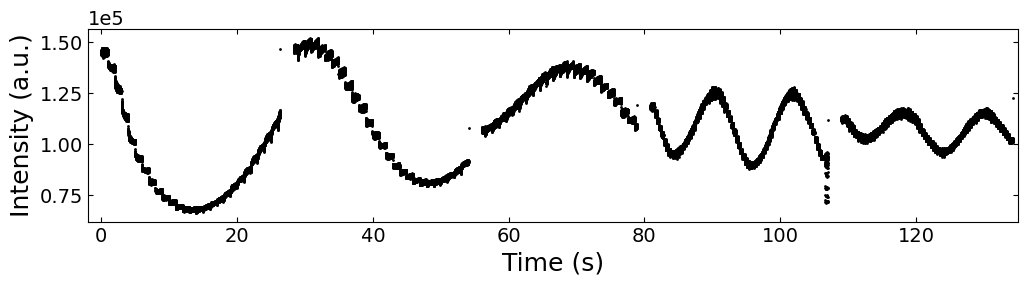

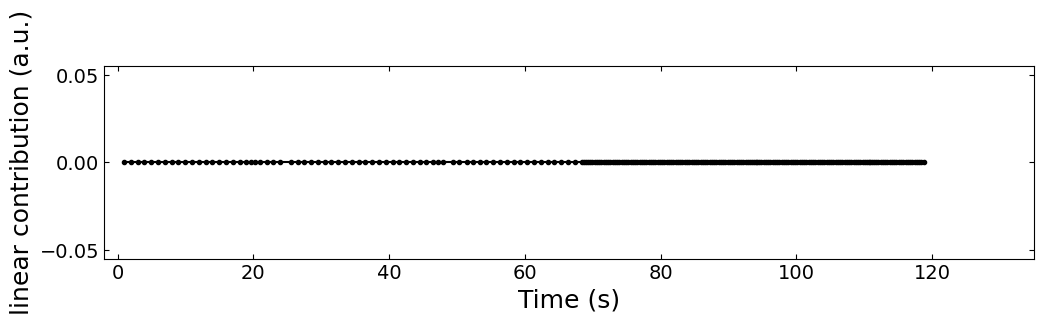

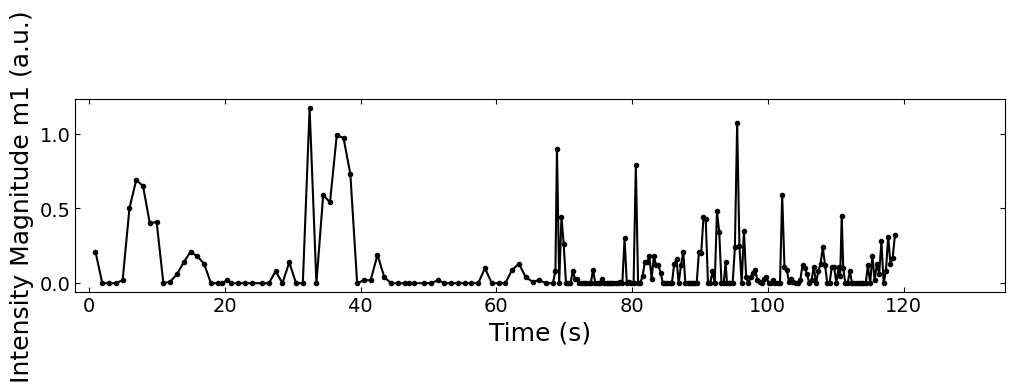

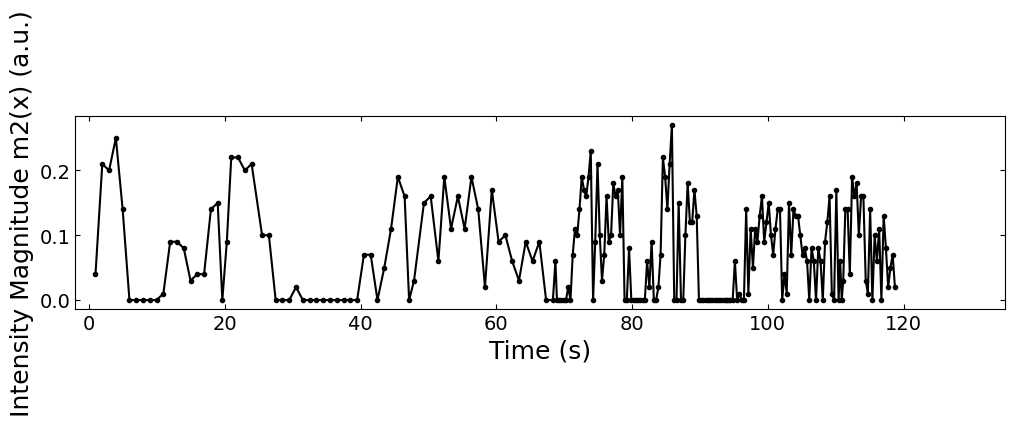

/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/scipy/stats/stats.py:2568: RuntimeWarning: invalid value encountered in subtract
  z = (a - mn) / std


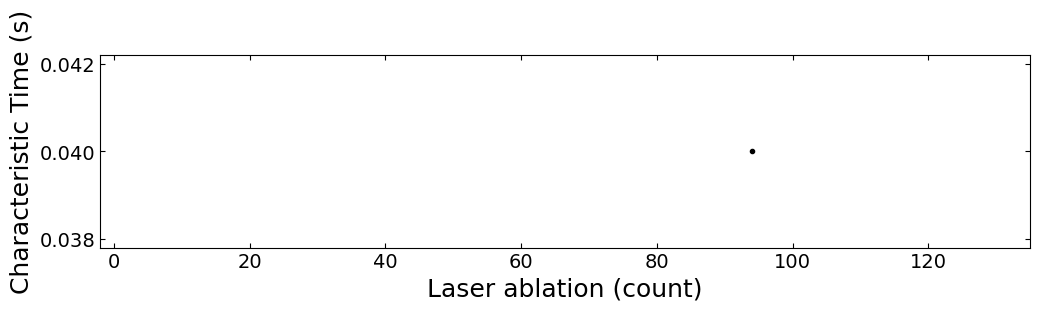

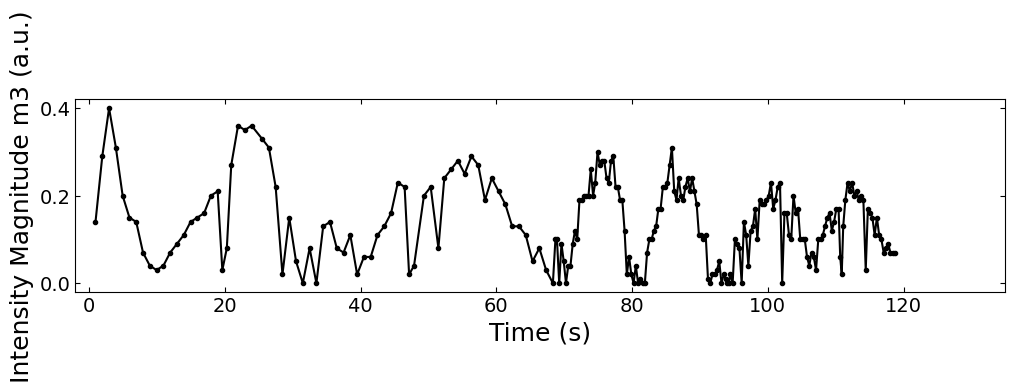

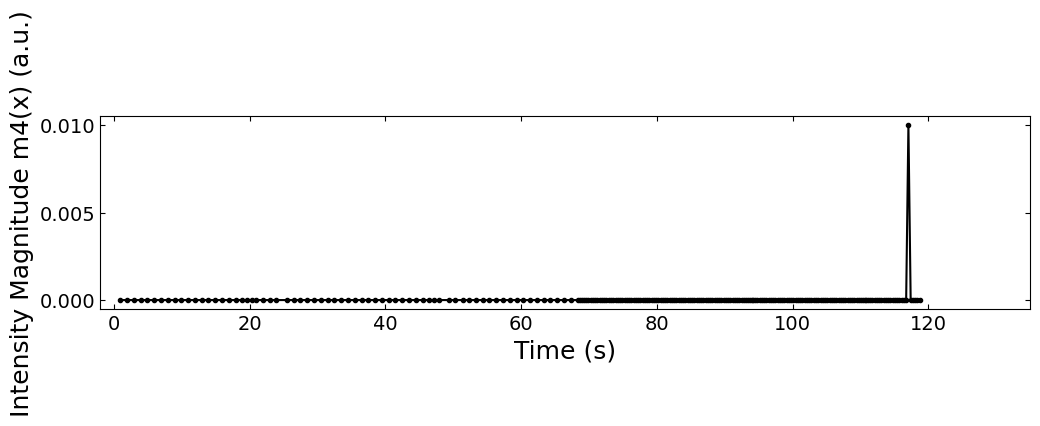

/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/scipy/stats/stats.py:2568: RuntimeWarning: invalid value encountered in subtract
  z = (a - mn) / std


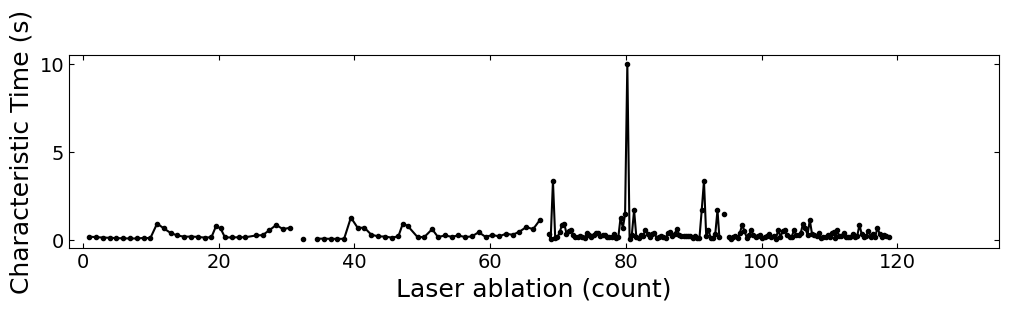

In [68]:
spot = 'spot_2'
metric = 'img_intensity'
fit_settings={'fit_func': 'exp', 'I_diff': 13000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
              'from_previous': False, 'weight_previous': False, 'relative_intensity': False, 'use_prev_as_bound': True}

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
length = 500
model_path = 'linear_model_9parameters_test6_savgolPCA.pt'
visualize = False

x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
linear, m1, m2, relax12, m3, m4, relax34, x_sample = analyze_curves_DL(h5_para_file, growth_dict, spot, metric, visualize=visualize, fit_settings=fit_settings)

plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-2, 135))

plot_curve(x_sample, linear, plot_type='lineplot', xlabel='Time (s)', ylabel='linear contribution (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

plot_curve(x_sample, m1, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m1 (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
plot_curve(x_sample, m2, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m2(x) (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
x_sample12_ro, relax12_ro = remove_outlier(x_sample, relax12, 0)
plot_curve(x_sample12_ro, relax12_ro, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

plot_curve(x_sample, m3, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m3 (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
plot_curve(x_sample, m4, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m4(x) (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
x_sample34_ro, relax34_ro = remove_outlier(x_sample, relax34, 0)
plot_curve(x_sample34_ro, relax34_ro, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

In [69]:
x_sample

array([  0.958,   1.958,   2.958,   3.958,   4.958,   5.958,   6.958,
         7.958,   8.958,   9.958,  10.958,  11.958,  12.96 ,  13.958,
        14.958,  15.958,  16.956,  17.958,  18.956,  19.642,  20.304,
        20.956,  21.956,  22.958,  23.956,  25.498,  26.5  ,  27.498,
        28.498,  29.5  ,  30.5  ,  31.5  ,  32.5  ,  33.5  ,  34.5  ,
        35.5  ,  36.502,  37.5  ,  38.498,  39.502,  40.5  ,  41.498,
        42.498,  43.498,  44.498,  45.498,  46.494,  47.156,  47.884,
        49.342,  50.336,  51.472,  52.34 ,  53.332,  54.34 ,  55.334,
        56.34 ,  57.338,  58.332,  59.34 ,  60.338,  61.34 ,  62.338,
        63.34 ,  64.338,  65.338,  66.34 ,  67.338,  68.338,  68.71 ,
        68.936,  69.268,  69.6  ,  69.932,  70.266,  70.6  ,  70.928,
        71.26 ,  71.592,  71.92 ,  72.254,  72.588,  72.92 ,  73.25 ,
        73.584,  73.916,  74.26 ,  74.574,  74.912,  75.244,  75.57 ,
        75.904,  76.24 ,  76.572,  76.904,  77.236,  77.568,  77.902,
        78.232,  78.

In [70]:
x_sample12_ro

array([  0.958,   1.958,   2.958,   3.958,   4.958,   5.958,   6.958,
         7.958,   8.958,   9.958,  10.958,  11.958,  12.96 ,  13.958,
        14.958,  15.958,  16.956,  17.958,  18.956,  19.642,  20.304,
        20.956,  21.956,  22.958,  23.956,  25.498,  26.5  ,  27.498,
        28.498,  29.5  ,  30.5  ,  31.5  ,  32.5  ,  33.5  ,  34.5  ,
        35.5  ,  36.502,  37.5  ,  38.498,  39.502,  40.5  ,  41.498,
        42.498,  43.498,  44.498,  45.498,  46.494,  47.156,  47.884,
        49.342,  50.336,  51.472,  52.34 ,  53.332,  54.34 ,  55.334,
        56.34 ,  57.338,  58.332,  59.34 ,  60.338,  61.34 ,  62.338,
        63.34 ,  64.338,  65.338,  66.34 ,  67.338,  68.338,  68.71 ,
        68.936,  69.268,  69.6  ,  69.932,  70.266,  70.6  ,  70.928,
        71.26 ,  71.592,  71.92 ,  72.254,  72.588,  72.92 ,  73.25 ,
        73.584,  73.916,  74.26 ,  74.574,  74.912,  75.244,  75.57 ,
        75.904,  76.24 ,  76.572,  76.904,  77.236,  77.568,  77.902,
        78.232,  78.

# train test7 model

In [ ]:
h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
dl, y_pca = prepare_dataloader(h5_para_file, growth_dict, batch_size=32, visualize=True)

model = model_linear()
print(model)
out, x = model(torch.randn(32, 1, 500))
print(out.shape, x.shape)

device = torch.device('cpu')
NAME = '1d_regression'

lr = 1e-3
loss_func = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

start = 0
epochs = 500
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, 
                            steps_per_epoch=len(dl))

logs = train_epochs(model, loss_func, optimizer, device, dl, epochs, start, scheduler)
torch.save(model, 'linear_model_9parameters_test7_savgolPCA.pt')

In [ ]:
# model = torch.load('linear_model_9parameters.pt')
# inputs = torch.tensor(y_data).to(device).to(torch.float32).unsqueeze(1)

inputs = torch.tensor(y_rec).to(device).to(torch.float32).unsqueeze(1)
y_fit, parameters_all = model(inputs)
parameters_all = np.round(parameters_all.squeeze().detach().numpy(), 2)

labels = tag_equation(parameters_all)
t = torch.linspace(0, 1, inputs.shape[-1]).unsqueeze(0).repeat(len(inputs),1)
y = inputs.cpu().squeeze().numpy()
y_fit = y_fit.detach().cpu().squeeze().numpy()
show_grid_plots(t[::10], y[::10], ys_fit=y_fit[::10], labels=labels[::10], subplot_height=3)

## visualize results

In [ ]:
spot = 'spot_2'
metric = 'img_intensity'
fit_settings={'fit_func': 'exp', 'I_diff': 13000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
              'from_previous': False, 'weight_previous': False, 'relative_intensity': False, 'use_prev_as_bound': True}

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
length = 500
model_path = 'linear_model_9parameters_test7_savgolPCA.pt'
visualize = True

x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
linear, m1, m2, relax12, m3, m4, relax34, x_sample = analyze_curves_DL(h5_para_file, growth_dict, spot, metric, visualize=visualize, fit_settings=fit_settings)

plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-2, 135))

plot_curve(x_sample, linear, plot_type='lineplot', xlabel='Time (s)', ylabel='linear contribution (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

plot_curve(x_sample, m1, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m1 (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
plot_curve(x_sample, m2, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m2(x) (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
x_sample12_ro, relax12_ro = remove_outlier(x_sample, relax12, 0)
plot_curve(x_sample12_ro, relax12_ro, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

plot_curve(x_sample, m3, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m3 (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
plot_curve(x_sample, m4, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m4(x) (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
x_sample34_ro, relax34_ro = remove_outlier(x_sample, relax34, 0)
plot_curve(x_sample34_ro, relax34_ro, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

# train test9 model

In [ ]:
h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_01':1, 'growth_02':1, 'growth_03':1, 'growth_04':1, 'growth_05':1}
dl, y_pca = prepare_dataloader(h5_para_file, growth_dict, batch_size=32, visualize=True)

model = model_linear()
print(model)
out, x = model(torch.randn(32, 1, 500))
print(out.shape, x.shape)

device = torch.device('cpu')
NAME = '1d_regression'

lr = 1e-3
loss_func = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

start = 0
epochs = 2000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, 
                            steps_per_epoch=len(dl))

logs = train_epochs(model, loss_func, optimizer, device, dl, epochs, start, scheduler)
torch.save(model, 'linear_model_9parameters_test9_savgolPCA.pt')

In [ ]:
# model = torch.load('linear_model_9parameters.pt')
# inputs = torch.tensor(y_data).to(device).to(torch.float32).unsqueeze(1)

inputs = torch.tensor(y_rec).to(device).to(torch.float32).unsqueeze(1)
y_fit, parameters_all = model(inputs)
parameters_all = np.round(parameters_all.squeeze().detach().numpy(), 2)

labels = tag_equation(parameters_all)
t = torch.linspace(0, 1, inputs.shape[-1]).unsqueeze(0).repeat(len(inputs),1)
y = inputs.cpu().squeeze().numpy()
y_fit = y_fit.detach().cpu().squeeze().numpy()
show_grid_plots(t[::10], y[::10], ys_fit=y_fit[::10], labels=labels[::10], subplot_height=3)

In [ ]:
spot = 'spot_2'
metric = 'img_intensity'
fit_settings={'fit_func': 'exp', 'I_diff': 13000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
              'from_previous': False, 'weight_previous': False, 'relative_intensity': False, 'use_prev_as_bound': True}

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
length = 500
model_path = 'linear_model_9parameters_test9_savgolPCA.pt'
visualize = True

x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
linear, m1, m2, relax12, m3, m4, relax34, x_sample = analyze_curves_DL(h5_para_file, growth_dict, spot, metric, visualize=visualize, fit_settings=fit_settings)

plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-2, 135))

plot_curve(x_sample, linear, plot_type='lineplot', xlabel='Time (s)', ylabel='linear contribution (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

plot_curve(x_sample, m1, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m1 (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
plot_curve(x_sample, m2, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m2(x) (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
x_sample12_ro, relax12_ro = remove_outlier(x_sample, relax12, 0)
plot_curve(x_sample12_ro, relax12_ro, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

plot_curve(x_sample, m3, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m3 (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
plot_curve(x_sample, m4, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude m4(x) (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
x_sample34_ro, relax34_ro = remove_outlier(x_sample, relax34, 0)
plot_curve(x_sample34_ro, relax34_ro, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))